In [1]:
# CREAZIONE NUOVO DASET PARTE 1, A QUESTO DOVREMO AGGIUNGERE TIR, TAR, TBR ANDANDO AD ESEGUIRE IL CODICE RELATIVO AD OGNI CELLA NEL FILE AnalisiStatistica.ipynb
############################################################################################
import pandas as pd
from datetime import datetime

# 1) Carica il file
df = pd.read_csv("Excel/Patient_info.csv")

# 2) Seleziona le colonne di interesse
parte1 = df[['Patient_ID', 'Sex', 'Birth_year', 'Number_of_diagnostics']].copy()

# 3) Mappa Sex in binario: 1 = maschio, 0 = femmina
#    Adatta la mappatura ai valori esatti presenti nel tuo CSV (es. 'Male'/'Female', 'M'/'F', ecc.)
parte1['Sex'] = parte1['Sex'].map({'M': 1, 'F': 0})

# 4) Trasforma Number_of_diagnostics in variabile binaria Has_Diagnostics
parte1['Has_Diagnostics'] = (parte1['Number_of_diagnostics'] >= 1).astype(int)

# 5) Calcola l'età a partire dall'anno di nascita e sostituisci Birth_year
current_year = datetime.now().year
parte1['Age'] = current_year - parte1['Birth_year']

# 6) Rimuovi le colonne originali non più necessarie
parte1 = parte1.drop(columns=['Birth_year', 'Number_of_diagnostics'])

# 7) Riorganizza le colonne finali
parte1 = parte1[['Patient_ID', 'Sex', 'Age', 'Has_Diagnostics']]

# 8) Salva su CSV
parte1.to_csv("Excel/Parte1.csv", index=False)

print("File salvato in Excel/Parte1.csv")



File salvato in Excel/Parte1.csv


In [2]:
#CREA UN DATASET PER IL CLUSTERING CHE MANTENGA LA COLONNA DELL'ID DEL PAZIENTE
#ORIGINARIAMENTE E' STATO CREATO IL FILE Clustering.csv, ma era stata rimossa la colonna Patient_ID, QUINDI E' STATO CREATO IL NUOVO FILE Clustering2.csv CHE MANTIENE QUELLA COLONNA

import pandas as pd

# Carica i due dataset
df1 = pd.read_csv("Excel/Parte1.csv")
df2 = pd.read_csv("Excel/parte2_v1.csv")

# Rimuove la colonna "Complicanze" dal secondo dataset
df2 = df2.drop(columns=["Complicanze"])

# Effettua il merge tra df1 (usando Patient_ID) e df2 (usando ID)
merged_df = pd.merge(df1, df2, left_on="Patient_ID", right_on="ID", how="inner")

merged_df = merged_df.drop(columns=["ID"])

# Salva il dataframe risultante in un file CSV
merged_df.to_csv("Excel/Clustering2.csv", index=False)

print("Merge completato. File salvato come 'Clustering2.csv'.")


Merge completato. File salvato come 'Clustering2.csv'.


In [ ]:
#RIMUOVE LA COLONNA Patient_ID DAL FILE Clustering.csv, SE USATO ORA DARA' ERRORE PERCHE' LA COLONNA GIA E' STATA RIMOSSA DAL DATASET

import pandas as pd

# Carica i due dataset
df1 = pd.read_csv("Excel/Parte1.csv")
df2 = pd.read_csv("parte2_v1.csv")

# Rimuove la colonna "Complicanze" dal secondo dataset
df2 = df2.drop(columns=["Complicanze"])

# Effettua il merge tra df1 (usando Patient_ID) e df2 (usando ID)
merged_df = pd.merge(df1, df2, left_on="Patient_ID", right_on="ID", how="inner")

# Rimuove la colonna "ID" e "Patient_ID"
merged_df = merged_df.drop(columns=["ID","Patient_ID"])

# Salva il dataframe risultante in un file CSV
merged_df.to_csv("Excel/Clustering.csv", index=False)

print("Merge completato. File salvato come 'Clustering.csv'.")


In [ ]:
#CREA UN DATASET PER IL CLUSTERING CHE MANTENGA LA COLONNA DELL'ID DEL PAZIENTE

import pandas as pd

# Carica i due dataset
df1 = pd.read_csv("Excel/Parte1.csv")
df2 = pd.read_csv("Excel/parte2_v1.csv")

# Rimuove la colonna "Complicanze" dal secondo dataset
df2 = df2.drop(columns=["Complicanze"])

# Effettua il merge tra df1 (usando Patient_ID) e df2 (usando ID)
merged_df = pd.merge(df1, df2, left_on="Patient_ID", right_on="ID", how="inner")

merged_df = merged_df.drop(columns=["ID"])

# Salva il dataframe risultante in un file CSV
merged_df.to_csv("Excel/Clustering2.csv", index=False)

print("Merge completato. File salvato come 'Clustering2.csv'.")


In [3]:
#CLUSTERING CON KMEANS, USANDO 4 METODI DI IMPUTAZIONE DIVERSI E USANDO DIVERSI IPERPARAMETRI DELLA FUNZIONE, TUTTI I RISULTATI OTTENUTI SONO STATI STAMPATI CON LE RELATIVE CARATTERISTICHE

import numpy as np
import pandas as pd
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, silhouette_score, adjusted_rand_score

df = pd.read_csv("Excel/Clustering.csv")

X = df.drop(columns=["Has_Diagnostics"])
y = df["Has_Diagnostics"]

# Definisci i quattro imputatori
imputers = {
    # Sostituisce ogni valore mancante con la media aritmetica della colonna
    "Mean":    SimpleImputer(strategy="mean"),

    # Sostituisce ogni valore mancante con la mediana (valore centrale) della colonna,
    "Median":  SimpleImputer(strategy="median"),

    # Per ogni riga con missing, calcola i k (=5) pazienti più “simili” sulle altre feature
    # e sostituisce i NaN con la media dei valori corrispondenti di quei vicini
    "KNN":     KNNImputer(n_neighbors=5),

     # Imputa in modo iterativo (MICE):
    # 1) Inizializza i NaN (es. con la media)
    # 2) Per ogni colonna con missing, allena un modello sulle altre variabili per prevedere i NaN
    # 3) Ripete la procedura a catena per max_iter volte, migliorando progressivamente le stime
    "MICE":    IterativeImputer(max_iter=10, random_state=42)
}

# 4) Griglia di iperparametri per KMeans
param_grid = {
    'n_clusters': [2],              # fisso a 2
    'init':       ['k-means++', 'random'],
    'n_init':     [10, 20],
    'max_iter':   [100, 300],
    'tol':        [1e-4, 1e-3],
    'algorithm':  ['lloyd', 'elkan']
}

# 5) Funzione di valutazione
def evaluate(imputer_name, imputer, params):
    # a) Imputa i dati mancanti con il metodo scelto
    X_imp = imputer.fit_transform(X)
    # b) Standardizzazione
    X_scaled = StandardScaler().fit_transform(X_imp)
    # c) Configura e applica KMeans
    kmeans = KMeans(
        n_clusters=params['n_clusters'],
        init=params['init'],
        n_init=params['n_init'],
        max_iter=params['max_iter'],
        tol=params['tol'],
        algorithm=params['algorithm'],
        random_state=42
    )
    clusters = kmeans.fit_predict(X_scaled)
    # --- Statistiche demografiche e diagnostici per cluster ---
    df_tmp = df.copy()
    df_tmp['Cluster'] = clusters

    # Fasce d'età
    bins   = [0, 29, 49, 69, np.inf]
    labels = ['<30', '30-49', '50-69', '70+']
    df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)

    # Conta i diagnosi per cluster × age group × sesso
    diag_counts = (
        df_tmp
        .groupby(['Cluster', 'AgeGroup', 'Sex'], observed=True)['Has_Diagnostics']
        .value_counts()
        .unstack(fill_value=0)
        .rename(columns={0: 'No_Dx', 1: 'Yes_Dx'})
    )
    # print(f"\n>> Diagnosi (Has_Diagnostics) per cluster, fasce d'età e sesso:")
    # print(diag_counts)
    # --------------------------------------------------------------


    # d) Metriche
    sil = silhouette_score(X_scaled, clusters)
    ari = adjusted_rand_score(y, clusters)
    db_index = davies_bouldin_score(X_scaled, clusters)
    ch_index = calinski_harabasz_score(X_scaled, clusters)
    cm  = confusion_matrix(y, clusters)
    return sil, ari, db_index, ch_index, cm

# 6) Loop su imputatori e griglia
results = []
# essenzialmente con qeusto ciclo facciamo si che per ogni strategia di imputazione (media, mediana, KNN, MICE) vengano provate tutte le combinazioni di parametri
for imp_name, imp in imputers.items():
    for init in param_grid['init']:
        for n_init in param_grid['n_init']:
            for max_iter in param_grid['max_iter']:
                for tol in param_grid['tol']:
                    for algo in param_grid['algorithm']:
                        params = {
                            'n_clusters': 2,
                            'init':       init,
                            'n_init':     n_init,
                            'max_iter':   max_iter,
                            'tol':        tol,
                            'algorithm':  algo
                        }
                        sil, ari, db_index, ch_index, cm = evaluate(imp_name, imp, params)
                        results.append({
                            'Imputer': imp_name,
                            **params,
                            'Silhouette': sil,
                            'ARI': ari,
                            'Davies-Bouldin Index': db_index,
                            'Calinski-Harabasz Index': ch_index,
                            'ConfusionMatrix': cm
                        })
                        print(
                            f"{imp_name} | init={init}, n_init={n_init}, "
                            f"max_iter={max_iter}, tol={tol}, algo={algo} "
                            f"-> silhouette={sil:.3f}, ARI={ari}, Davies-Bouldin Index={db_index}, Calinski-Harabasz Index={ch_index}"
                        )
                        print("Confusion Matrix:\n", cm)

Mean | init=k-means++, n_init=10, max_iter=100, tol=0.0001, algo=lloyd -> silhouette=0.109, ARI=-0.0004143618098887594, Davies-Bouldin Index=2.7097925180137206, Calinski-Harabasz Index=77.04239571805249
Confusion Matrix:
 [[126  99]
 [283 215]]
Mean | init=k-means++, n_init=10, max_iter=100, tol=0.0001, algo=elkan -> silhouette=0.109, ARI=-0.0004143618098887594, Davies-Bouldin Index=2.7097925180137206, Calinski-Harabasz Index=77.04239571805249
Confusion Matrix:
 [[126  99]
 [283 215]]
Mean | init=k-means++, n_init=10, max_iter=100, tol=0.001, algo=lloyd -> silhouette=0.108, ARI=-0.0009898865918665611, Davies-Bouldin Index=2.7126427832171567, Calinski-Harabasz Index=77.02641317469164
Confusion Matrix:
 [[ 99 126]
 [218 280]]
Mean | init=k-means++, n_init=10, max_iter=100, tol=0.001, algo=elkan -> silhouette=0.108, ARI=-0.0009898865918665611, Davies-Bouldin Index=2.7126427832171567, Calinski-Harabasz Index=77.02641317469164
Confusion Matrix:
 [[ 99 126]
 [218 280]]
Mean | init=k-means++,

In [8]:
# CODICE PER RESTITUIRE I CLUSTER OTTENUTI CON KMEANS CHE HANNO IL VALORE DI ARI PIU ALTO, PER OGNI RISULTATO E' STATO MOSTRATO IL GRAFICO CON DISTRIBUZIONE DI SESSO, ETA E COMPLICANZE.
# I RISULTATI OTTENUTI SONO TUTTI UGUALI, CON STESSO ARI E STESSA MATRICE DI CONFUSIONE
#
# import pandas as pd
# from sklearn.impute import SimpleImputer, KNNImputer
# from sklearn.experimental import enable_iterative_imputer  # noqa
# from sklearn.impute import IterativeImputer
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# from sklearn.metrics import confusion_matrix, silhouette_score, adjusted_rand_score
# import matplotlib.pyplot as plt
# import numpy as np
#
# df = pd.read_csv("Excel/Clustering.csv")
#
# X = df.drop(columns=["Has_Diagnostics"])
# y = df["Has_Diagnostics"]
#
# # Definisci i quattro imputatori
# imputers = {
#     # Sostituisce ogni valore mancante con la media aritmetica della colonna
#     "Mean":    SimpleImputer(strategy="mean"),
#
#     # Sostituisce ogni valore mancante con la mediana (valore centrale) della colonna,
#     "Median":  SimpleImputer(strategy="median"),
#
#     # Per ogni riga con missing, calcola i k (=5) pazienti più “simili” sulle altre feature
#     # e sostituisce i NaN con la media dei valori corrispondenti di quei vicini
#     "KNN":     KNNImputer(n_neighbors=5),
#
#      # Imputa in modo iterativo (MICE):
#     # 1) Inizializza i NaN (es. con la media)
#     # 2) Per ogni colonna con missing, allena un modello sulle altre variabili per prevedere i NaN
#     # 3) Ripete la procedura a catena per max_iter volte, migliorando progressivamente le stime
#     "MICE":    IterativeImputer(max_iter=10, random_state=42)
# }
#
# # 4) Griglia di iperparametri per KMeans
# param_grid = {
#     'n_clusters': [2],              # fisso a 2
#     'init':       ['k-means++', 'random'],
#     'n_init':     [10, 20],
#     'max_iter':   [100, 300],
#     'tol':        [1e-4, 1e-3],
#     'algorithm':  ['lloyd', 'elkan']
# }
#
# # 5) Funzione di valutazione
# def evaluate(imputer_name, imputer, params):
#     # a) Imputa i dati mancanti con il metodo scelto
#     X_imp = imputer.fit_transform(X)
#     # b) Standardizzazione
#     X_scaled = StandardScaler().fit_transform(X_imp)
#     # c) Configura e applica KMeans
#     kmeans = KMeans(
#         n_clusters=params['n_clusters'],
#         init=params['init'],
#         n_init=params['n_init'],
#         max_iter=params['max_iter'],
#         tol=params['tol'],
#         algorithm=params['algorithm'],
#         random_state=42
#     )
#     clusters = kmeans.fit_predict(X_scaled)
#     # --- Statistiche demografiche e diagnostici per cluster ---
#     df_tmp = df.copy()
#     df_tmp['Cluster'] = clusters
#
#     # Fasce d'età
#     bins   = [0, 29, 49, 69, np.inf]
#     labels = ['<30', '30-49', '50-69', '70+']
#     df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)
#
#     # Conta i diagnosi per cluster × age group × sesso
#     diag_counts = (
#         df_tmp
#         .groupby(['Cluster', 'AgeGroup', 'Sex'], observed=True)['Has_Diagnostics']
#         .value_counts()
#         .unstack(fill_value=0)
#         .rename(columns={0: 'No_Dx', 1: 'Yes_Dx'})
#     )
#     # print(f"\n>> Diagnosi (Has_Diagnostics) per cluster, fasce d'età e sesso:")
#     # print(diag_counts)
#     # --------------------------------------------------------------
#
#
#     # d) Metriche
#     sil = silhouette_score(X_scaled, clusters)
#     ari = adjusted_rand_score(y, clusters)
#     cm  = confusion_matrix(y, clusters)
#     return sil, ari, cm
#
# import matplotlib.pyplot as plt
# import numpy as np
#
# # Funzione per generare il grafico
# def plot_cluster_demographics(df_tmp):
#     # Creazione delle fasce d'età
#     bins = [0, 29, 49, 69, np.inf]
#     labels = ['<30', '30-49', '50-69', '>69']
#     df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)
#
#     # Preparazione dei dati per il plot
#     cluster_data = []
#     for cluster in [0, 1]:
#         cluster_df = df_tmp[df_tmp['Cluster'] == cluster]
#
#         age_counts = []
#         for age_group in labels:
#             age_df = cluster_df[cluster_df['AgeGroup'] == age_group]
#
#             # Maschi con complicanze
#             male_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 1)])
#             # Maschi senza complicanze
#             male_no_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 0)])
#             # Femmine con complicanze
#             female_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 1)])
#             # Femmine senza complicanze
#             female_no_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 0)])
#
#             age_counts.append({
#                 'Male_Dx': male_dx,
#                 'Male_NoDx': male_no_dx,
#                 'Female_Dx': female_dx,
#                 'Female_NoDx': female_no_dx,
#                 'Total': male_dx + male_no_dx + female_dx + female_no_dx
#             })
#
#         cluster_data.append(age_counts)
#
#     # Creazione del grafico
#     fig, ax = plt.subplots(figsize=(14, 8))
#
#     # Definizione dei colori
#     colors = {
#         'Male_Dx': '#1f77b4',      # Blu scuro
#         'Male_NoDx': '#a5c8e4',    # Blu chiaro
#         'Female_Dx': '#e377c2',    # Rosa scuro
#         'Female_NoDx': '#f8b8d8'   # Rosa chiaro
#     }
#
#     bar_width = 0.35
#     x = np.arange(len(labels))
#
#     for i, cluster in enumerate([0, 1]):
#         # Posizioni delle barre per ogni cluster
#         positions = x + i * bar_width
#
#         # Creazione delle barre stackate per ogni gruppo
#         bottom = np.zeros(len(labels))
#
#         # Lista per memorizzare le posizioni e i valori delle etichette
#         label_positions = []
#         label_values = []
#
#         for segment in ['Male_Dx', 'Male_NoDx', 'Female_Dx', 'Female_NoDx']:
#             counts = [cluster_data[cluster][j][segment] for j in range(len(labels))]
#             ax.bar(positions, counts, bar_width, bottom=bottom,
#                    color=colors[segment], edgecolor='black',
#                    label=f'Cluster {cluster} {segment}' if i == 0 else "")
#
#             # Aggiungi etichette per ogni segmento
#             for j, count in enumerate(counts):
#                 if count > 0:  # Mostra solo etichette per valori > 0
#                     ax.text(positions[j], bottom[j] + count/2, str(count),
#                             ha='center', va='center', color='black', fontsize=8)
#
#             bottom += counts
#
#         # Aggiungi etichetta con il totale per ogni cluster e fascia d'età
#         for j in range(len(labels)):
#             total = cluster_data[cluster][j]['Total']
#             ax.text(positions[j], bottom[j] + 5, f'Tot: {total}',
#                     ha='center', va='bottom', color='black', fontsize=9, fontweight='bold')
#
#     # Configurazione dell'asse x
#     ax.set_xticks(x + bar_width/2)
#     ax.set_xticklabels(labels)
#     ax.set_xlabel('Fascia d\'età')
#     ax.set_ylabel('Numero di pazienti')
#     ax.set_title('')
#
#     # Creazione della legenda
#     handles = [
#         plt.Rectangle((0,0),1,1, color='#1f77b4', label='Maschi con complicanze'),
#         plt.Rectangle((0,0),1,1, color='#a5c8e4', label='Maschi senza complicanze'),
#         plt.Rectangle((0,0),1,1, color='#e377c2', label='Femmine con complicanze'),
#         plt.Rectangle((0,0),1,1, color='#f8b8d8', label='Femmine senza complicanze'),
#     ]
#     ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
#
#     plt.tight_layout()
#     plt.show()
#
#
# results = []
# # Modifica il loop principale per chiamare la funzione di plotting quando trova l'ARI desiderato
# for imp_name, imp in imputers.items():
#     for init in param_grid['init']:
#         for n_init in param_grid['n_init']:
#             for max_iter in param_grid['max_iter']:
#                 for tol in param_grid['tol']:
#                     for algo in param_grid['algorithm']:
#                         params = {
#                             'n_clusters': 2,
#                             'init':       init,
#                             'n_init':     n_init,
#                             'max_iter':   max_iter,
#                             'tol':        tol,
#                             'algorithm':  algo
#                         }
#                         sil, ari, cm = evaluate(imp_name, imp, params)
#                         results.append({
#                             'Imputer': imp_name,
#                             **params,
#                             'Silhouette': sil,
#                             'ARI': ari,
#                             'ConfusionMatrix': cm
#                         })
#                         if ari == 0.0012036242459496649:
#                             print(
#                                 f"{imp_name} | init={init}, n_init={n_init}, "
#                                 f"max_iter={max_iter}, tol={tol}, algo={algo} "
#                                 f"-> silhouette={sil:.3f}, ARI={ari:.3f}"
#                             )
#                             print("Confusion Matrix:\n", cm)
#
#                             # Prepara i dati per il plotting
#                             X_imp = imp.fit_transform(X)
#                             X_scaled = StandardScaler().fit_transform(X_imp)
#                             kmeans = KMeans(
#                                 n_clusters=params['n_clusters'],
#                                 init=params['init'],
#                                 n_init=params['n_init'],
#                                 max_iter=params['max_iter'],
#                                 tol=params['tol'],
#                                 algorithm=params['algorithm'],
#                                 random_state=42
#                             )
#                             clusters = kmeans.fit_predict(X_scaled)
#                             df_tmp = df.copy()
#                             df_tmp['Cluster'] = clusters
#
#                             # Genera il grafico
#                             plot_cluster_demographics(df_tmp)


>>> Analisi ANOVA tra cluster (feature ordinati per significatività):
                               Feature  Cluster0_Mean  Cluster1_Mean  Cluster0_Std  Cluster1_Std  ANOVA_p_value
1                          %TIR_last3m       0.606039      -0.844842      0.661347      0.747361  1.952846e-114
2                       %TARLV2_last3m      -0.557944       0.777797      0.397675      1.065197   3.570252e-91
3          Glycated hemoglobin (A1c)_1      -0.464192       0.647103      0.587729      1.092420   6.388734e-58
4                       %TARLV1_last3m      -0.448529       0.625268      0.872137      0.813812   1.650552e-53
5                            Glucose_1      -0.357067       0.497766      0.763838      1.074795   1.609890e-32
6                       %TBRLV1_last3m       0.273672      -0.381510      1.130031      0.603271   4.943630e-19
7                             Sodium_1       0.273341      -0.381049      0.958139      0.930008   5.478742e-19
8                                

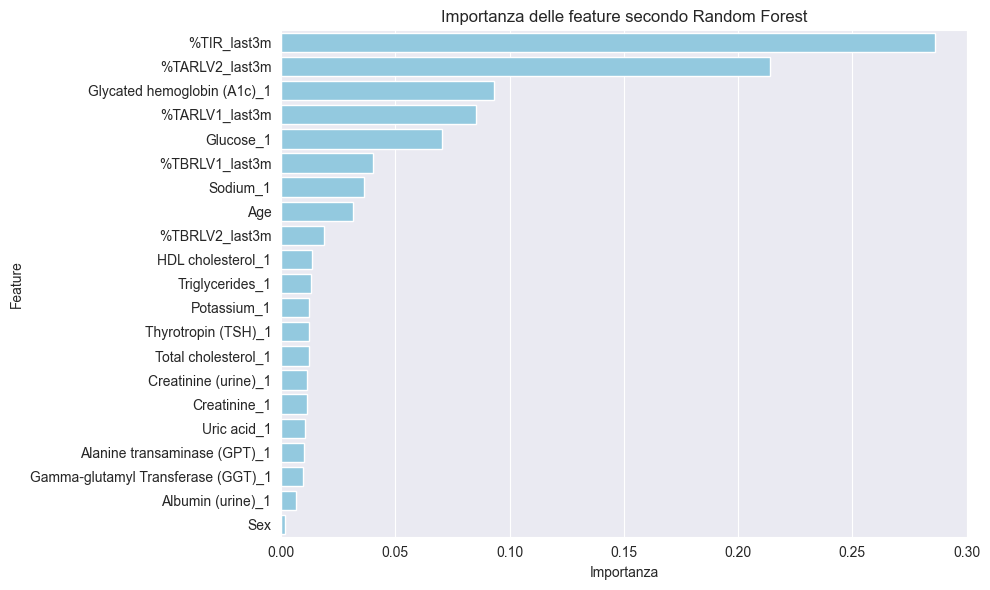

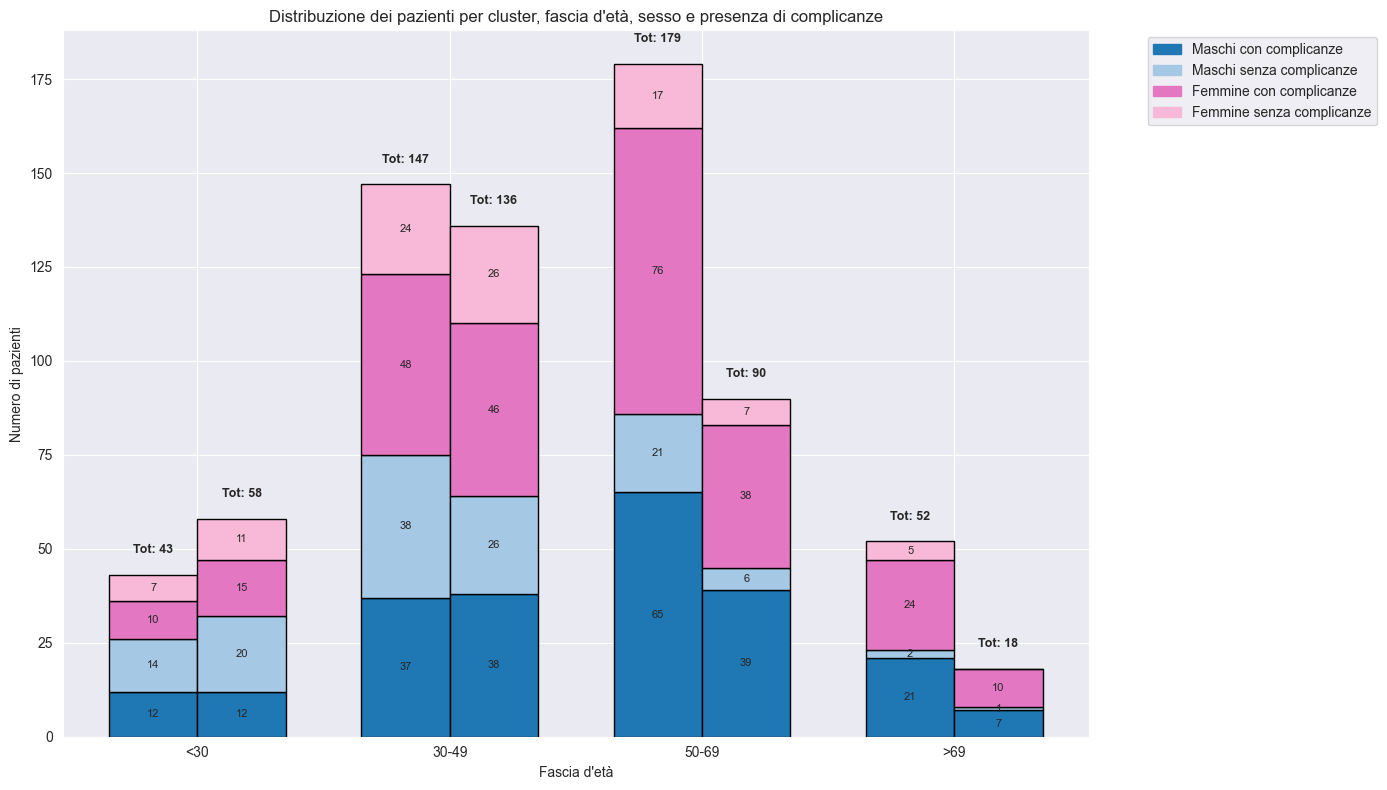

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\2677595966.py:174: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_tmp.groupby(['Cluster', f'{feature}_bin']).size().reset_index(name='Count')


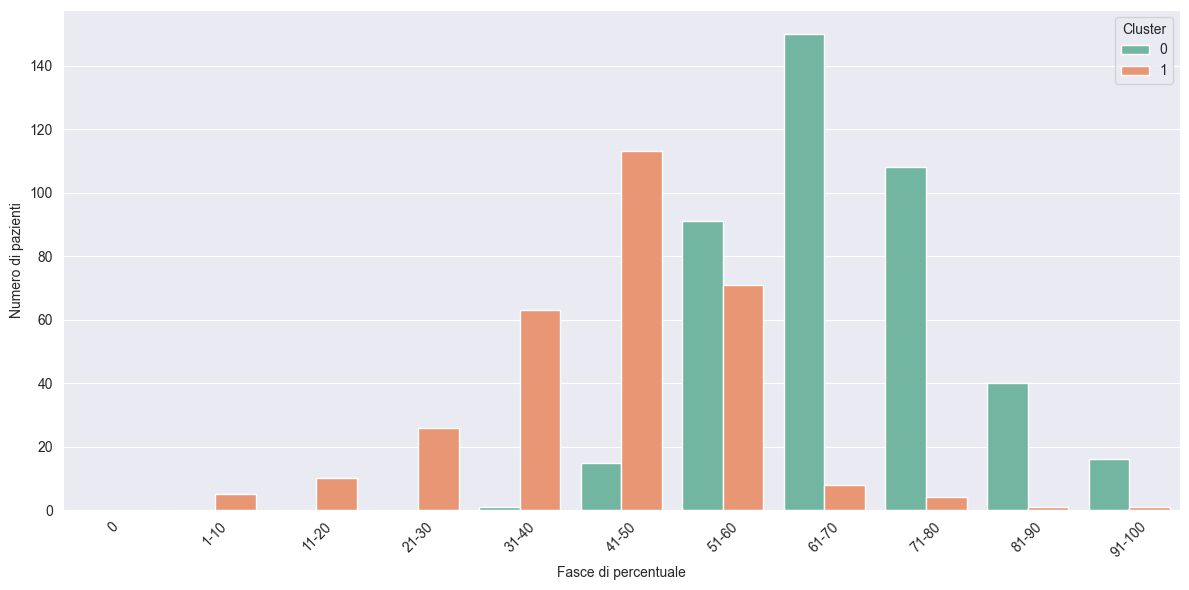

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\2677595966.py:174: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_tmp.groupby(['Cluster', f'{feature}_bin']).size().reset_index(name='Count')


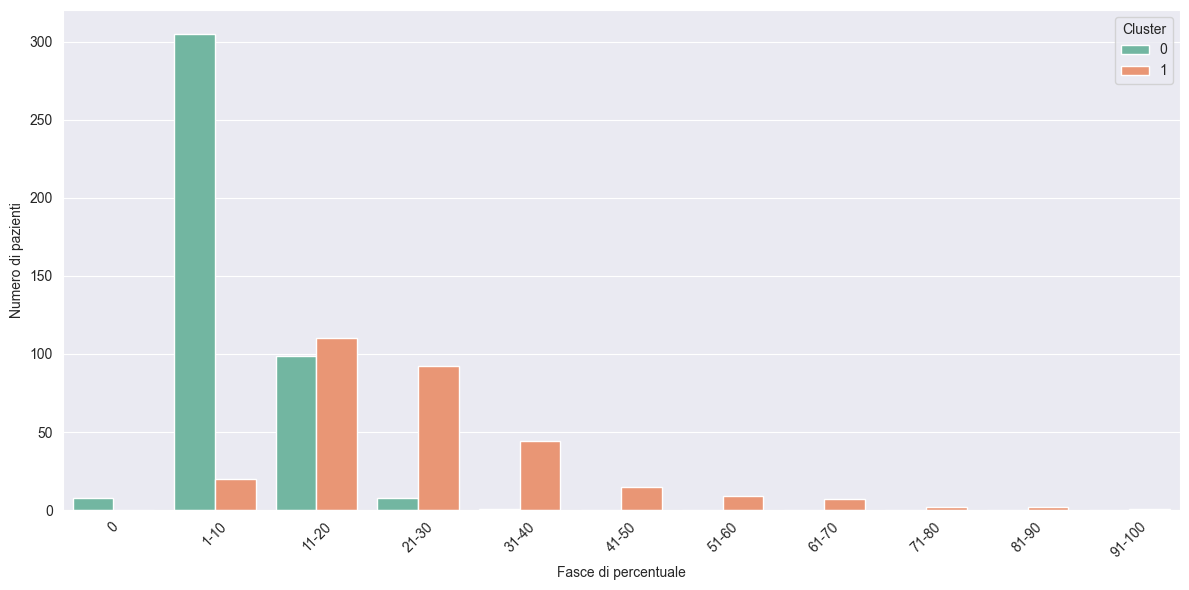

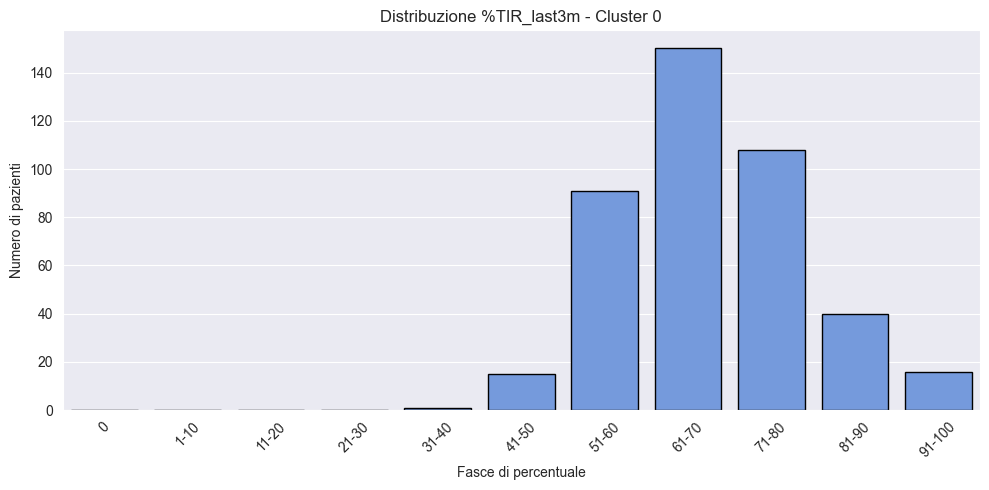

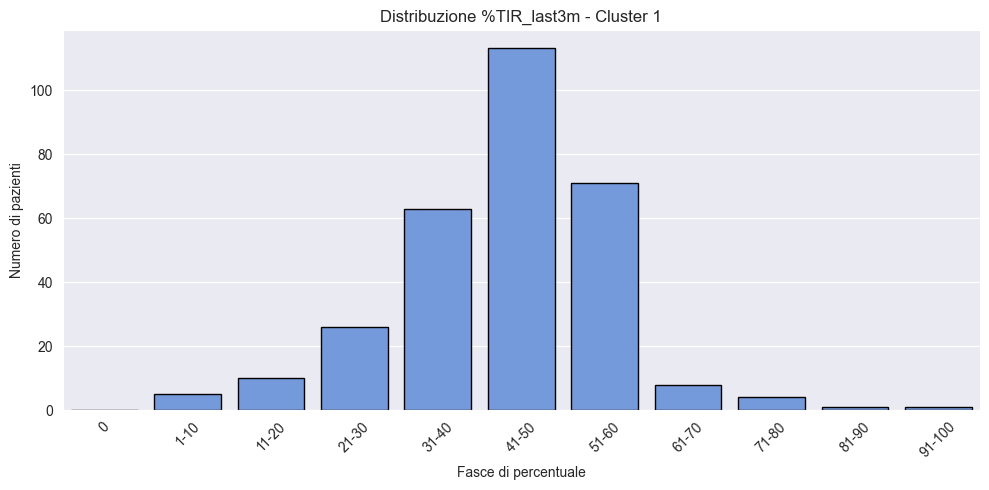

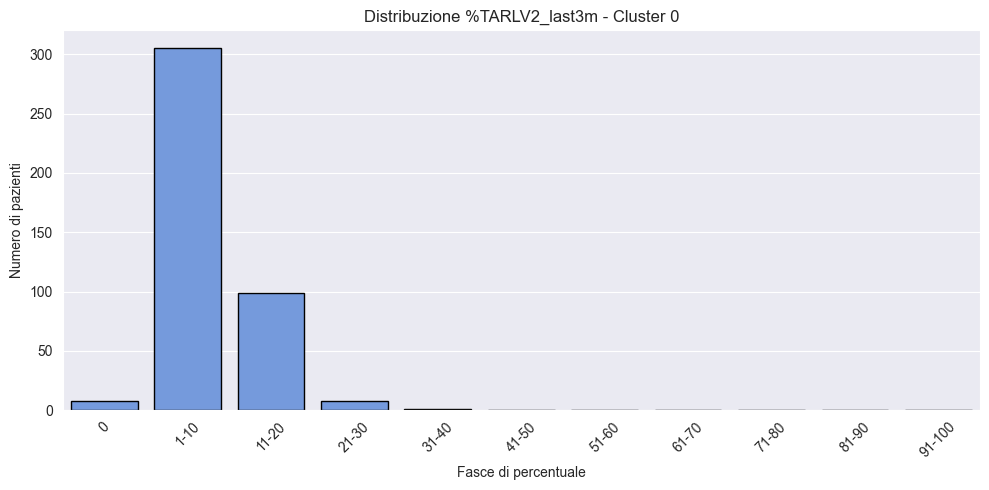

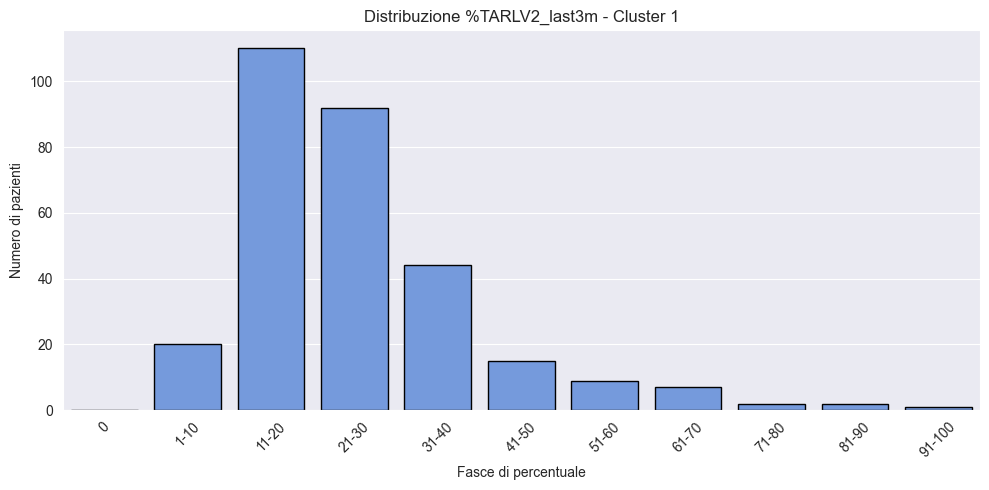

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\2677595966.py:234: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a1c_counts = df_tmp.groupby(['Cluster', 'A1c_bin']).size().reset_index(name='Count')


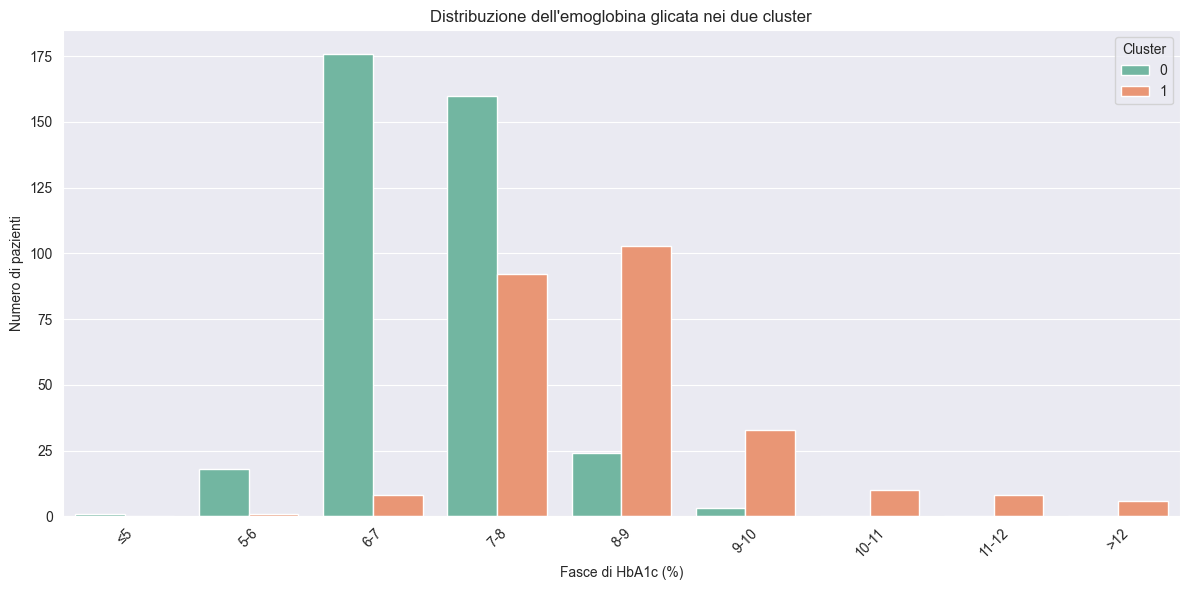


>>> Metriche di valutazione del clustering KMeans:
Silhouette Score: 0.1110
Davies-Bouldin Index: 2.7002
Calinski-Harabasz Index: 77.04
Adjusted Rand Index (ARI): 0.0012


In [9]:
#ANALISI NEL DETTAGLIO DEL SINGOLO CLUSTER MIGLIORE OTTENUTO DA KMEANS, OVVERO QUELLO INDIVIDUATO NEL CODICE PRECEDENTE CON ARI = 0.0012036242459496649

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import f_oneway

# 1. Caricamento dei dati
df = pd.read_csv("Excel/Clustering.csv")
X = df.drop(columns=["Has_Diagnostics"])
y = df["Has_Diagnostics"]

# 2. Imputazione dei valori mancanti (media)
imputer = SimpleImputer(strategy="mean")
X_imp = imputer.fit_transform(X)

# 3. Standardizzazione
X_scaled = StandardScaler().fit_transform(X_imp)

# 4. KMeans clustering
kmeans = KMeans(
    n_clusters=2,
    init='random',
    n_init=10,
    max_iter=100,
    tol=0.001,
    algorithm='lloyd',
    random_state=42
)
clusters = kmeans.fit_predict(X_scaled)

# 5. Aggiunta cluster al DataFrame
df_tmp = df.copy()
df_tmp['Cluster'] = clusters

# 6. Analisi delle feature per cluster (media, std, ANOVA) Analysis of Variance per vedere se la media delle features e' significativamente diversa tra i due cluster
feature_names = X.columns
summary = []


#Per ogni feature del dataset viene calcolata la media e la deviazione standard nei due cluster e il valore p del test ANOVA
#Se p > 0.05 allora la differenza tra le media nei due cluster non e' significativa, altrimenti  e' significativa
for i, feature in enumerate(feature_names):
    cluster_0 = X_scaled[clusters == 0, i]
    cluster_1 = X_scaled[clusters == 1, i]
    stat, p = f_oneway(cluster_0, cluster_1)
    summary.append({
        'Feature': feature,
        'Cluster0_Mean': np.mean(cluster_0),
        'Cluster1_Mean': np.mean(cluster_1),
        'Cluster0_Std': np.std(cluster_0),
        'Cluster1_Std': np.std(cluster_1),
        'ANOVA_p_value': p
    })

df_summary = pd.DataFrame(summary)
df_summary = df_summary.sort_values("ANOVA_p_value").reset_index(drop=True)
df_summary.index = df_summary.index + 1  # Indici da 1 a N

print("\n>>> Analisi ANOVA tra cluster (feature ordinati per significatività):")
print(df_summary.to_string())


# 7. Feature Importance con Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, clusters)
importances = rf.feature_importances_
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# 8. Plot delle feature più importanti
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, color='skyblue')

plt.title('Importanza delle feature secondo Random Forest')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 9. Funzione per il grafico demografico
def plot_cluster_demographics(df_tmp):
    bins = [0, 29, 49, 69, np.inf]
    labels = ['<30', '30-49', '50-69', '>69']
    df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)

    cluster_data = []
    for cluster in [0, 1]:
        cluster_df = df_tmp[df_tmp['Cluster'] == cluster]
        age_counts = []
        for age_group in labels:
            age_df = cluster_df[cluster_df['AgeGroup'] == age_group]
            male_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 1)])
            male_no_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 0)])
            female_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 1)])
            female_no_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 0)])
            age_counts.append({
                'Male_Dx': male_dx,
                'Male_NoDx': male_no_dx,
                'Female_Dx': female_dx,
                'Female_NoDx': female_no_dx,
                'Total': male_dx + male_no_dx + female_dx + female_no_dx
            })
        cluster_data.append(age_counts)

    fig, ax = plt.subplots(figsize=(14, 8))
    colors = {
        'Male_Dx': '#1f77b4',
        'Male_NoDx': '#a5c8e4',
        'Female_Dx': '#e377c2',
        'Female_NoDx': '#f8b8d8'
    }

    bar_width = 0.35
    x = np.arange(len(labels))
    for i, cluster in enumerate([0, 1]):
        positions = x + i * bar_width
        bottom = np.zeros(len(labels))
        for segment in ['Male_Dx', 'Male_NoDx', 'Female_Dx', 'Female_NoDx']:
            counts = [cluster_data[cluster][j][segment] for j in range(len(labels))]
            ax.bar(positions, counts, bar_width, bottom=bottom, color=colors[segment], edgecolor='black')
            for j, count in enumerate(counts):
                if count > 0:
                    ax.text(positions[j], bottom[j] + count/2, str(count), ha='center', va='center', fontsize=8)
            bottom += counts
        for j in range(len(labels)):
            total = cluster_data[cluster][j]['Total']
            ax.text(positions[j], bottom[j] + 5, f'Tot: {total}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Fascia d\'età')
    ax.set_ylabel('Numero di pazienti')
    ax.set_title('Distribuzione dei pazienti per cluster, fascia d\'età, sesso e presenza di complicanze')

    handles = [
        plt.Rectangle((0, 0), 1, 1, color=colors['Male_Dx'], label='Maschi con complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Male_NoDx'], label='Maschi senza complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Female_Dx'], label='Femmine con complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Female_NoDx'], label='Femmine senza complicanze'),
    ]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# 10. Mostra il grafico demografico
plot_cluster_demographics(df_tmp)


# 11. Istogrammi separati per %TIR_last3m e %TARLV2_last3m


# 2 ISTOGRAMMI
# Colonne target
features = ['%TIR_last3m', '%TARLV2_last3m']

# Definizione fasce
bins = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

for feature in features:
    # Crea la colonna con le fasce
    df_tmp[f'{feature}_bin'] = pd.cut(df_tmp[feature], bins=bins, labels=labels, include_lowest=True, right=True)

    # Conta i pazienti per cluster e fascia
    counts = df_tmp.groupby(['Cluster', f'{feature}_bin']).size().reset_index(name='Count')
    counts.rename(columns={f'{feature}_bin': 'Fascia'}, inplace=True)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=counts, x='Fascia', y='Count', hue='Cluster', palette='Set2', dodge=True)

    plt.title('')
    plt.xlabel('Fasce di percentuale')
    plt.ylabel('Numero di pazienti')
    plt.legend(title='Cluster')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



# 4 ISTOGRAMMI
# Colonne target
features = ['%TIR_last3m', '%TARLV2_last3m']

# Definizione fasce
bins = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Crea le colonne binned per ogni feature
for feature in features:
    df_tmp[f'{feature}_bin'] = pd.cut(df_tmp[feature], bins=bins, labels=labels, include_lowest=True, right=True)

# Per ogni combinazione di feature e cluster, plottiamo un istogramma
for feature in features:
    for cluster in [0, 1]:
        # Filtra solo i dati del cluster corrente
        cluster_df = df_tmp[df_tmp['Cluster'] == cluster]

        # Conta i pazienti nelle fasce
        counts = cluster_df[f'{feature}_bin'].value_counts().sort_index()

        # Plot
        plt.figure(figsize=(10, 5))
        sns.barplot(x=counts.index, y=counts.values, color='cornflowerblue', edgecolor='black')

        plt.title(f'Distribuzione {feature} - Cluster {cluster}')
        plt.xlabel('Fasce di percentuale')
        plt.ylabel('Numero di pazienti')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


a1c_col = 'Glycated hemoglobin (A1c)_1'

# Definizione dei bin per l'emoglobina glicata
bins_a1c = [0, 5, 6, 7, 8, 9, 10, 11, 12, np.inf]
labels_a1c = ['≤5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11', '11-12', '>12']

# Crea la colonna binned
df_tmp['A1c_bin'] = pd.cut(df_tmp[a1c_col], bins=bins_a1c, labels=labels_a1c, include_lowest=True, right=False)

# Conta i pazienti per cluster e fascia
a1c_counts = df_tmp.groupby(['Cluster', 'A1c_bin']).size().reset_index(name='Count')

# Plot istogramma a due colonne
plt.figure(figsize=(12, 6))
sns.barplot(data=a1c_counts, x='A1c_bin', y='Count', hue='Cluster', palette='Set2', dodge=True)

plt.title('Distribuzione dell\'emoglobina glicata nei due cluster')
plt.xlabel('Fasce di HbA1c (%)')
plt.ylabel('Numero di pazienti')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score


# Calcolo delle metriche di valutazione del clustering
sil_score = silhouette_score(X_scaled, clusters)
dbi = davies_bouldin_score(X_scaled, clusters)
chi = calinski_harabasz_score(X_scaled, clusters)
ari = adjusted_rand_score(y, clusters)  # già calcolato, ma lo ricalcoliamo qui per coerenza

print("\n>>> Metriche di valutazione del clustering KMeans:")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi:.4f}")
print(f"Calinski-Harabasz Index: {chi:.2f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")


>>> Analisi ANOVA tra cluster (feature ordinati per significatività):
                               Feature  Cluster0_Mean  Cluster1_Mean  Cluster2_Mean  Cluster0_Std  Cluster1_Std  Cluster2_Std  ANOVA_p_value
1                                  Sex       0.965098       0.055806      -0.939053      0.286243      0.998828      0.324332  5.651404e-154
2                          %TIR_last3m       0.436957      -0.997198       0.463077      0.724711      0.772117      0.731068   5.036697e-94
3                       %TARLV2_last3m      -0.446350       0.988103      -0.446508      0.476178      1.129230      0.493064   1.082544e-91
4          Glycated hemoglobin (A1c)_1      -0.429112       0.838381      -0.332347      0.580199      1.170854      0.631625   7.803945e-61
5                          Uric acid_1       0.660719      -0.237474      -0.403399      1.036455      0.887219      0.708403   1.328059e-39
6                            Glucose_1      -0.324120       0.693725      -0.303565

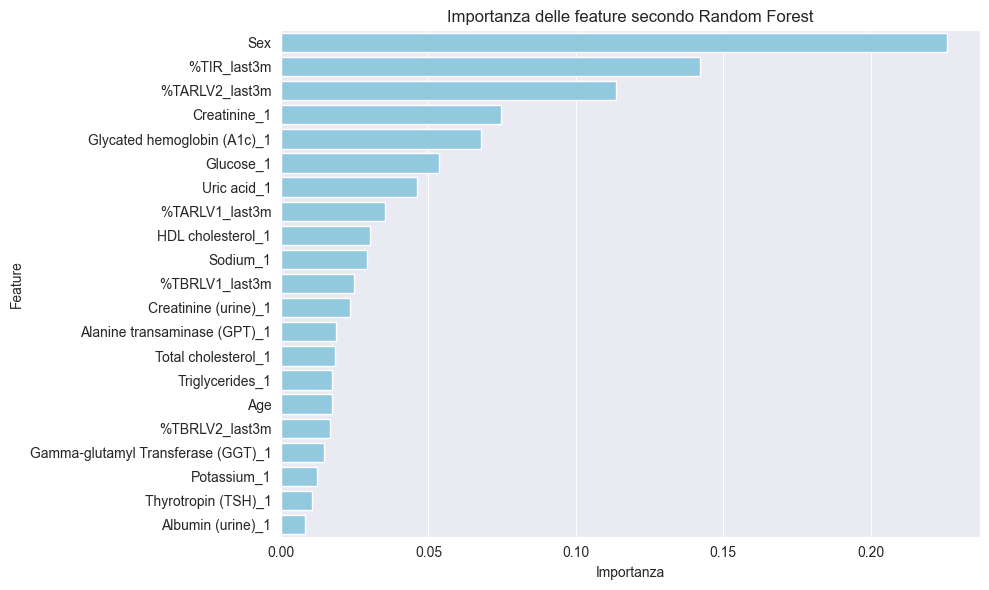


>>> Matrice di confusione:
col_0              0    1    2
Has_Diagnostics               
0                 88   63   74
1                151  162  185

>>> Metriche di valutazione del clustering GMM:
Silhouette Score: 0.0878
Davies-Bouldin Index: 2.5798
Calinski-Harabasz Index: 63.85
Adjusted Rand Index (ARI): 0.0028


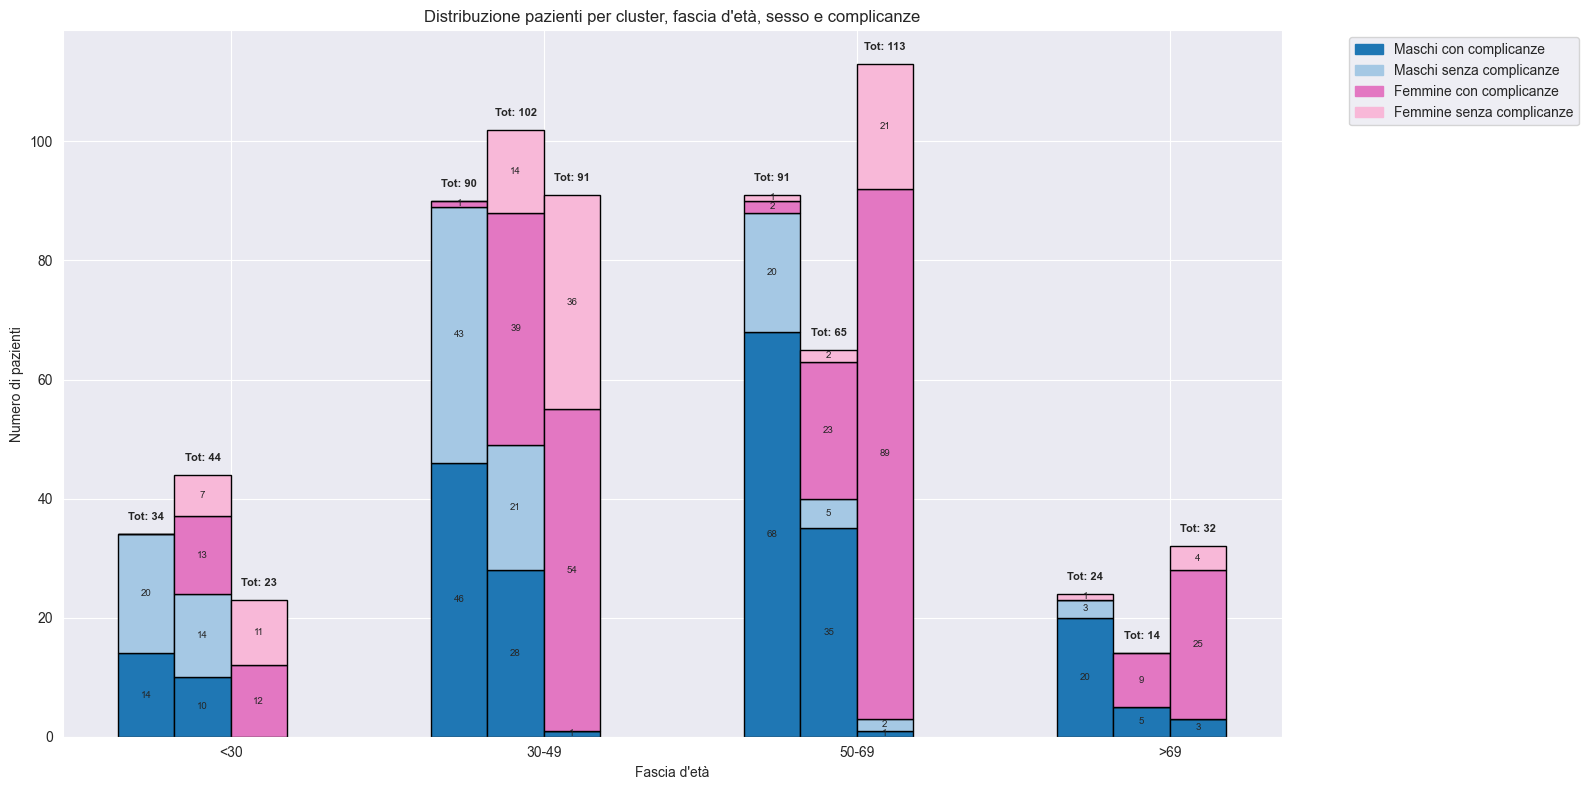

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\1566629560.py:199: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_tmp.groupby(['Cluster', f'{feature}_bin']).size().reset_index(name='Count')


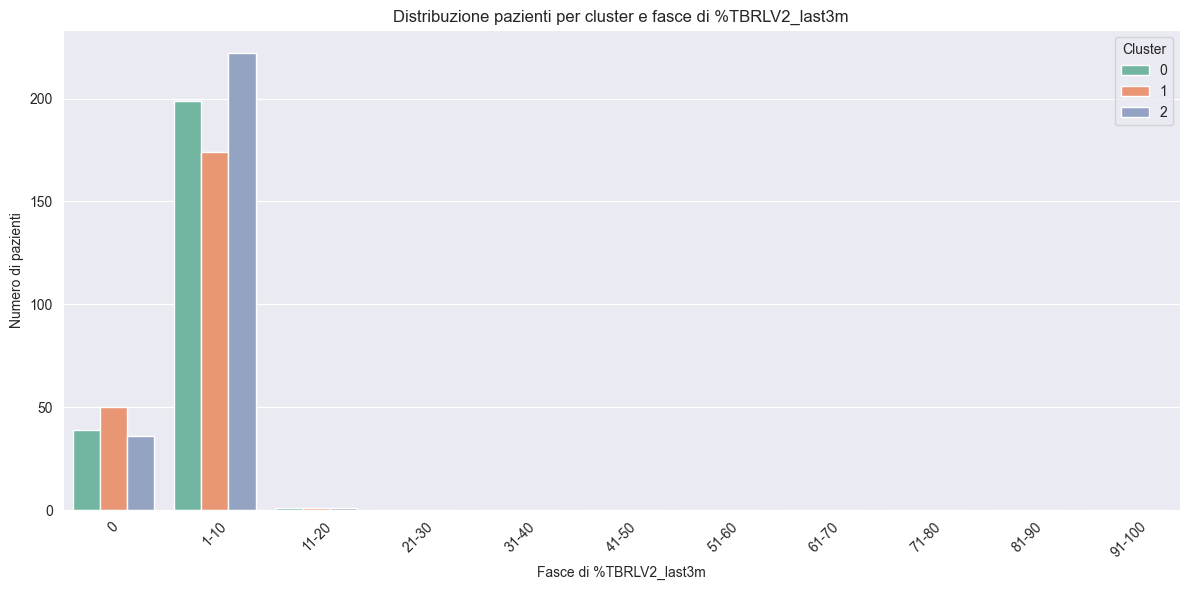

In [10]:
#KMEANS CON K=3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import f_oneway

# 1. Caricamento dei dati
df = pd.read_csv("Excel/Clustering.csv")
X = df.drop(columns=["Has_Diagnostics"])
y = df["Has_Diagnostics"]

# 2. Imputazione dei valori mancanti (media)
imputer = SimpleImputer(strategy="mean")
X_imp = imputer.fit_transform(X)

# 3. Standardizzazione
X_scaled = StandardScaler().fit_transform(X_imp)

# 4. KMeans clustering
kmeans = KMeans(
    n_clusters=3,
    init='random',
    n_init=10,
    max_iter=100,
    tol=0.001,
    algorithm='lloyd',
    random_state=42
)
clusters = kmeans.fit_predict(X_scaled)

# 5. Aggiunta cluster al DataFrame
df_tmp = df.copy()
df_tmp['Cluster'] = clusters

# 6. Analisi delle feature per cluster (media, std, ANOVA) Analysis of Variance per vedere se la media delle features e' significativamente diversa tra i due cluster
feature_names = X.columns
summary = []


#Per ogni feature del dataset viene calcolata la media e la deviazione standard nei due cluster e il valore p del test ANOVA
#Se p > 0.05 allora la differenza tra le media nei cluster non e' significativa, altrimenti  e' significativa
for i, feature in enumerate(feature_names):
    cluster_0 = X_scaled[clusters == 0, i]
    cluster_1 = X_scaled[clusters == 1, i]
    cluster_2 = X_scaled[clusters == 2, i]
    stat, p = f_oneway(cluster_0, cluster_1, cluster_2)
    summary.append({
        'Feature': feature,
        'Cluster0_Mean': np.mean(cluster_0),
        'Cluster1_Mean': np.mean(cluster_1),
        'Cluster2_Mean': np.mean(cluster_2),
        'Cluster0_Std': np.std(cluster_0),
        'Cluster1_Std': np.std(cluster_1),
        'Cluster2_Std': np.std(cluster_2),
        'ANOVA_p_value': p
    })

df_summary = pd.DataFrame(summary)
df_summary = df_summary.sort_values("ANOVA_p_value").reset_index(drop=True)
df_summary.index = df_summary.index + 1  # Indici da 1 a N

print("\n>>> Analisi ANOVA tra cluster (feature ordinati per significatività):")
print(df_summary.to_string())


# 7. Feature Importance con Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, clusters)
importances = rf.feature_importances_
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# 8. Plot delle feature più importanti
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, color='skyblue')

plt.title('Importanza delle feature secondo Random Forest')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix, classification_report

# Matrice di confusione
cm = pd.crosstab(y, clusters)
print("\n>>> Matrice di confusione:")
print(cm)

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

# Calcolo delle metriche di valutazione del clustering
sil_score = silhouette_score(X_scaled, clusters)
dbi = davies_bouldin_score(X_scaled, clusters)
chi = calinski_harabasz_score(X_scaled, clusters)
ari = adjusted_rand_score(y, clusters)

print("\n>>> Metriche di valutazione del clustering GMM:")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi:.4f}")
print(f"Calinski-Harabasz Index: {chi:.2f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")


def plot_cluster_demographics_3clusters(df_tmp):
    bins = [0, 29, 49, 69, np.inf]
    labels = ['<30', '30-49', '50-69', '>69']
    df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)

    cluster_data = []
    for cluster in range(3):  # 3 cluster
        cluster_df = df_tmp[df_tmp['Cluster'] == cluster]
        age_counts = []
        for age_group in labels:
            age_df = cluster_df[cluster_df['AgeGroup'] == age_group]
            male_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 1)])
            male_no_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 0)])
            female_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 1)])
            female_no_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 0)])
            age_counts.append({
                'Male_Dx': male_dx,
                'Male_NoDx': male_no_dx,
                'Female_Dx': female_dx,
                'Female_NoDx': female_no_dx,
                'Total': male_dx + male_no_dx + female_dx + female_no_dx
            })
        cluster_data.append(age_counts)

    fig, ax = plt.subplots(figsize=(16, 8))
    colors = {
        'Male_Dx': '#1f77b4',       # blu scuro
        'Male_NoDx': '#a5c8e4',     # blu chiaro
        'Female_Dx': '#e377c2',     # rosa scuro
        'Female_NoDx': '#f8b8d8'    # rosa chiaro
    }

    bar_width = 0.18  # più stretto per 4 cluster
    x = np.arange(len(labels))  # posizioni delle fasce d'età

    for i, cluster in enumerate(range(3)):
        positions = x + i * bar_width
        bottom = np.zeros(len(labels))
        for segment in ['Male_Dx', 'Male_NoDx', 'Female_Dx', 'Female_NoDx']:
            counts = [cluster_data[cluster][j][segment] for j in range(len(labels))]
            ax.bar(positions, counts, bar_width, bottom=bottom, color=colors[segment], edgecolor='black')
            # Testo con numero conteggiato sulle barre (solo se >0)
            for j, count in enumerate(counts):
                if count > 0:
                    ax.text(positions[j], bottom[j] + count/2, str(count), ha='center', va='center', fontsize=7)
            bottom += counts
        # Totali sopra ogni barra cluster/fascia
        for j in range(len(labels)):
            total = cluster_data[cluster][j]['Total']
            ax.text(positions[j], bottom[j] + 2, f'Tot: {total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

    ax.set_xticks(x + 1.5 * bar_width)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Fascia d\'età')
    ax.set_ylabel('Numero di pazienti')
    ax.set_title('Distribuzione pazienti per cluster, fascia d\'età, sesso e complicanze')

    # Legenda
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=colors['Male_Dx'], label='Maschi con complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Male_NoDx'], label='Maschi senza complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Female_Dx'], label='Femmine con complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Female_NoDx'], label='Femmine senza complicanze'),
    ]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Esegui la funzione con il dataframe aggiornato
plot_cluster_demographics_3clusters(df_tmp)



# Feature da analizzare
feature = '%TBRLV2_last3m'

# Definizione fasce per %TBRLV2_last3m
bins = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Crea la colonna con le fasce
df_tmp[f'{feature}_bin'] = pd.cut(df_tmp[feature], bins=bins, labels=labels, include_lowest=True, right=True)

# Conta i pazienti per cluster e fascia
counts = df_tmp.groupby(['Cluster', f'{feature}_bin']).size().reset_index(name='Count')
counts.rename(columns={f'{feature}_bin': 'Fascia'}, inplace=True)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=counts, x='Fascia', y='Count', hue='Cluster', palette='Set2', dodge=True)

plt.title('Distribuzione pazienti per cluster e fasce di %TBRLV2_last3m')
plt.xlabel('Fasce di %TBRLV2_last3m')
plt.ylabel('Numero di pazienti')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




>>> Analisi ANOVA tra cluster (feature ordinati per significatività):
                               Feature  Cluster0_Mean  Cluster1_Mean  Cluster2_Mean  Cluster3_Mean  Cluster0_Std  Cluster1_Std  Cluster2_Std  Cluster3_Std  ANOVA_p_value
1                       %TBRLV2_last3m      -0.254866      -0.195550       2.536287      -0.229047      0.355687      0.417231      1.806798      0.487007  4.500450e-132
2                                  Sex       0.892400      -0.920526       0.193361       0.075701      0.464722      0.374032      0.982490      0.997655  1.478441e-122
3                       %TBRLV1_last3m      -0.094324      -0.059287       2.189260      -0.492336      0.722822      0.778231      1.109144      0.515038   2.488551e-95
4                       %TARLV2_last3m      -0.415311      -0.390678      -0.358479       1.123355      0.513818      0.494350      0.641959      1.161683   5.024759e-92
5                          %TIR_last3m       0.446619       0.391184       0.12

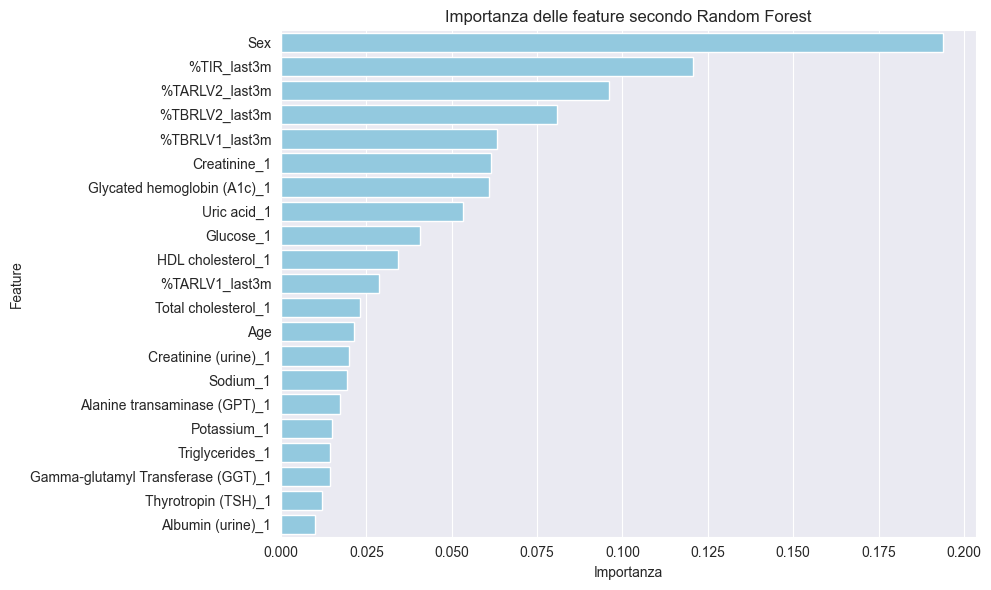


>>> Matrice di confusione:
col_0              0    1   2    3
Has_Diagnostics                   
0                 75   73  23   54
1                152  175  36  135

>>> Metriche di valutazione del clustering GMM:
Silhouette Score: 0.0855
Davies-Bouldin Index: 2.3561
Calinski-Harabasz Index: 56.85
Adjusted Rand Index (ARI): 0.0033


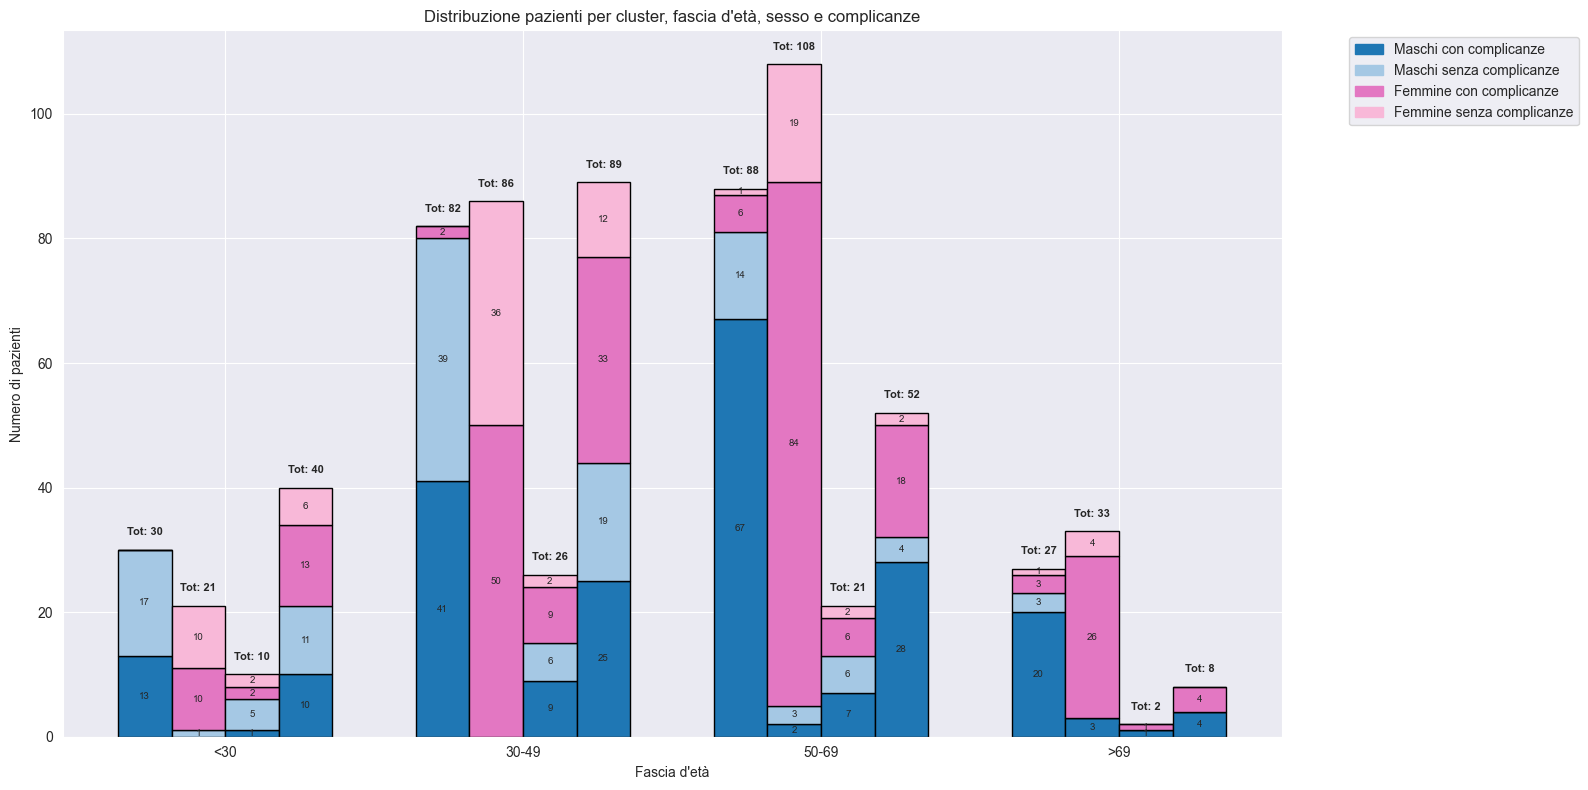

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\1236762570.py:202: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_tmp.groupby(['Cluster', f'{feature}_bin']).size().reset_index(name='Count')


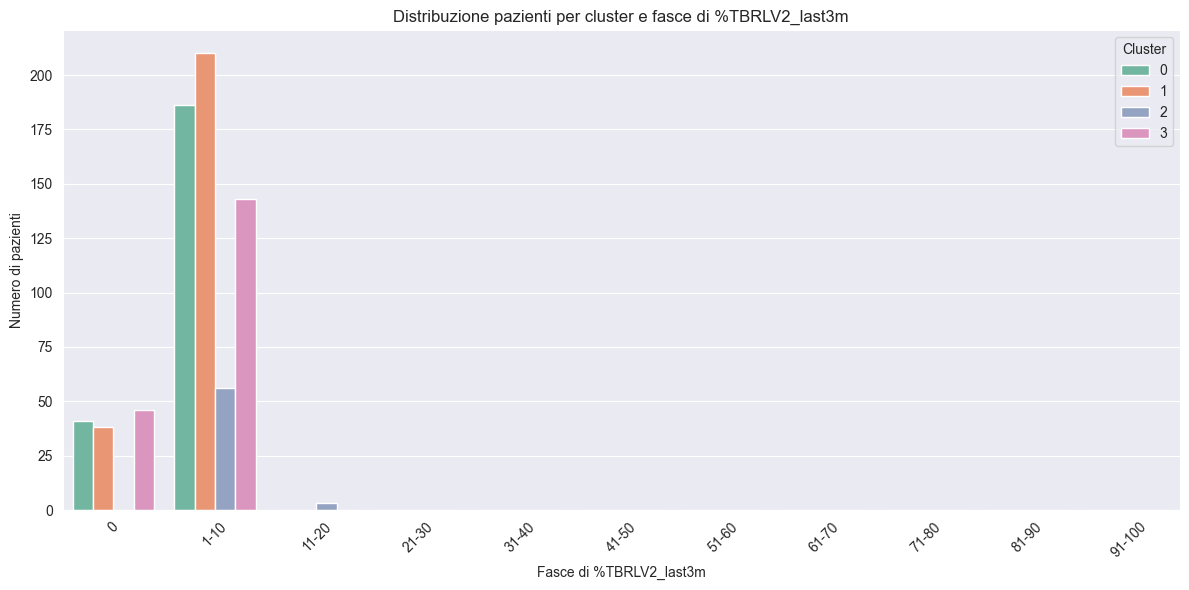

In [11]:
#KMEANS CON K=4

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import f_oneway

# 1. Caricamento dei dati
df = pd.read_csv("Excel/Clustering.csv")
X = df.drop(columns=["Has_Diagnostics"])
y = df["Has_Diagnostics"]

# 2. Imputazione dei valori mancanti (media)
imputer = SimpleImputer(strategy="mean")
X_imp = imputer.fit_transform(X)

# 3. Standardizzazione
X_scaled = StandardScaler().fit_transform(X_imp)

# 4. KMeans clustering
kmeans = KMeans(
    n_clusters=4,
    init='random',
    n_init=10,
    max_iter=100,
    tol=0.001,
    algorithm='lloyd',
    random_state=42
)
clusters = kmeans.fit_predict(X_scaled)

# 5. Aggiunta cluster al DataFrame
df_tmp = df.copy()
df_tmp['Cluster'] = clusters

# 6. Analisi delle feature per cluster (media, std, ANOVA) Analysis of Variance per vedere se la media delle features e' significativamente diversa tra i due cluster
feature_names = X.columns
summary = []


#Per ogni feature del dataset viene calcolata la media e la deviazione standard nei due cluster e il valore p del test ANOVA
#Se p > 0.05 allora la differenza tra le media nei cluster non e' significativa, altrimenti  e' significativa
for i, feature in enumerate(feature_names):
    cluster_0 = X_scaled[clusters == 0, i]
    cluster_1 = X_scaled[clusters == 1, i]
    cluster_2 = X_scaled[clusters == 2, i]
    cluster_3 = X_scaled[clusters == 3, i]
    stat, p = f_oneway(cluster_0, cluster_1, cluster_2, cluster_3)
    summary.append({
        'Feature': feature,
        'Cluster0_Mean': np.mean(cluster_0),
        'Cluster1_Mean': np.mean(cluster_1),
        'Cluster2_Mean': np.mean(cluster_2),
        'Cluster3_Mean': np.mean(cluster_3),
        'Cluster0_Std': np.std(cluster_0),
        'Cluster1_Std': np.std(cluster_1),
        'Cluster2_Std': np.std(cluster_2),
        'Cluster3_Std': np.std(cluster_3),
        'ANOVA_p_value': p
    })

df_summary = pd.DataFrame(summary)
df_summary = df_summary.sort_values("ANOVA_p_value").reset_index(drop=True)
df_summary.index = df_summary.index + 1  # Indici da 1 a N

print("\n>>> Analisi ANOVA tra cluster (feature ordinati per significatività):")
print(df_summary.to_string())


# 7. Feature Importance con Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, clusters)
importances = rf.feature_importances_
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# 8. Plot delle feature più importanti
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, color='skyblue')

plt.title('Importanza delle feature secondo Random Forest')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix, classification_report

# Matrice di confusione
cm = pd.crosstab(y, clusters)
print("\n>>> Matrice di confusione:")
print(cm)

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

# Calcolo delle metriche di valutazione del clustering
sil_score = silhouette_score(X_scaled, clusters)
dbi = davies_bouldin_score(X_scaled, clusters)
chi = calinski_harabasz_score(X_scaled, clusters)
ari = adjusted_rand_score(y, clusters)

print("\n>>> Metriche di valutazione del clustering GMM:")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi:.4f}")
print(f"Calinski-Harabasz Index: {chi:.2f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")


def plot_cluster_demographics_4clusters(df_tmp):
    bins = [0, 29, 49, 69, np.inf]
    labels = ['<30', '30-49', '50-69', '>69']
    df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)

    cluster_data = []
    for cluster in range(4):  # 4 cluster
        cluster_df = df_tmp[df_tmp['Cluster'] == cluster]
        age_counts = []
        for age_group in labels:
            age_df = cluster_df[cluster_df['AgeGroup'] == age_group]
            male_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 1)])
            male_no_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 0)])
            female_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 1)])
            female_no_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 0)])
            age_counts.append({
                'Male_Dx': male_dx,
                'Male_NoDx': male_no_dx,
                'Female_Dx': female_dx,
                'Female_NoDx': female_no_dx,
                'Total': male_dx + male_no_dx + female_dx + female_no_dx
            })
        cluster_data.append(age_counts)

    fig, ax = plt.subplots(figsize=(16, 8))
    colors = {
        'Male_Dx': '#1f77b4',       # blu scuro
        'Male_NoDx': '#a5c8e4',     # blu chiaro
        'Female_Dx': '#e377c2',     # rosa scuro
        'Female_NoDx': '#f8b8d8'    # rosa chiaro
    }

    bar_width = 0.18  # più stretto per 4 cluster
    x = np.arange(len(labels))  # posizioni delle fasce d'età

    for i, cluster in enumerate(range(4)):
        positions = x + i * bar_width
        bottom = np.zeros(len(labels))
        for segment in ['Male_Dx', 'Male_NoDx', 'Female_Dx', 'Female_NoDx']:
            counts = [cluster_data[cluster][j][segment] for j in range(len(labels))]
            ax.bar(positions, counts, bar_width, bottom=bottom, color=colors[segment], edgecolor='black')
            # Testo con numero conteggiato sulle barre (solo se >0)
            for j, count in enumerate(counts):
                if count > 0:
                    ax.text(positions[j], bottom[j] + count/2, str(count), ha='center', va='center', fontsize=7)
            bottom += counts
        # Totali sopra ogni barra cluster/fascia
        for j in range(len(labels)):
            total = cluster_data[cluster][j]['Total']
            ax.text(positions[j], bottom[j] + 2, f'Tot: {total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

    ax.set_xticks(x + 1.5 * bar_width)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Fascia d\'età')
    ax.set_ylabel('Numero di pazienti')
    ax.set_title('Distribuzione pazienti per cluster, fascia d\'età, sesso e complicanze')

    # Legenda
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=colors['Male_Dx'], label='Maschi con complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Male_NoDx'], label='Maschi senza complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Female_Dx'], label='Femmine con complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Female_NoDx'], label='Femmine senza complicanze'),
    ]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Esegui la funzione con il dataframe aggiornato
plot_cluster_demographics_4clusters(df_tmp)



# Feature da analizzare
feature = '%TBRLV2_last3m'

# Definizione fasce per %TBRLV2_last3m
bins = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Crea la colonna con le fasce
df_tmp[f'{feature}_bin'] = pd.cut(df_tmp[feature], bins=bins, labels=labels, include_lowest=True, right=True)

# Conta i pazienti per cluster e fascia
counts = df_tmp.groupby(['Cluster', f'{feature}_bin']).size().reset_index(name='Count')
counts.rename(columns={f'{feature}_bin': 'Fascia'}, inplace=True)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=counts, x='Fascia', y='Count', hue='Cluster', palette='Set2', dodge=True)

plt.title('Distribuzione pazienti per cluster e fasce di %TBRLV2_last3m')
plt.xlabel('Fasce di %TBRLV2_last3m')
plt.ylabel('Numero di pazienti')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




>>> Analisi ANOVA tra cluster (feature ordinati per significatività):
                       Feature  Cluster0_Mean  Cluster1_Mean  Cluster0_Std  Cluster1_Std  ANOVA_p_value
1                  %TIR_last3m       0.695557      -0.774874      0.639715      0.720232  2.405855e-123
2               %TARLV2_last3m      -0.609489       0.678992      0.365738      1.044102   1.081401e-85
3               %TARLV1_last3m      -0.604709       0.673667      0.795277      0.740437   5.686152e-84
4  Glycated hemoglobin (A1c)_1      -0.500340       0.557396      0.613121      1.051509   3.620127e-53
5               %TBRLV1_last3m       0.380246      -0.423607      1.148546      0.551297   2.335735e-29
6               %TBRLV2_last3m       0.166926      -0.185962      1.212471      0.640846   1.873894e-06


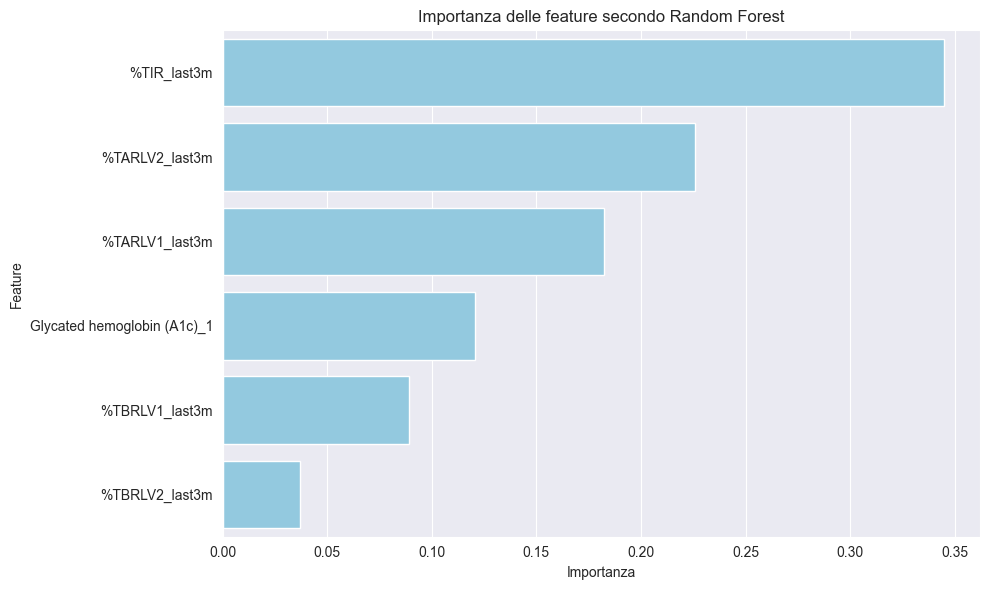

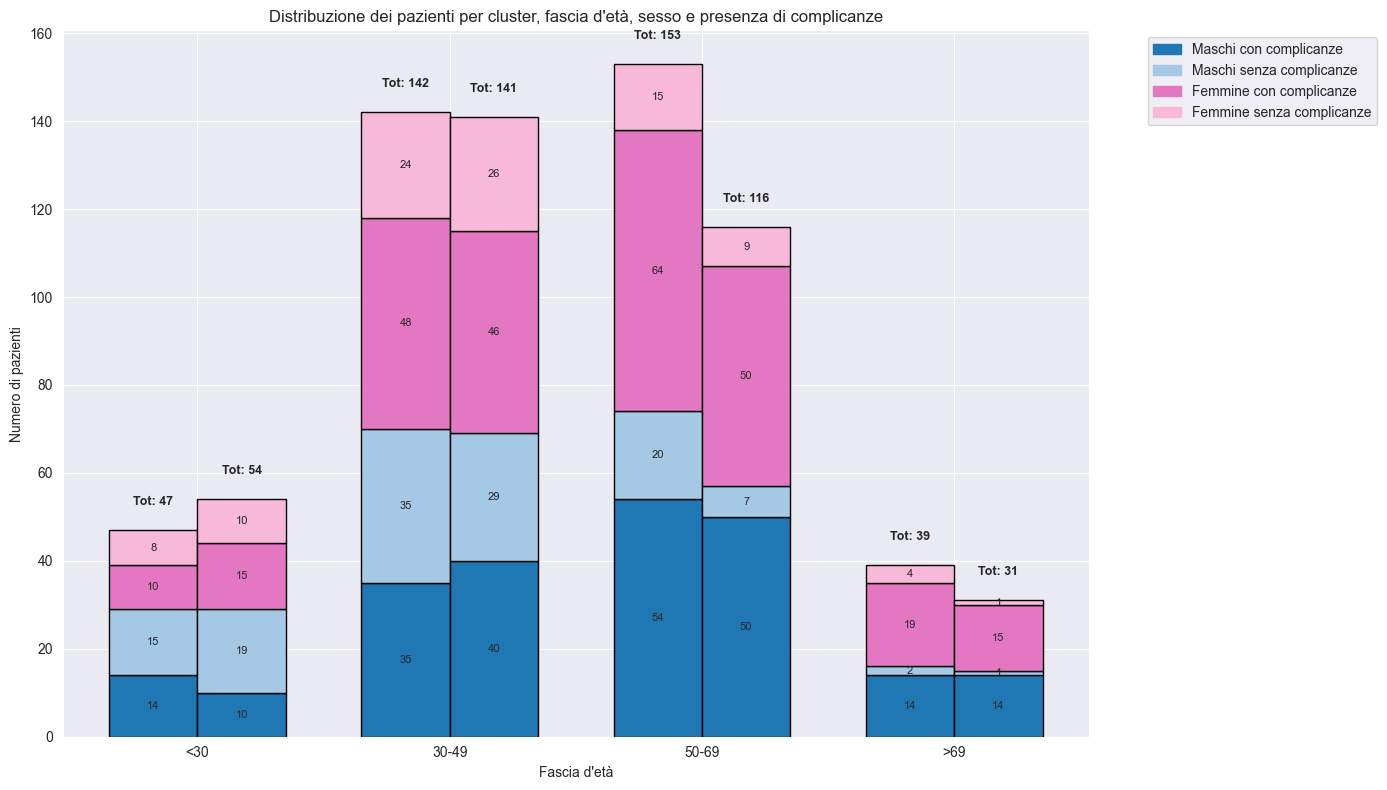

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\208793159.py:191: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_tmp.groupby(['Cluster', f'{feature}_bin']).size().reset_index(name='Count')


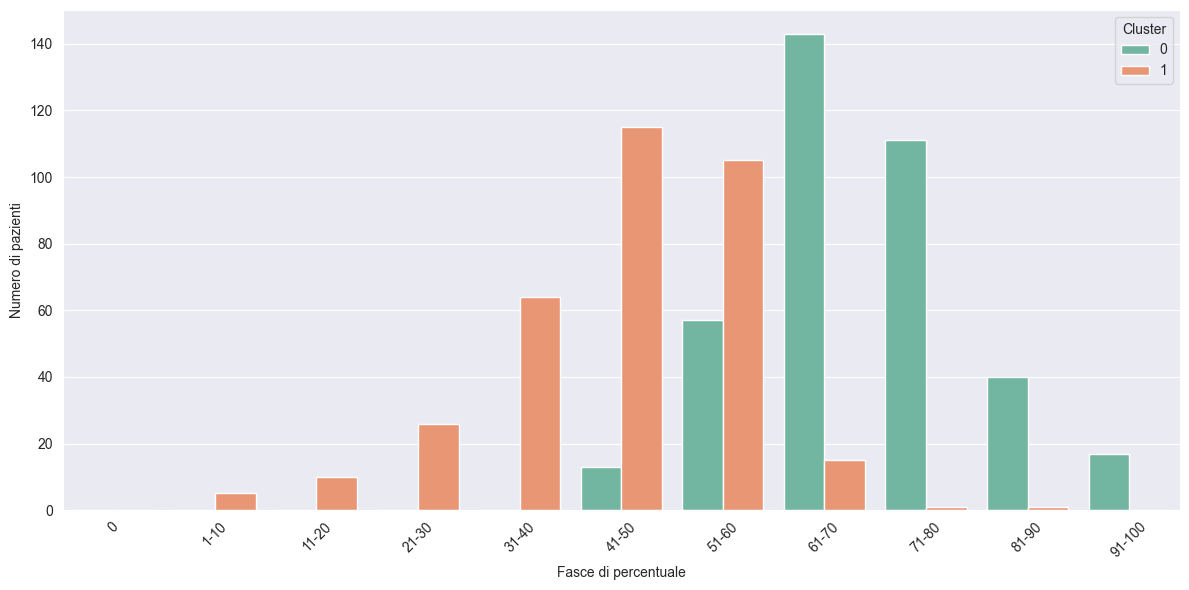

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\208793159.py:191: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_tmp.groupby(['Cluster', f'{feature}_bin']).size().reset_index(name='Count')


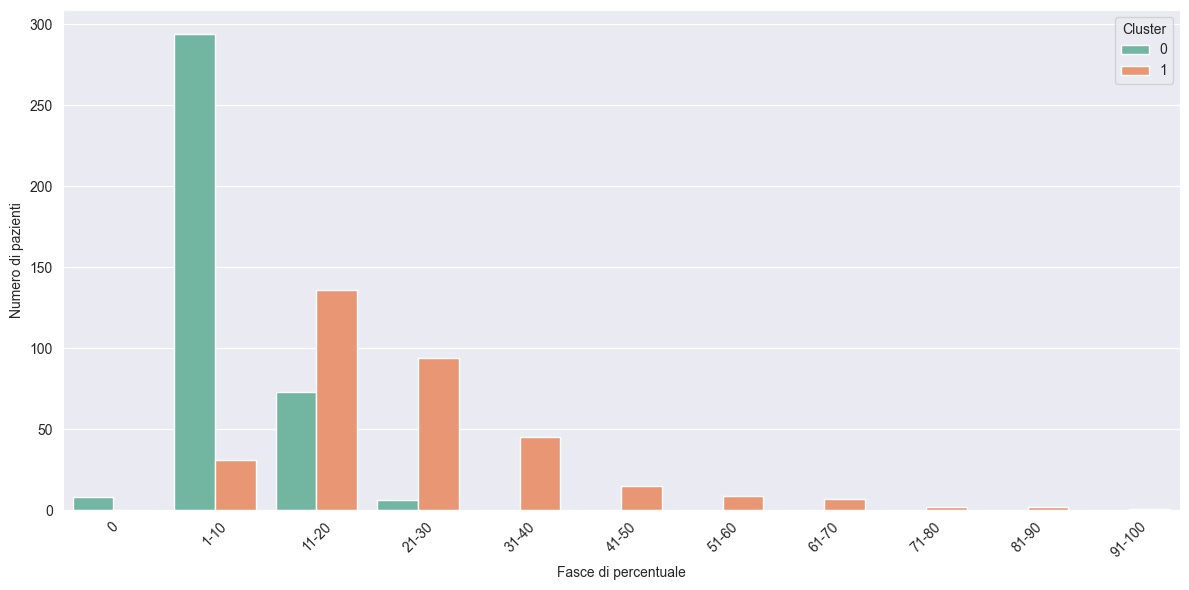

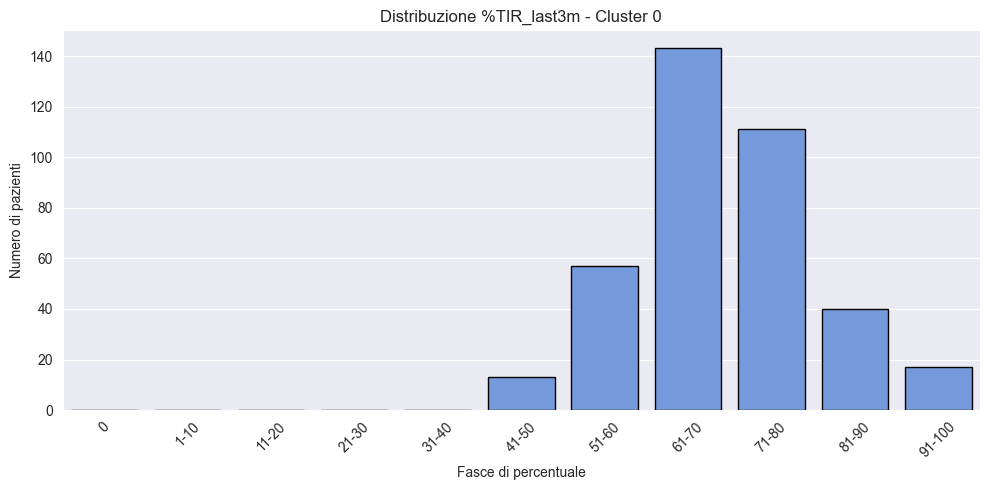

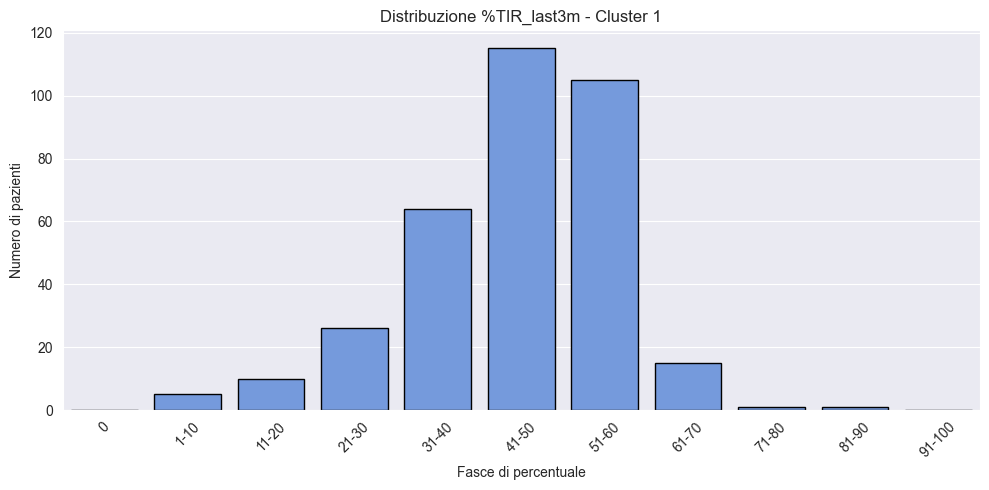

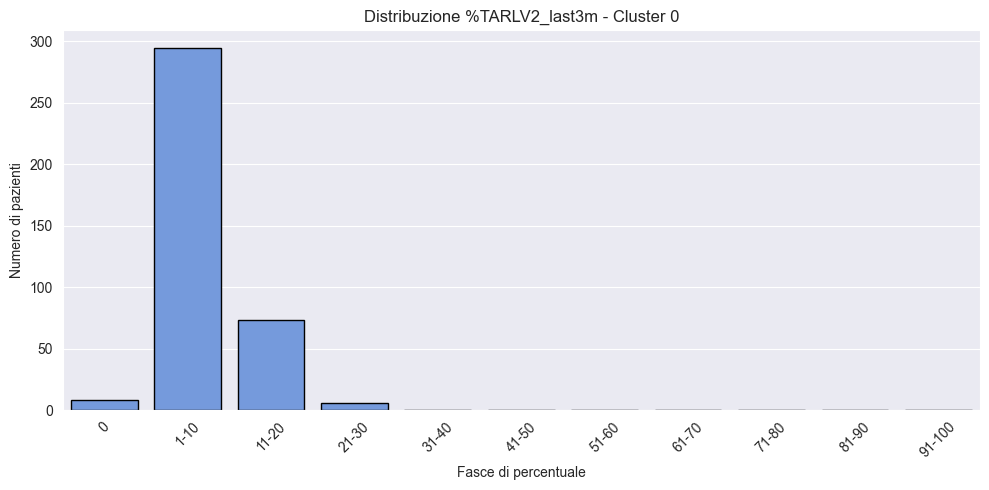

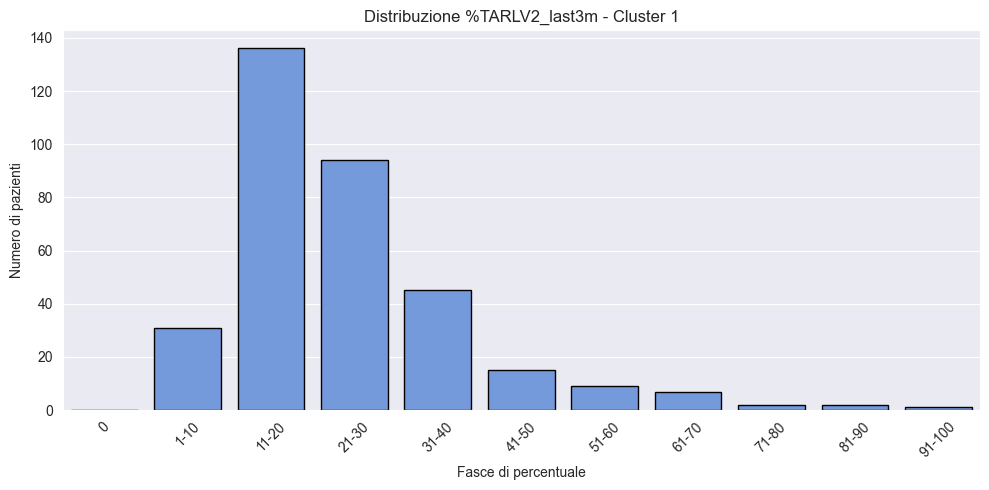

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\208793159.py:251: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a1c_counts = df_tmp.groupby(['Cluster', 'A1c_bin']).size().reset_index(name='Count')


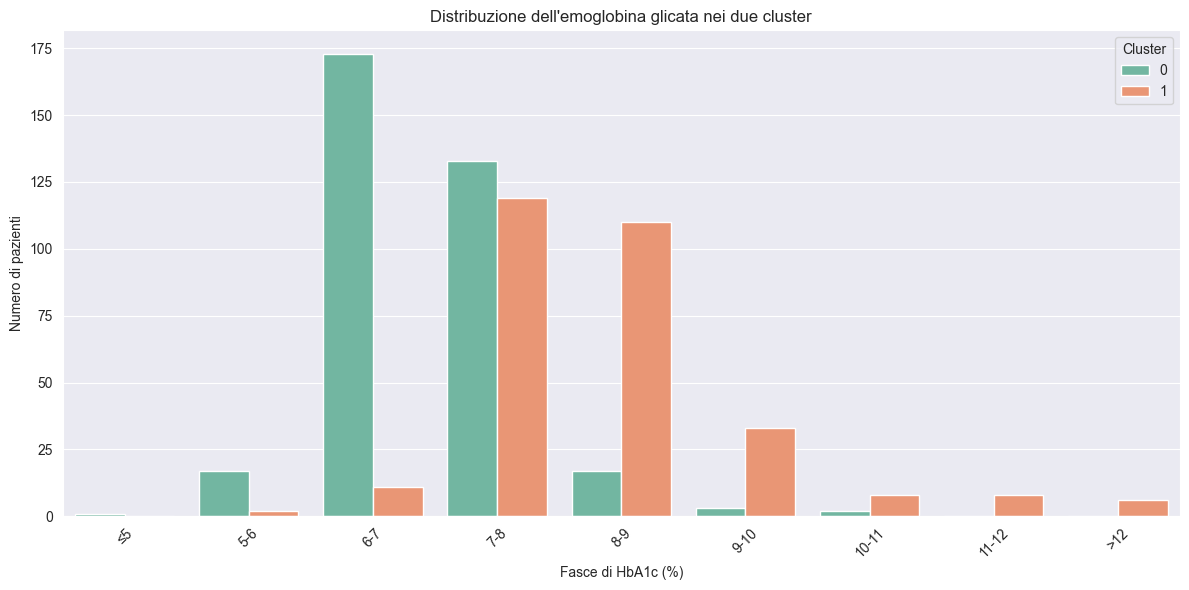


>>> Metriche di valutazione del clustering KMeans:
Silhouette Score: 0.2984
Davies-Bouldin Index: 1.2731
Calinski-Harabasz Index: 316.70
Adjusted Rand Index (ARI): -0.0016

>>> Matrice di confusione (etichetta: Has_Diagnostics vs Cluster_GMM):
[[123 102]
 [258 240]]


In [13]:
#CLUSTERING USANDO KMEANS CON K=2, PERO USANDO COME INFORMAZIONI DA DARE ALL'ALGORITMO SOLO LE INFORMAZIONI RELATIVE AL GLUCOSIO:
    # '%TIR_last3m',
    # '%TARLV1_last3m',
    # '%TARLV2_last3m',
    # '%TBRLV1_last3m',
    # '%TBRLV2_last3m',
    # 'Glycated hemoglobin (A1c)_1'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import f_oneway

# 1. Caricamento dei dati
df = pd.read_csv("Excel/Clustering.csv")
y = df["Has_Diagnostics"]

# Selezione feature per il clustering
selected_features = [
    '%TIR_last3m',
    '%TARLV1_last3m',
    '%TARLV2_last3m',
    '%TBRLV1_last3m',
    '%TBRLV2_last3m',
    'Glycated hemoglobin (A1c)_1'
]
X = df[selected_features]


# 2. Imputazione dei valori mancanti (media)
imputer = SimpleImputer(strategy="mean")
X_imp = imputer.fit_transform(X)

# 3. Standardizzazione
X_scaled = StandardScaler().fit_transform(X_imp)

# 4. KMeans clustering
kmeans = KMeans(
    n_clusters=2,
    init='random',
    n_init=10,
    max_iter=100,
    tol=0.001,
    algorithm='lloyd',
    random_state=42
)
clusters = kmeans.fit_predict(X_scaled)

# 5. Aggiunta cluster al DataFrame
df_tmp = df.copy()
df_tmp['Cluster'] = clusters

# 6. Analisi delle feature per cluster (media, std, ANOVA) Analysis of Variance per vedere se la media delle features e' significativamente diversa tra i due cluster
feature_names = X.columns
summary = []


#Per ogni feature del dataset viene calcolata la media e la deviazione standard nei due cluster e il valore p del test ANOVA
#Se p > 0.05 allora la differenza tra le media nei due cluster non e' significativa, altrimenti  e' significativa
for i, feature in enumerate(feature_names):
    cluster_0 = X_scaled[clusters == 0, i]
    cluster_1 = X_scaled[clusters == 1, i]
    stat, p = f_oneway(cluster_0, cluster_1)
    summary.append({
        'Feature': feature,
        'Cluster0_Mean': np.mean(cluster_0),
        'Cluster1_Mean': np.mean(cluster_1),
        'Cluster0_Std': np.std(cluster_0),
        'Cluster1_Std': np.std(cluster_1),
        'ANOVA_p_value': p
    })

df_summary = pd.DataFrame(summary)
df_summary = df_summary.sort_values("ANOVA_p_value").reset_index(drop=True)
df_summary.index = df_summary.index + 1  # Indici da 1 a N

print("\n>>> Analisi ANOVA tra cluster (feature ordinati per significatività):")
print(df_summary.to_string())


# 7. Feature Importance con Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, clusters)
importances = rf.feature_importances_
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# 8. Plot delle feature più importanti
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, color='skyblue')

plt.title('Importanza delle feature secondo Random Forest')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 9. Funzione per il grafico demografico
def plot_cluster_demographics(df_tmp):
    bins = [0, 29, 49, 69, np.inf]
    labels = ['<30', '30-49', '50-69', '>69']
    df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)

    cluster_data = []
    for cluster in [0, 1]:
        cluster_df = df_tmp[df_tmp['Cluster'] == cluster]
        age_counts = []
        for age_group in labels:
            age_df = cluster_df[cluster_df['AgeGroup'] == age_group]
            male_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 1)])
            male_no_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 0)])
            female_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 1)])
            female_no_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 0)])
            age_counts.append({
                'Male_Dx': male_dx,
                'Male_NoDx': male_no_dx,
                'Female_Dx': female_dx,
                'Female_NoDx': female_no_dx,
                'Total': male_dx + male_no_dx + female_dx + female_no_dx
            })
        cluster_data.append(age_counts)

    fig, ax = plt.subplots(figsize=(14, 8))
    colors = {
        'Male_Dx': '#1f77b4',
        'Male_NoDx': '#a5c8e4',
        'Female_Dx': '#e377c2',
        'Female_NoDx': '#f8b8d8'
    }

    bar_width = 0.35
    x = np.arange(len(labels))
    for i, cluster in enumerate([0, 1]):
        positions = x + i * bar_width
        bottom = np.zeros(len(labels))
        for segment in ['Male_Dx', 'Male_NoDx', 'Female_Dx', 'Female_NoDx']:
            counts = [cluster_data[cluster][j][segment] for j in range(len(labels))]
            ax.bar(positions, counts, bar_width, bottom=bottom, color=colors[segment], edgecolor='black')
            for j, count in enumerate(counts):
                if count > 0:
                    ax.text(positions[j], bottom[j] + count/2, str(count), ha='center', va='center', fontsize=8)
            bottom += counts
        for j in range(len(labels)):
            total = cluster_data[cluster][j]['Total']
            ax.text(positions[j], bottom[j] + 5, f'Tot: {total}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Fascia d\'età')
    ax.set_ylabel('Numero di pazienti')
    ax.set_title('Distribuzione dei pazienti per cluster, fascia d\'età, sesso e presenza di complicanze')

    handles = [
        plt.Rectangle((0, 0), 1, 1, color=colors['Male_Dx'], label='Maschi con complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Male_NoDx'], label='Maschi senza complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Female_Dx'], label='Femmine con complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Female_NoDx'], label='Femmine senza complicanze'),
    ]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# 10. Mostra il grafico demografico
plot_cluster_demographics(df_tmp)


# 11. Istogrammi separati per %TIR_last3m e %TARLV2_last3m


# 2 ISTOGRAMMI
# Colonne target
features = ['%TIR_last3m', '%TARLV2_last3m']

# Definizione fasce
bins = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

for feature in features:
    # Crea la colonna con le fasce
    df_tmp[f'{feature}_bin'] = pd.cut(df_tmp[feature], bins=bins, labels=labels, include_lowest=True, right=True)

    # Conta i pazienti per cluster e fascia
    counts = df_tmp.groupby(['Cluster', f'{feature}_bin']).size().reset_index(name='Count')
    counts.rename(columns={f'{feature}_bin': 'Fascia'}, inplace=True)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=counts, x='Fascia', y='Count', hue='Cluster', palette='Set2', dodge=True)

    plt.title('')
    plt.xlabel('Fasce di percentuale')
    plt.ylabel('Numero di pazienti')
    plt.legend(title='Cluster')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



# 4 ISTOGRAMMI
# Colonne target
features = ['%TIR_last3m', '%TARLV2_last3m']

# Definizione fasce
bins = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Crea le colonne binned per ogni feature
for feature in features:
    df_tmp[f'{feature}_bin'] = pd.cut(df_tmp[feature], bins=bins, labels=labels, include_lowest=True, right=True)

# Per ogni combinazione di feature e cluster, plottiamo un istogramma
for feature in features:
    for cluster in [0, 1]:
        # Filtra solo i dati del cluster corrente
        cluster_df = df_tmp[df_tmp['Cluster'] == cluster]

        # Conta i pazienti nelle fasce
        counts = cluster_df[f'{feature}_bin'].value_counts().sort_index()

        # Plot
        plt.figure(figsize=(10, 5))
        sns.barplot(x=counts.index, y=counts.values, color='cornflowerblue', edgecolor='black')

        plt.title(f'Distribuzione {feature} - Cluster {cluster}')
        plt.xlabel('Fasce di percentuale')
        plt.ylabel('Numero di pazienti')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


a1c_col = 'Glycated hemoglobin (A1c)_1'

# Definizione dei bin per l'emoglobina glicata
bins_a1c = [0, 5, 6, 7, 8, 9, 10, 11, 12, np.inf]
labels_a1c = ['≤5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11', '11-12', '>12']

# Crea la colonna binned
df_tmp['A1c_bin'] = pd.cut(df_tmp[a1c_col], bins=bins_a1c, labels=labels_a1c, include_lowest=True, right=False)

# Conta i pazienti per cluster e fascia
a1c_counts = df_tmp.groupby(['Cluster', 'A1c_bin']).size().reset_index(name='Count')

# Plot istogramma a due colonne
plt.figure(figsize=(12, 6))
sns.barplot(data=a1c_counts, x='A1c_bin', y='Count', hue='Cluster', palette='Set2', dodge=True)

plt.title('Distribuzione dell\'emoglobina glicata nei due cluster')
plt.xlabel('Fasce di HbA1c (%)')
plt.ylabel('Numero di pazienti')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, confusion_matrix

# Calcolo delle metriche di valutazione del clustering
sil_score = silhouette_score(X_scaled, clusters)
dbi = davies_bouldin_score(X_scaled, clusters)
chi = calinski_harabasz_score(X_scaled, clusters)
ari = adjusted_rand_score(y, clusters)  # già calcolato, ma lo ricalcoliamo qui per coerenza

print("\n>>> Metriche di valutazione del clustering KMeans:")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi:.4f}")
print(f"Calinski-Harabasz Index: {chi:.2f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

cm = confusion_matrix(y, clusters)
print("\n>>> Matrice di confusione (etichetta: Has_Diagnostics vs Cluster_GMM):")
print(cm)


>>> Analisi ANOVA tra cluster GMM:
                               Feature  Cluster0_Mean  Cluster1_Mean  Cluster0_Std  Cluster1_Std  ANOVA_p_value
1                       %TARLV2_last3m      -0.186483       0.656189      0.678863      1.531067   3.082167e-22
2          Glycated hemoglobin (A1c)_1      -0.169471       0.596325      0.733812      1.472178   1.929088e-18
3                      Triglycerides_1      -0.169073       0.594927      0.486193      1.797902   2.337418e-18
4   Gamma-glutamyl Transferase (GGT)_1      -0.156190       0.549595      0.151234      2.012554   8.872522e-16
5                            Glucose_1      -0.125331       0.441008      0.882332      1.236774   1.548685e-10
6                          %TIR_last3m       0.125318      -0.440962      0.846379      1.322255   1.555704e-10
7         Alanine transaminase (GPT)_1      -0.122710       0.431788      0.374243      1.945892   3.778091e-10
8                       %TBRLV1_last3m       0.117663      -0.414026

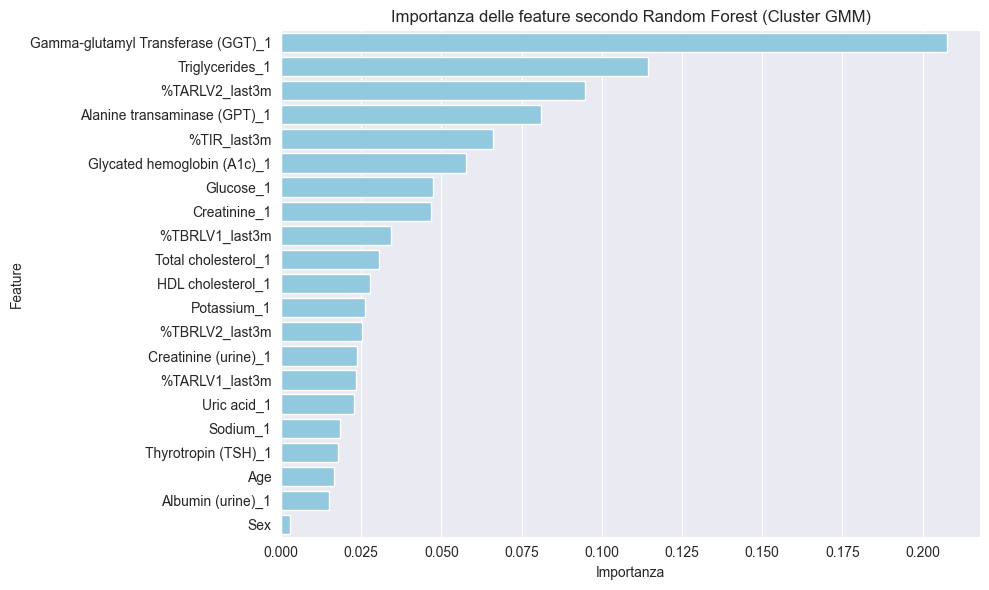

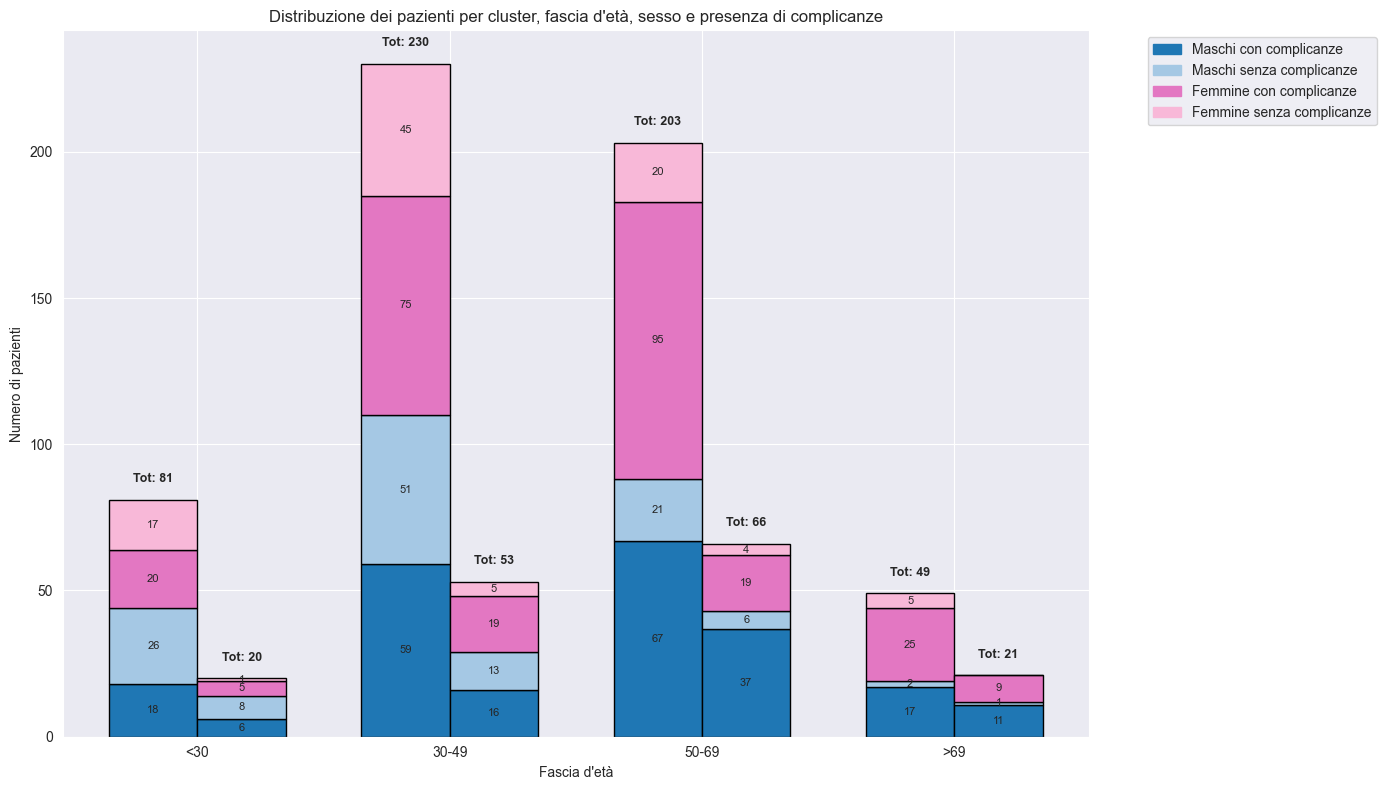

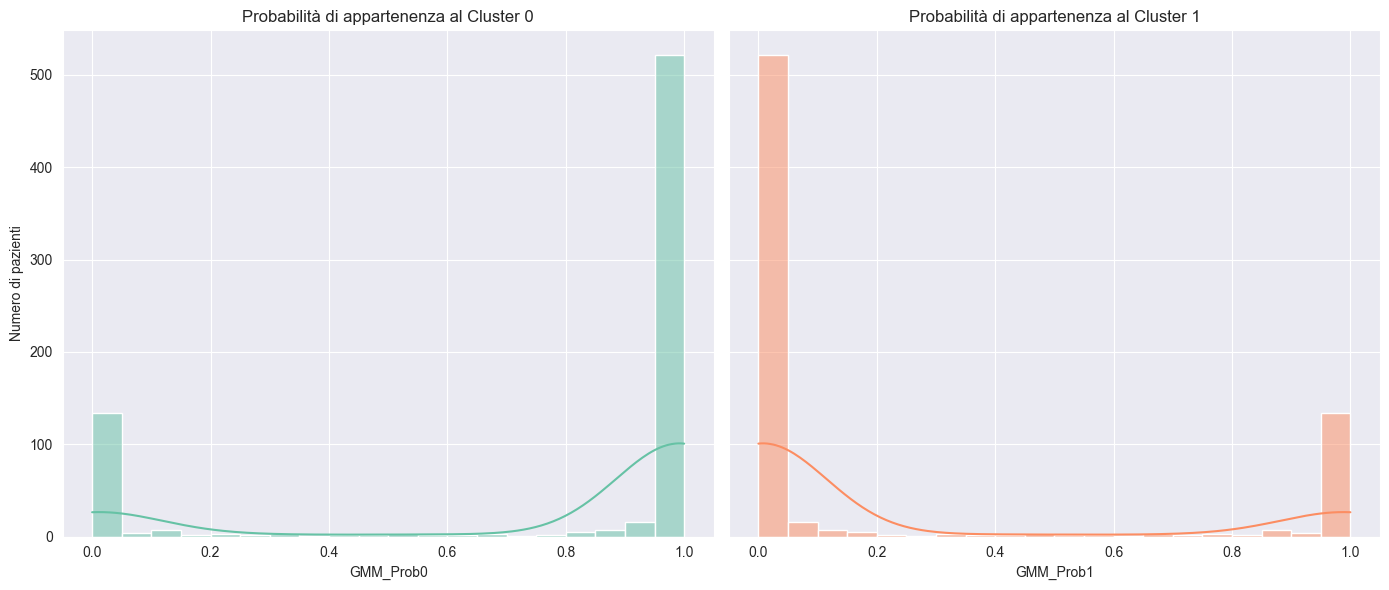

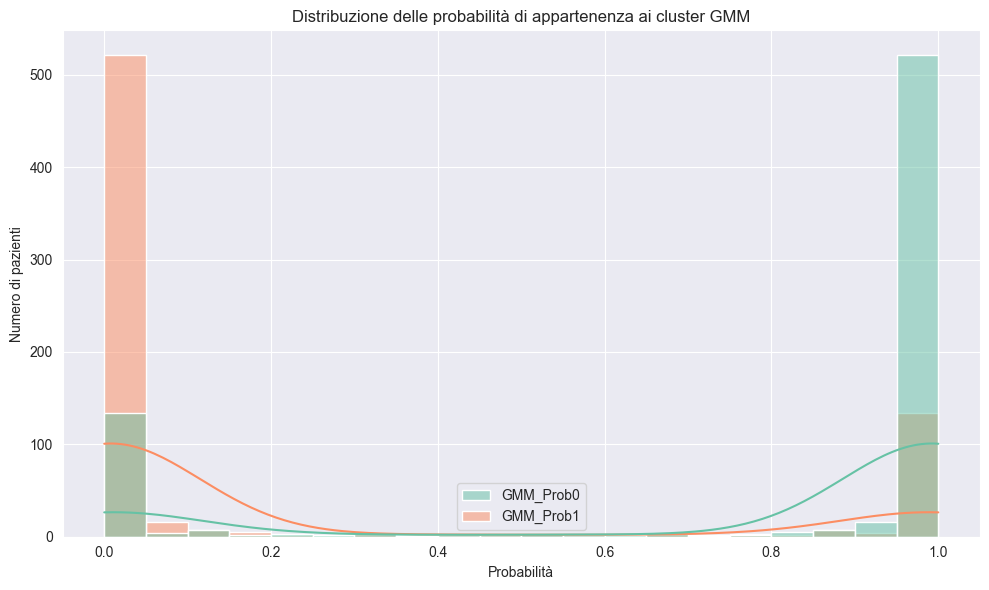


>>> Pazienti borderline (probabilità ∈ [0.4, 0.6]): 9 su 723

>>> Esempi di pazienti borderline:
 Sex  Age  Has_Diagnostics  %TIR_last3m  %TARLV1_last3m  %TARLV2_last3m  %TBRLV1_last3m  %TBRLV2_last3m  Alanine transaminase (GPT)_1  Albumin (urine)_1  Creatinine (urine)_1  Creatinine_1  Gamma-glutamyl Transferase (GGT)_1  Glucose_1  Glycated hemoglobin (A1c)_1  HDL cholesterol_1  Potassium_1  Sodium_1  Thyrotropin (TSH)_1  Total cholesterol_1  Triglycerides_1  Uric acid_1  Cluster_GMM  GMM_Prob0  GMM_Prob1 AgeGroup  Borderline
   1   61                1    68.443649       24.054860        5.283244        2.206321        0.011926                          19.0               0.99                 99.47          0.80                                43.0      117.0                          6.6               52.0         5.62     138.0                0.917                182.0             92.0          4.3            1   0.412005   0.587995    50-69        True
   1   58                1    41

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\2160450380.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_tmp.groupby(['Cluster_GMM', f'{feature}_bin']).size().reset_index(name='Count')


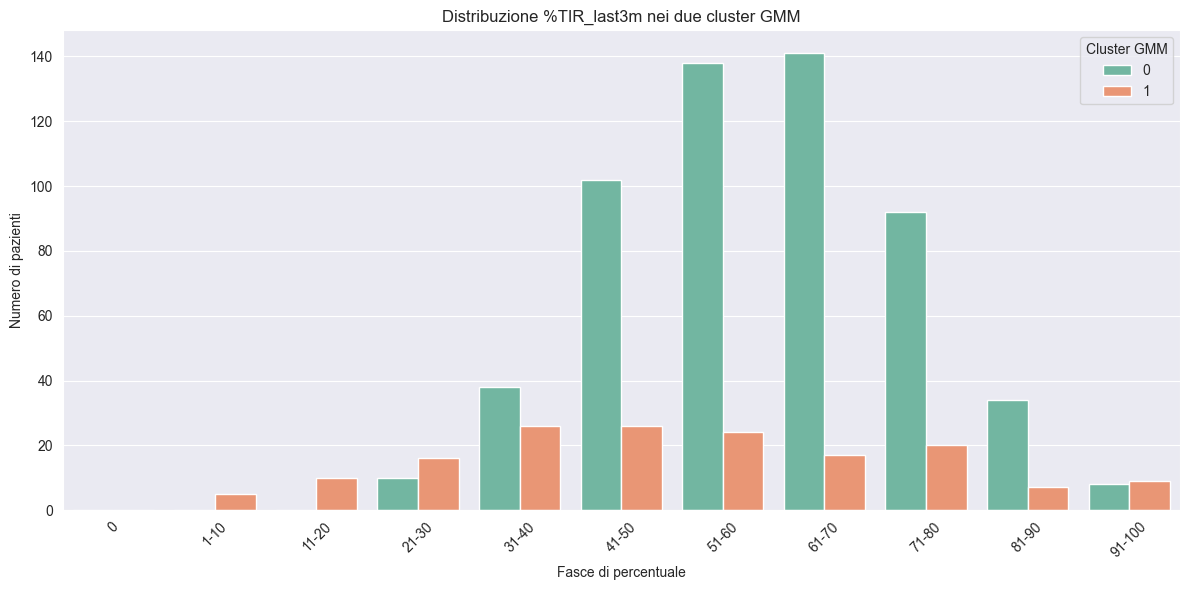

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\2160450380.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_tmp.groupby(['Cluster_GMM', f'{feature}_bin']).size().reset_index(name='Count')


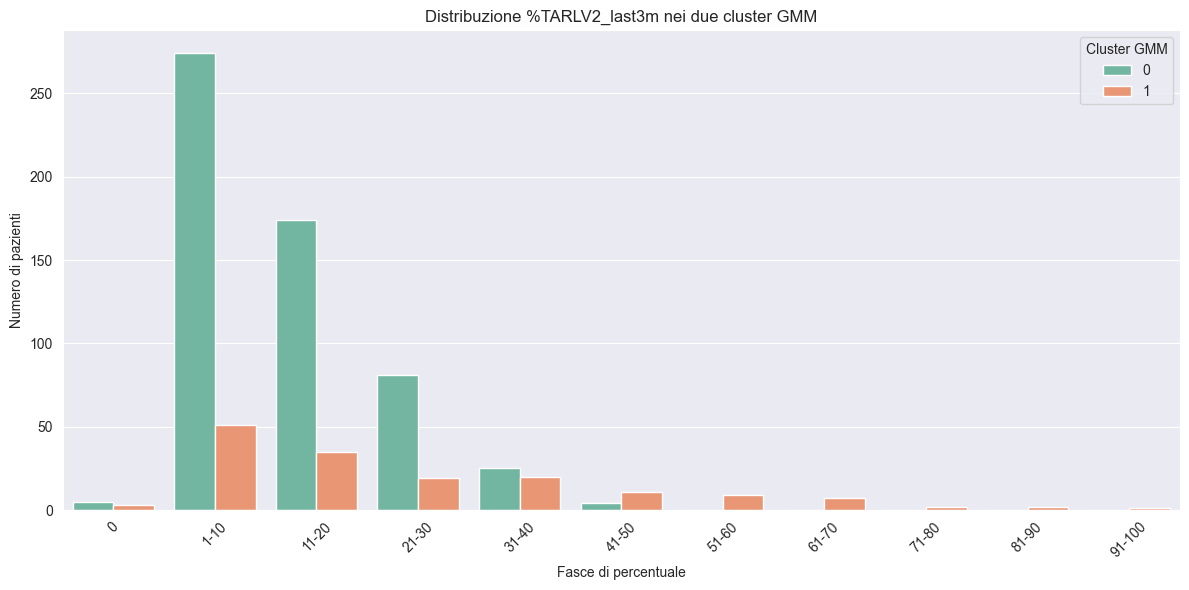

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\2160450380.py:239: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a1c_counts = df_tmp.groupby(['Cluster_GMM', 'A1c_bin']).size().reset_index(name='Count')


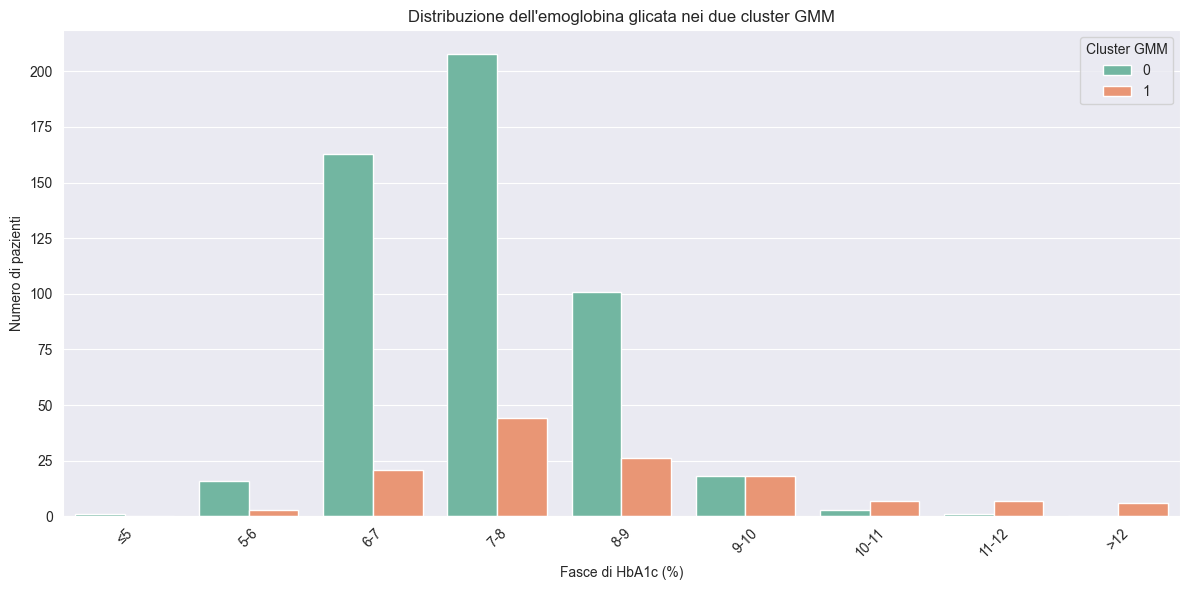


>>> Media di Has_Diagnostics per cluster GMM:
Cluster_GMM
0    0.667851
1    0.762500
Name: Has_Diagnostics, dtype: float64

>>> Matrice di confusione (etichetta: Has_Diagnostics vs Cluster_GMM):
[[187  38]
 [376 122]]

>>> Metriche di valutazione del clustering GMM:
Silhouette Score: 0.1394
Davies-Bouldin Index: 4.0453
Calinski-Harabasz Index: 29.29
Adjusted Rand Index (ARI): -0.0252


In [15]:
#CLUSTERING CON GAUSSIAN MIXTURE MODELS, USANDO COME METODO DI IMPUTAZIONE LA MEDIA, CHE NEL KMEANS E' RISULTATO IL METODO MIGLIORE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import f_oneway
from sklearn.metrics import adjusted_rand_score

# 1. Caricamento dei dati
df = pd.read_csv("Excel/Clustering.csv")
X = df.drop(columns=["Has_Diagnostics"])
y = df["Has_Diagnostics"]

# 2. Imputazione dei valori mancanti (media)
imputer = SimpleImputer(strategy="mean")
X_imp = imputer.fit_transform(X)

# 3. Standardizzazione
X_scaled = StandardScaler().fit_transform(X_imp)

# 4. GMM clustering
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_scaled)
clusters = gmm.predict(X_scaled)
probs = gmm.predict_proba(X_scaled)  # probabilità di appartenenza

# 5. Aggiunta cluster e probabilità al DataFrame
df_tmp = df.copy()
df_tmp['Cluster_GMM'] = clusters
df_tmp['GMM_Prob0'] = probs[:, 0]
df_tmp['GMM_Prob1'] = probs[:, 1]

# 6. Analisi ANOVA tra i due cluster
feature_names = X.columns
summary = []

for i, feature in enumerate(feature_names):
    cluster_0 = X_scaled[clusters == 0, i]
    cluster_1 = X_scaled[clusters == 1, i]
    stat, p = f_oneway(cluster_0, cluster_1)
    summary.append({
        'Feature': feature,
        'Cluster0_Mean': np.mean(cluster_0),
        'Cluster1_Mean': np.mean(cluster_1),
        'Cluster0_Std': np.std(cluster_0),
        'Cluster1_Std': np.std(cluster_1),
        'ANOVA_p_value': p
    })

df_summary = pd.DataFrame(summary).sort_values("ANOVA_p_value").reset_index(drop=True)
df_summary.index += 1

print("\n>>> Analisi ANOVA tra cluster GMM:")
print(df_summary.to_string())

# 7. Feature Importance con Random Forest (etichetta = cluster GMM)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, clusters)
importances = rf.feature_importances_
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# 8. Plot delle feature più importanti
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, color='skyblue')
plt.title('Importanza delle feature secondo Random Forest (Cluster GMM)')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Funzione per il grafico demografico
def plot_cluster_demographics(df_tmp):
    bins = [0, 29, 49, 69, np.inf]
    labels = ['<30', '30-49', '50-69', '>69']
    df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)

    cluster_data = []
    for cluster in [0, 1]:
        cluster_df = df_tmp[df_tmp['Cluster_GMM'] == cluster]
        age_counts = []
        for age_group in labels:
            age_df = cluster_df[cluster_df['AgeGroup'] == age_group]
            male_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 1)])
            male_no_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 0)])
            female_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 1)])
            female_no_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 0)])
            age_counts.append({
                'Male_Dx': male_dx,
                'Male_NoDx': male_no_dx,
                'Female_Dx': female_dx,
                'Female_NoDx': female_no_dx,
                'Total': male_dx + male_no_dx + female_dx + female_no_dx
            })
        cluster_data.append(age_counts)

    fig, ax = plt.subplots(figsize=(14, 8))
    colors = {
        'Male_Dx': '#1f77b4',
        'Male_NoDx': '#a5c8e4',
        'Female_Dx': '#e377c2',
        'Female_NoDx': '#f8b8d8'
    }

    bar_width = 0.35
    x = np.arange(len(labels))
    for i, cluster in enumerate([0, 1]):
        positions = x + i * bar_width
        bottom = np.zeros(len(labels))
        for segment in ['Male_Dx', 'Male_NoDx', 'Female_Dx', 'Female_NoDx']:
            counts = [cluster_data[cluster][j][segment] for j in range(len(labels))]
            ax.bar(positions, counts, bar_width, bottom=bottom, color=colors[segment], edgecolor='black')
            for j, count in enumerate(counts):
                if count > 0:
                    ax.text(positions[j], bottom[j] + count/2, str(count), ha='center', va='center', fontsize=8)
            bottom += counts
        for j in range(len(labels)):
            total = cluster_data[cluster][j]['Total']
            ax.text(positions[j], bottom[j] + 5, f'Tot: {total}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Fascia d\'età')
    ax.set_ylabel('Numero di pazienti')
    ax.set_title('Distribuzione dei pazienti per cluster, fascia d\'età, sesso e presenza di complicanze')

    handles = [
        plt.Rectangle((0, 0), 1, 1, color=colors['Male_Dx'], label='Maschi con complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Male_NoDx'], label='Maschi senza complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Female_Dx'], label='Femmine con complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Female_NoDx'], label='Femmine senza complicanze'),
    ]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Mostra il grafico demografico
plot_cluster_demographics(df_tmp)


# 9. Istogramma delle probabilità di appartenenza
#PRIMA DIVISI
# Ottieni i colori da Set2
colors = sns.color_palette("Set2", 2)

# Istogrammi separati con colori coerenti
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.histplot(df_tmp['GMM_Prob0'], bins=20, kde=True, color=colors[0], ax=axs[0])
axs[0].set_title('Probabilità di appartenenza al Cluster 0')
axs[0].set_xlabel('GMM_Prob0')
axs[0].set_ylabel('Numero di pazienti')

sns.histplot(df_tmp['GMM_Prob1'], bins=20, kde=True, color=colors[1], ax=axs[1])
axs[1].set_title('Probabilità di appartenenza al Cluster 1')
axs[1].set_xlabel('GMM_Prob1')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()


#POI SOVRAPPOSTI
plt.figure(figsize=(10, 6))
sns.histplot(df_tmp[['GMM_Prob0', 'GMM_Prob1']], bins=20, kde=True, palette='Set2')
plt.title('Distribuzione delle probabilità di appartenenza ai cluster GMM')
plt.xlabel('Probabilità')
plt.ylabel('Numero di pazienti')
plt.tight_layout()
plt.show()

# 10. Pazienti "borderline" (probabilità compresa tra 0.4 e 0.6)
df_tmp['Borderline'] = ((df_tmp['GMM_Prob0'] >= 0.4) & (df_tmp['GMM_Prob0'] <= 0.6)) | \
                       ((df_tmp['GMM_Prob1'] >= 0.4) & (df_tmp['GMM_Prob1'] <= 0.6))
n_borderline = df_tmp['Borderline'].sum()
print(f"\n>>> Pazienti borderline (probabilità ∈ [0.4, 0.6]): {n_borderline} su {len(df_tmp)}")

# (facoltativo) Mostra le prime righe dei pazienti borderline
print("\n>>> Esempi di pazienti borderline:")
# Mostrare tutte le colonne senza spezzare a capo
pd.set_option('display.max_columns', None)  # mostra tutte le colonne
pd.set_option('display.width', 2000)        # larghezza massima per la stampa (molto larga)
pd.set_option('display.max_colwidth', None) # non troncare le colonne

# Poi stampa
print(df_tmp[df_tmp['Borderline']].head().to_string(index=False))
df_tmp[df_tmp['Borderline']].to_csv("Excel/borderline_patients.csv", index=False)


# --- Da qui in poi puoi riutilizzare le tue stesse funzioni di analisi, come:
# - il grafico demografico `plot_cluster_demographics(df_tmp.rename(columns={"Cluster_GMM": "Cluster"}))`
# - istogrammi su TIR, TARLV2 e HbA1c usando 'Cluster_GMM' al posto di 'Cluster'



# --- ISTOGRAMMI PER TIR, TARLV2 e HbA1c rispetto ai cluster GMM ---

# Definizione delle colonne e dei bin
tir_tar_features = ['%TIR_last3m', '%TARLV2_last3m']
bins_perc = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels_perc = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Creazione dei bin per %TIR e %TAR
for feature in tir_tar_features:
    df_tmp[f'{feature}_bin'] = pd.cut(df_tmp[feature], bins=bins_perc, labels=labels_perc, include_lowest=True)

    # Conta i pazienti per cluster GMM e fascia
    counts = df_tmp.groupby(['Cluster_GMM', f'{feature}_bin']).size().reset_index(name='Count')
    counts.rename(columns={f'{feature}_bin': 'Fascia'}, inplace=True)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=counts, x='Fascia', y='Count', hue='Cluster_GMM', palette='Set2', dodge=True)
    plt.title(f'Distribuzione {feature} nei due cluster GMM')
    plt.xlabel('Fasce di percentuale')
    plt.ylabel('Numero di pazienti')
    plt.legend(title='Cluster GMM')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- HbA1c ---
a1c_col = 'Glycated hemoglobin (A1c)_1'
bins_a1c = [0, 5, 6, 7, 8, 9, 10, 11, 12, np.inf]
labels_a1c = ['≤5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11', '11-12', '>12']

df_tmp['A1c_bin'] = pd.cut(df_tmp[a1c_col], bins=bins_a1c, labels=labels_a1c, include_lowest=True, right=False)

# Conta i pazienti per cluster GMM e fascia
a1c_counts = df_tmp.groupby(['Cluster_GMM', 'A1c_bin']).size().reset_index(name='Count')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=a1c_counts, x='A1c_bin', y='Count', hue='Cluster_GMM', palette='Set2', dodge=True)
plt.title('Distribuzione dell\'emoglobina glicata nei due cluster GMM')
plt.xlabel('Fasce di HbA1c (%)')
plt.ylabel('Numero di pazienti')
plt.legend(title='Cluster GMM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


from sklearn.metrics import confusion_matrix, classification_report

# Verifica se serve invertire i cluster: calcolo le medie della variabile Has_Diagnostics nei due cluster
print("\n>>> Media di Has_Diagnostics per cluster GMM:")
print(df_tmp.groupby('Cluster_GMM')['Has_Diagnostics'].mean())

# Matrice di confusione originale
cm = confusion_matrix(y, clusters)
print("\n>>> Matrice di confusione (etichetta: Has_Diagnostics vs Cluster_GMM):")
print(cm)

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calcolo delle metriche di valutazione del clustering
sil_score = silhouette_score(X_scaled, clusters)
dbi = davies_bouldin_score(X_scaled, clusters)
chi = calinski_harabasz_score(X_scaled, clusters)
ari = adjusted_rand_score(y, clusters)  # già calcolato, ma lo ricalcoliamo qui per coerenza

print("\n>>> Metriche di valutazione del clustering GMM:")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi:.4f}")
print(f"Calinski-Harabasz Index: {chi:.2f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")




In [16]:
#CREAZIONE DI 2 DATASET: CON E SENZA COMPLICANZA
#A PARTIRE DAL DATASET Clustering2.csv I PAZIENTI SONO STATI DIVISI IN 2 DATASET, CON E SENZA COMPLICANZE (RISPETTIVAMENTE Has_Diagnostics=1 e Has_Diagnostics=2)
import pandas as pd

# 1. Legge il file originale
df = pd.read_csv("Excel/Clustering.csv")

# 2. Filtra le righe con e senza complicanze
df_complicanze = df[df["Has_Diagnostics"] == 1].copy()
df_no_complicanze = df[df["Has_Diagnostics"] == 0].copy()

# 3. Rimuove la colonna 'Has_Diagnostics' se presente
df_complicanze.drop(columns=["Has_Diagnostics"], inplace=True, errors='ignore')
df_no_complicanze.drop(columns=["Has_Diagnostics"], inplace=True, errors='ignore')

# 4. Salva i due nuovi file CSV nella stessa cartella
df_complicanze.to_csv("Excel/Complicanze.csv", index=False)
df_no_complicanze.to_csv("Excel/NoComplicanze.csv", index=False)

print("File Complicanze.csv e NoComplicanze.csv creati e puliti con successo.")


File Complicanze.csv e NoComplicanze.csv creati e puliti con successo.


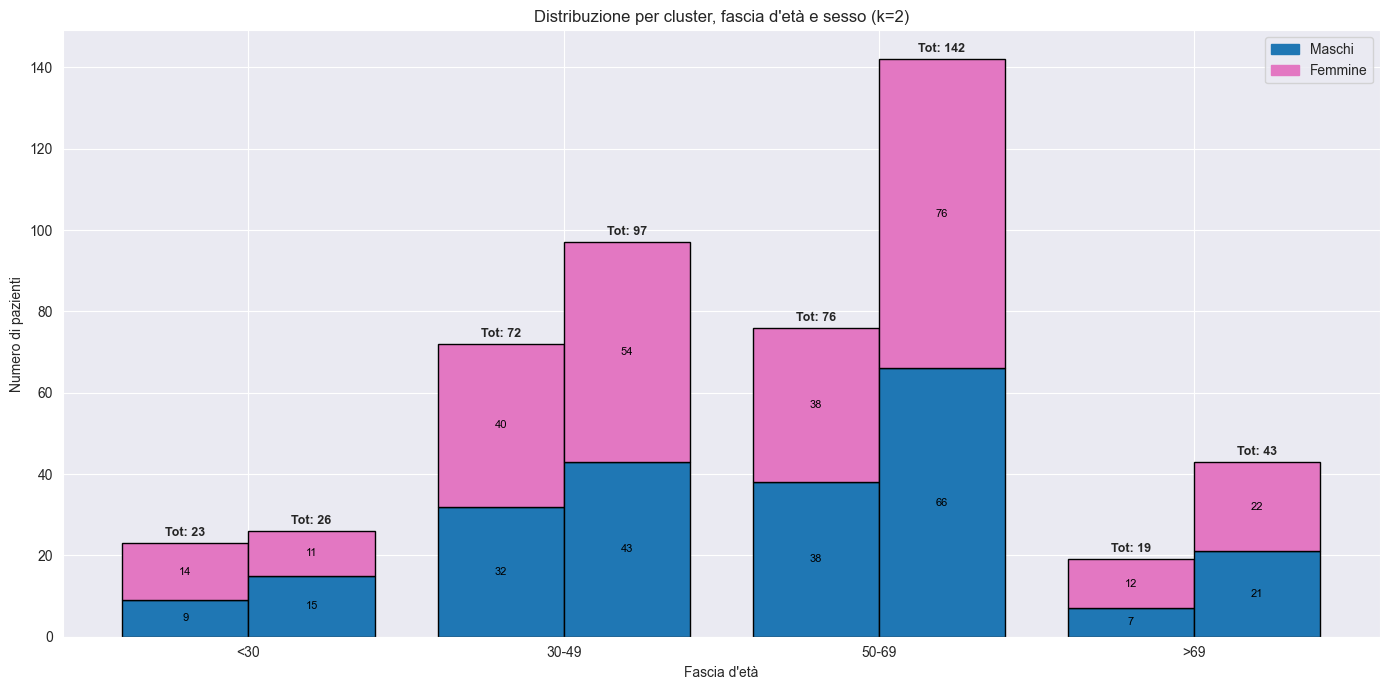

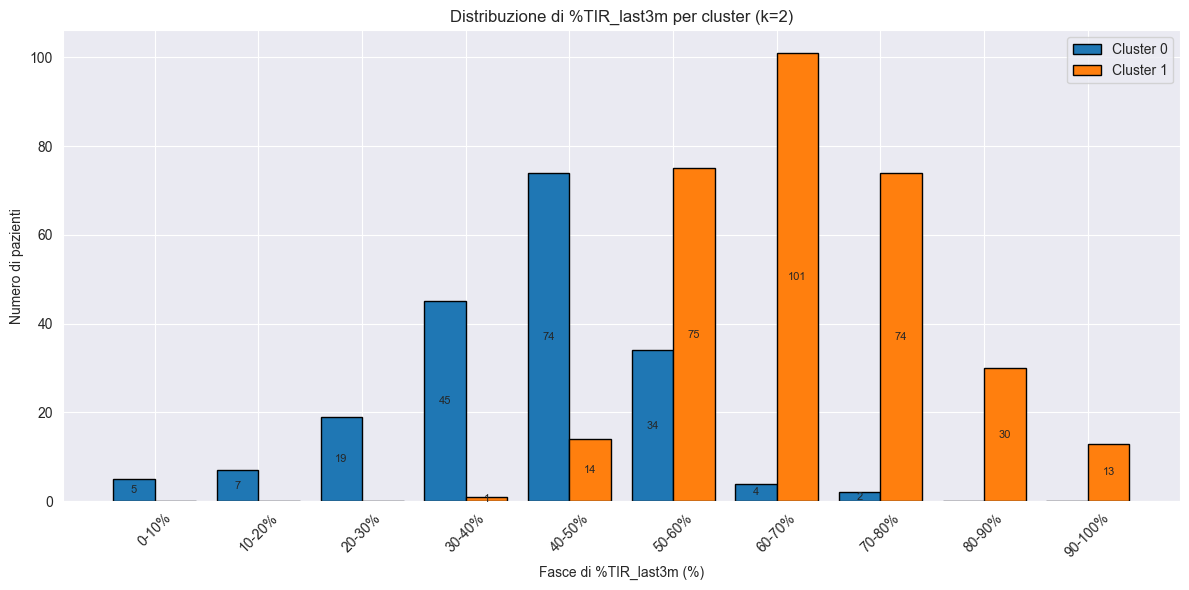

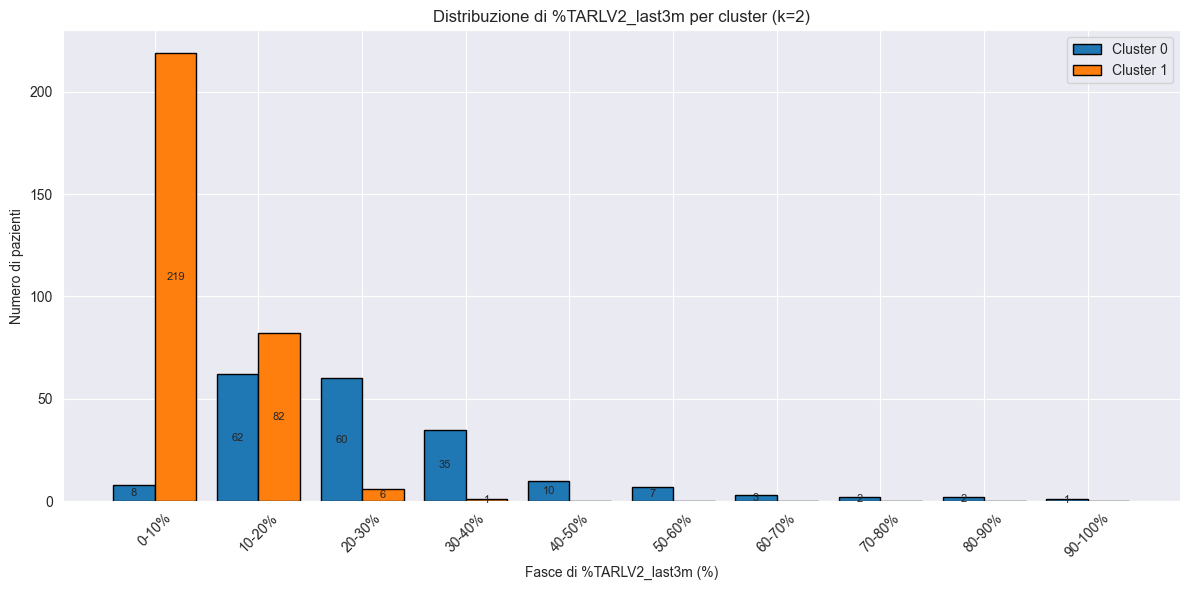

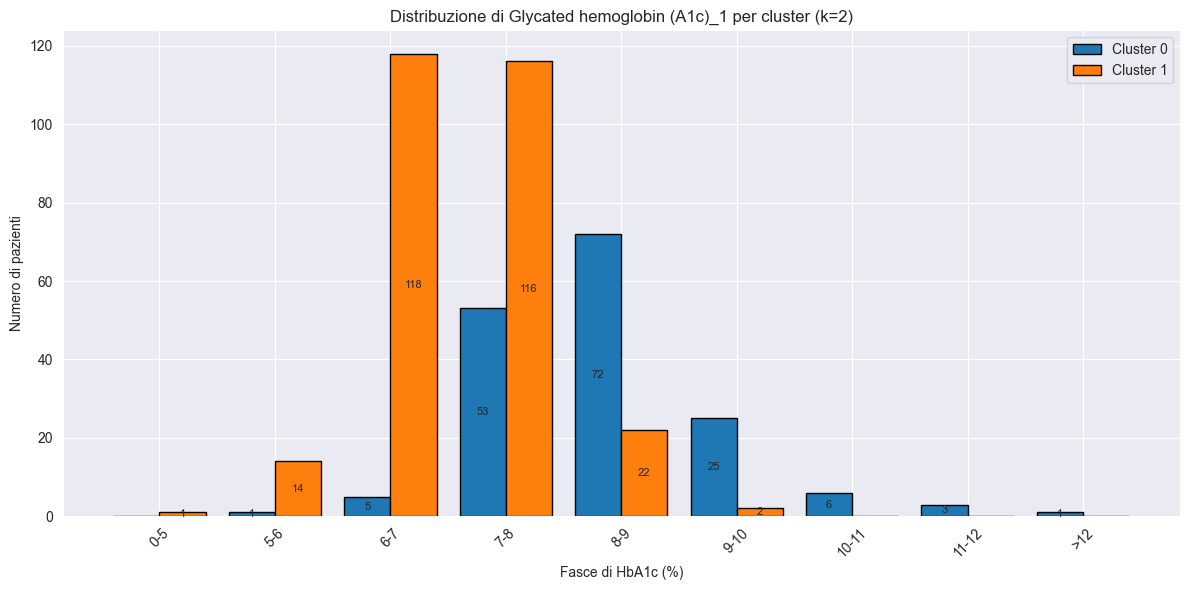

Metriche clustering per k=2:
 - Silhouette Score: 0.1320
 - Davies-Bouldin Index: 2.4139
 - Calinski-Harabasz Index: 62.9479

>>> Analisi ANOVA tra cluster k=2:
                               Feature  ANOVA_p_value  Cluster0_Mean  Cluster0_Std  Cluster1_Mean  Cluster1_Std
1                          %TIR_last3m   1.244285e-84      -0.931729      0.697162       0.574768      0.671693
2                       %TARLV2_last3m   1.839195e-69       0.868610      1.064959      -0.535831      0.405845
3          Glycated hemoglobin (A1c)_1   4.461227e-45       0.731470      0.998843      -0.451232      0.683926
4                       %TARLV1_last3m   6.493265e-36       0.662629      0.788656      -0.408765      0.891766
5                            Glucose_1   5.648014e-26       0.570594      1.051572      -0.351990      0.781020
6                             Sodium_1   2.098470e-18      -0.481845      0.872260       0.297242      0.957057
7                       %TBRLV1_last3m   1.464062e-14  

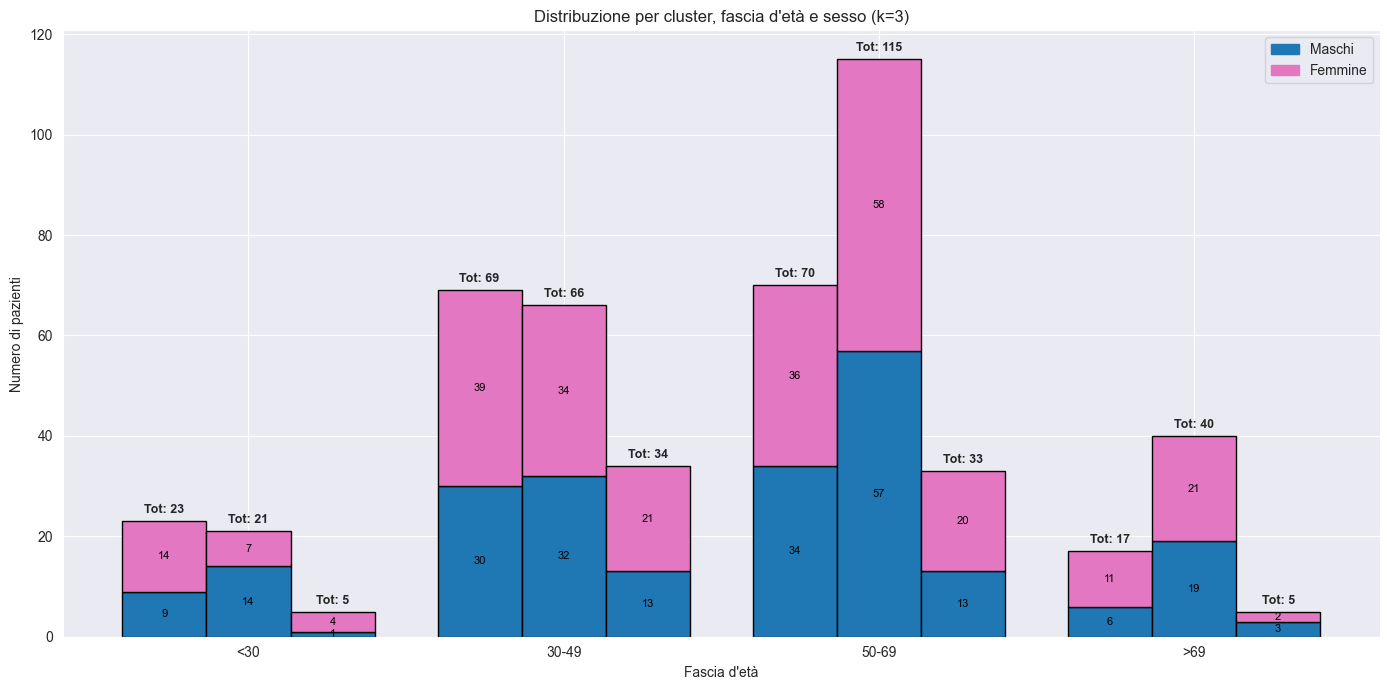

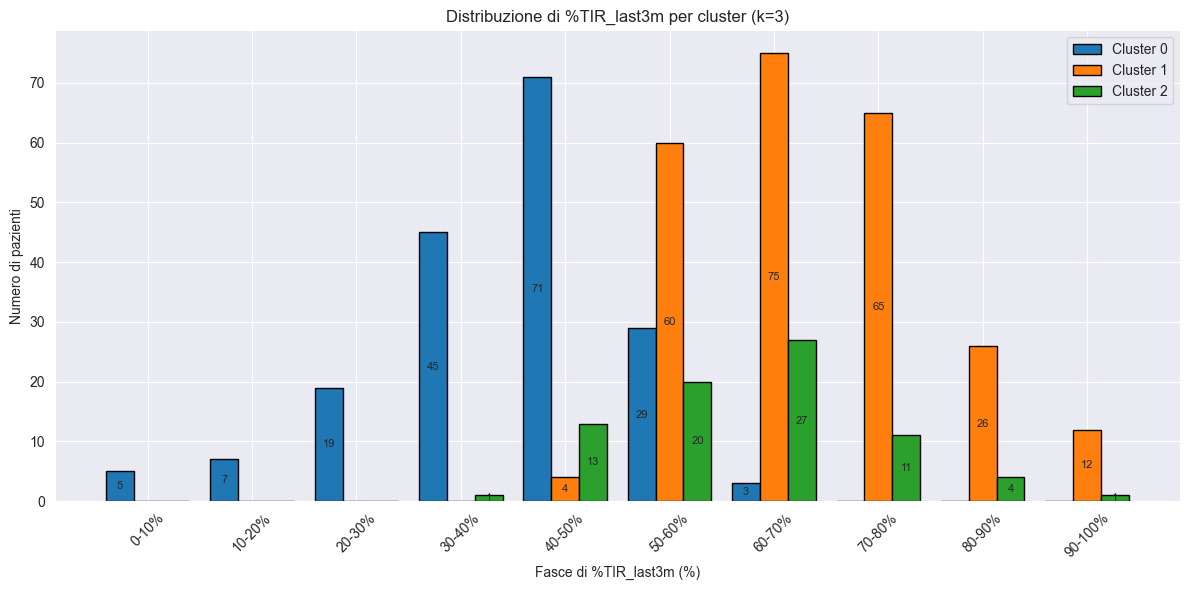

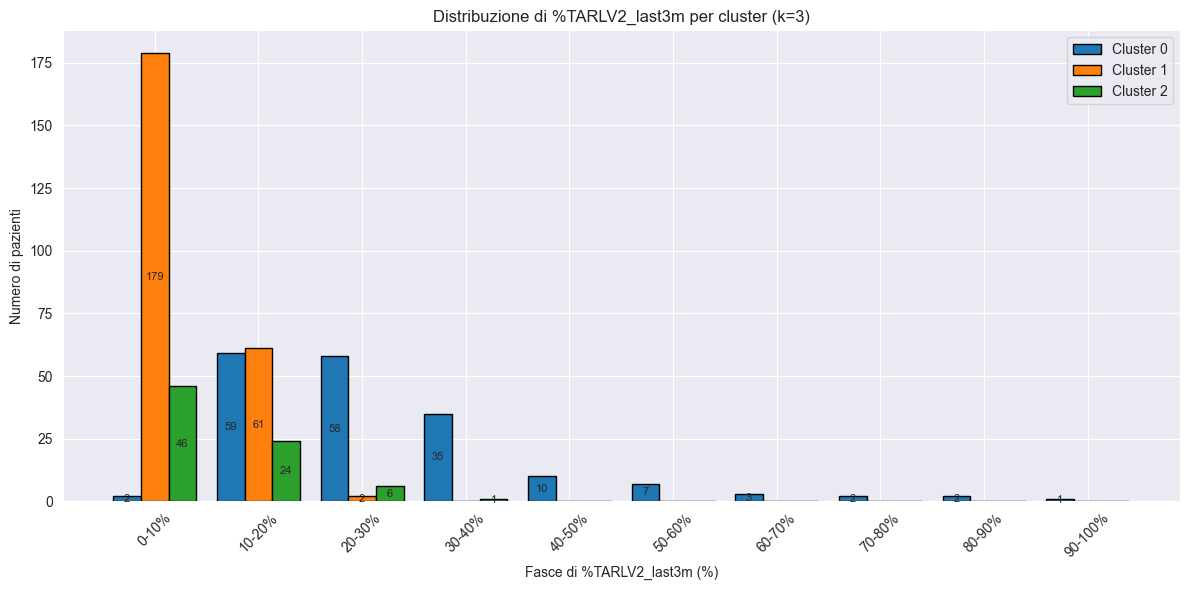

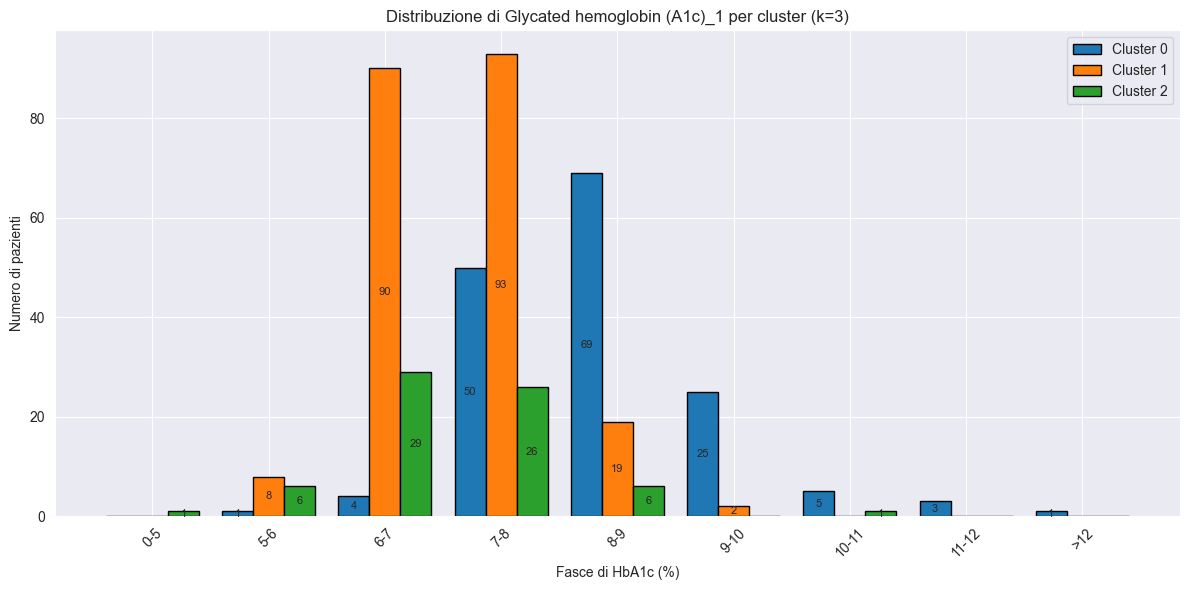

Metriche clustering per k=3:
 - Silhouette Score: 0.1086
 - Davies-Bouldin Index: 2.4520
 - Calinski-Harabasz Index: 47.3266

>>> Analisi ANOVA tra cluster k=3:
                               Feature  ANOVA_p_value  Cluster0_Mean  Cluster0_Std  Cluster1_Mean  Cluster1_Std  Cluster2_Mean  Cluster2_Std
1                       %TBRLV1_last3m   1.560779e-92      -0.445931      0.520173      -0.229214      0.591413       1.757032      1.012270
2                          %TIR_last3m   2.631604e-89      -0.986388      0.669958       0.640980      0.654433       0.278526      0.668902
3                       %TARLV2_last3m   1.095832e-74       0.938994      1.051250      -0.563571      0.361066      -0.411633      0.520961
4                       %TBRLV2_last3m   4.022344e-47      -0.194019      0.521961      -0.295650      0.335865       1.380215      1.792329
5          Glycated hemoglobin (A1c)_1   6.781438e-42       0.750604      1.001013      -0.389281      0.661602      -0.521456      0.

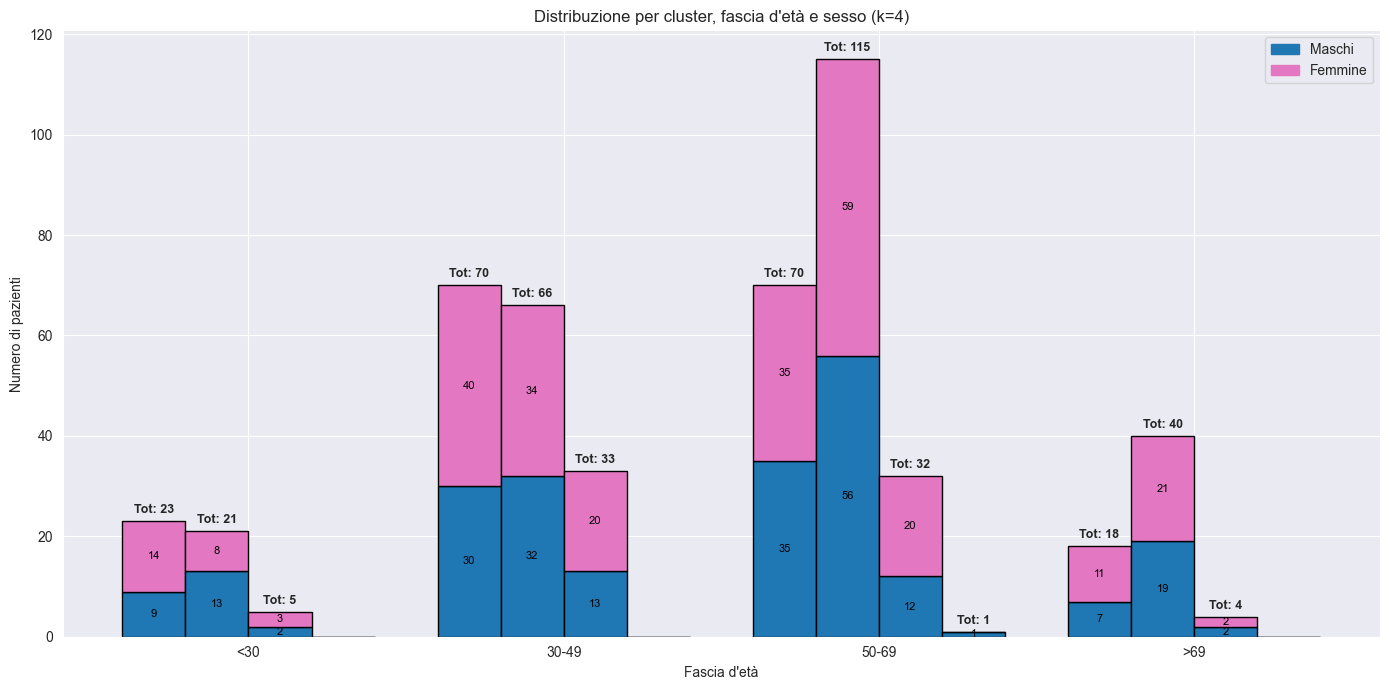

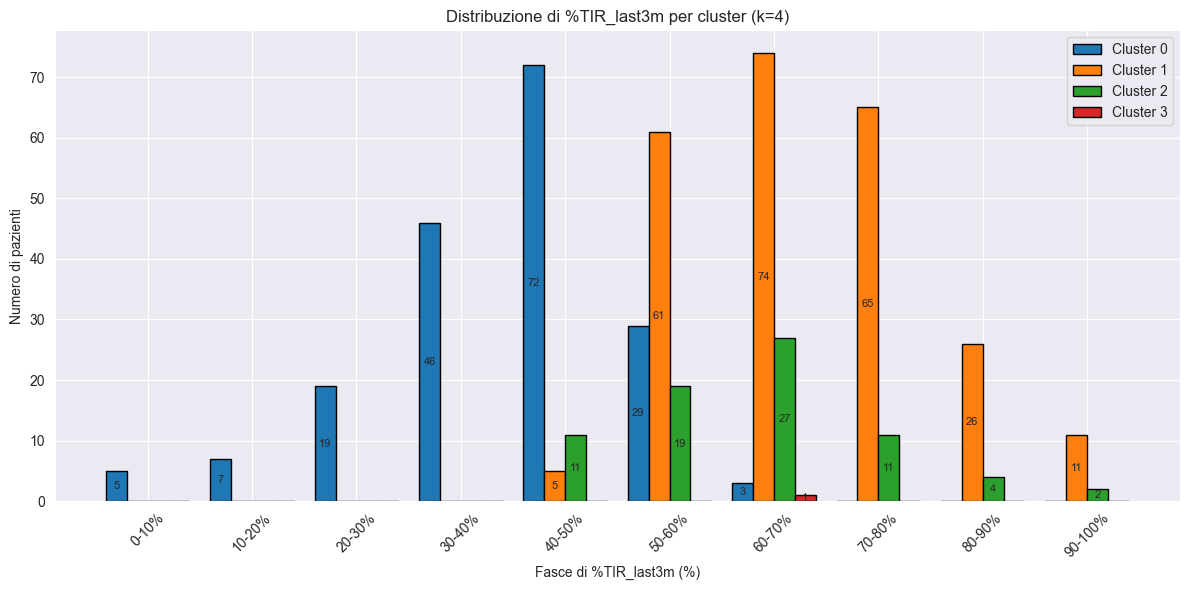

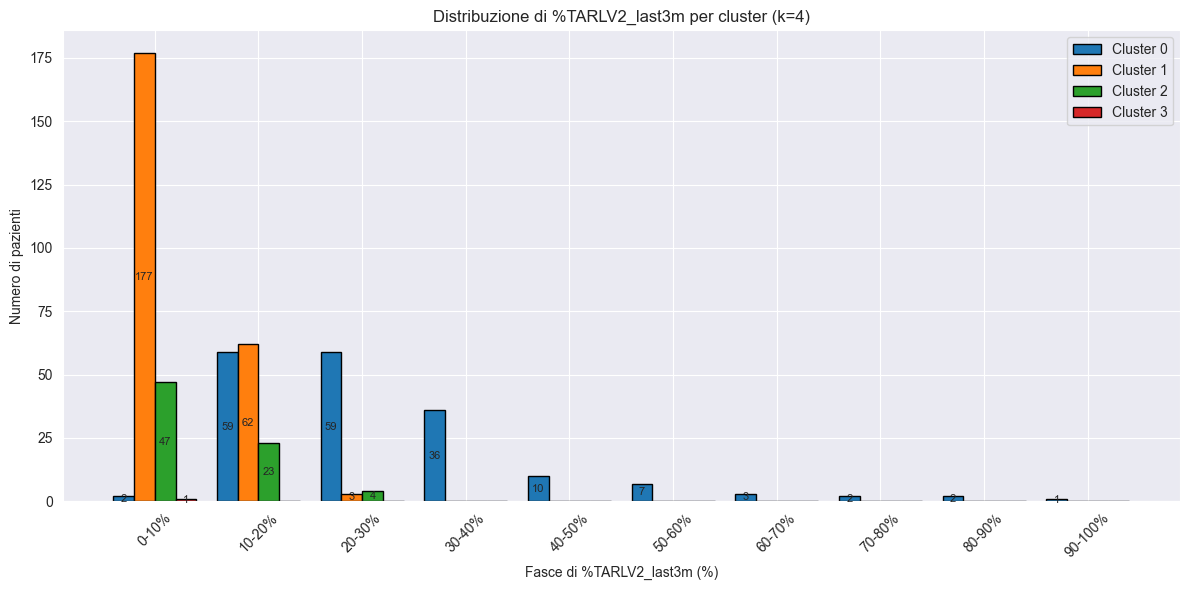

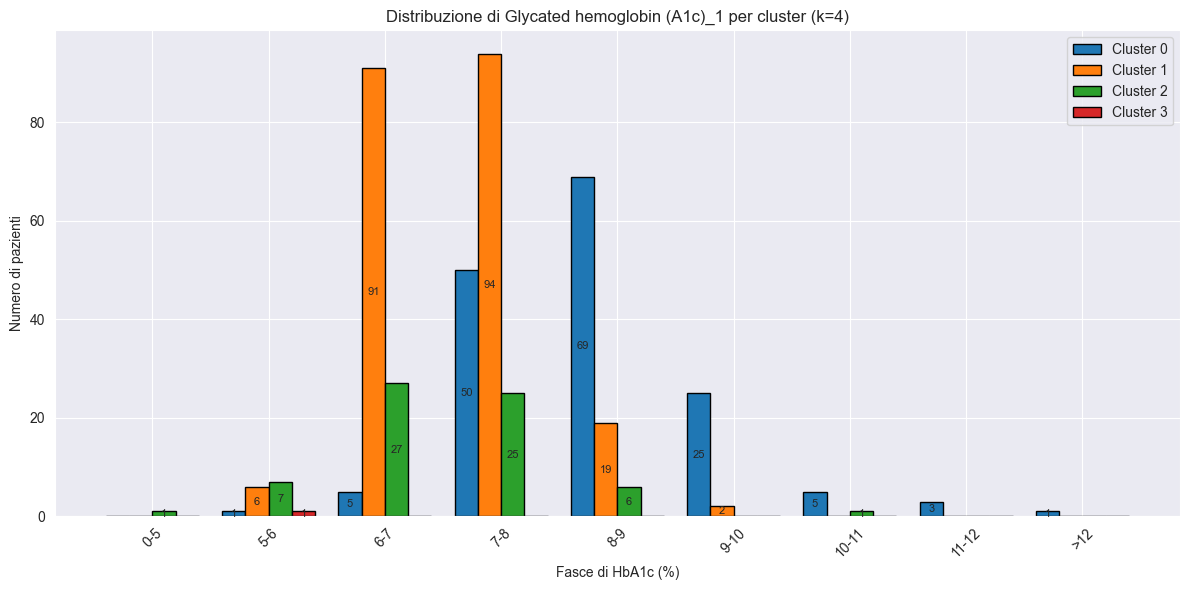

Metriche clustering per k=4:
 - Silhouette Score: 0.1094
 - Davies-Bouldin Index: 1.8438
 - Calinski-Harabasz Index: 49.2840

>>> Analisi ANOVA tra cluster k=4:
                               Feature  ANOVA_p_value  Cluster0_Mean  Cluster0_Std  Cluster1_Mean  Cluster1_Std  Cluster2_Mean  Cluster2_Std  Cluster3_Mean  Cluster3_Std
1                    Albumin (urine)_1  1.209957e-296      -0.044140      0.185348      -0.042449      0.273044      -0.044889      0.306287      21.583795           0.0
2                       %TBRLV1_last3m   3.869510e-93      -0.430696      0.535799      -0.234960      0.580039       1.807171      1.005595       1.085750           0.0
3                          %TIR_last3m   2.564913e-88      -0.985443      0.666853       0.625472      0.659458       0.357389      0.658282       0.554097           0.0
4                       %TARLV2_last3m   1.365497e-74       0.937779      1.046444      -0.553393      0.372130      -0.475529      0.463091      -0.627580    

In [17]:
#CLUSTERING CON KMEANS SUI DUE DATASET CON E SENZA COMPLICANZE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import f_oneway
from matplotlib.patches import Patch

# Funzione per il plot delle distribuzioni sesso e fasce età per ogni cluster
def plot_cluster_demographics(df_tmp, n_clusters):
    bins = [0, 29, 49, 69, np.inf]
    labels = ['<30', '30-49', '50-69', '>69']
    df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)

    cluster_data = []
    for cluster in range(n_clusters):
        cluster_df = df_tmp[df_tmp['Cluster'] == cluster]
        age_counts = []
        for age_group in labels:
            age_df = cluster_df[cluster_df['AgeGroup'] == age_group]
            male_count = len(age_df[age_df['Sex'] == 1])
            female_count = len(age_df[age_df['Sex'] == 0])
            total = male_count + female_count
            age_counts.append({'Male': male_count, 'Female': female_count, 'Total': total})
        cluster_data.append(age_counts)

    x = np.arange(len(labels))  # posizioni fasce d'età
    bar_width = 0.8 / n_clusters

    fig, ax = plt.subplots(figsize=(14,7))
    colors = {'Male': '#1f77b4', 'Female': '#e377c2'}

    for i in range(n_clusters):
        male_counts = [cluster_data[i][j]['Male'] for j in range(len(labels))]
        female_counts = [cluster_data[i][j]['Female'] for j in range(len(labels))]
        positions = x - 0.4 + i * bar_width + bar_width / 2

        bars_male = ax.bar(positions, male_counts, bar_width, color=colors['Male'], edgecolor='black', label=f'Maschi Cluster {i}')
        bars_female = ax.bar(positions, female_counts, bar_width, bottom=male_counts, color=colors['Female'], edgecolor='black', label=f'Femmine Cluster {i}')

        for bar, count in zip(bars_male, male_counts):
            if count > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, str(count), ha='center', va='center', fontsize=8, color='black')
        for bar, count, bottom in zip(bars_female, female_counts, male_counts):
            if count > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bottom + bar.get_height()/2, str(count), ha='center', va='center', fontsize=8, color='black')

        for pos, total in zip(positions, [cluster_data[i][j]['Total'] for j in range(len(labels))]):
            if total > 0:
                ax.text(pos, total + 1, f'Tot: {total}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Fascia d\'età')
    ax.set_ylabel('Numero di pazienti')
    ax.set_title(f'Distribuzione per cluster, fascia d\'età e sesso (k={n_clusters})')

    # Legenda con solo maschi e femmine
    colors = {'Male': '#1f77b4', 'Female': '#e377c2'}
    handles = [
        Patch(color=colors['Male'], label='Maschi'),
        Patch(color=colors['Female'], label='Femmine')
    ]
    ax.legend(handles=handles, loc='best')

    plt.tight_layout()
    plt.show()

# Nuova funzione per il plot degli istogrammi % TIR, TARLV2, Emoglobina glicata
def plot_percentage_histograms(df, clusters, n_clusters):
    # Variabili da plottare
    variables = ['%TIR_last3m', '%TARLV2_last3m', 'Glycated hemoglobin (A1c)_1']

    # Definizione bin personalizzati
    default_bins = np.arange(0, 110, 10)
    default_labels = [f'{default_bins[i]}-{default_bins[i+1]}%' for i in range(len(default_bins)-1)]

    a1c_bins = [0, 5, 6, 7, 8, 9, 10, 11, 12, np.inf]
    a1c_labels = [f'{a1c_bins[i]}-{a1c_bins[i+1]}' if a1c_bins[i+1] != np.inf else f'>{a1c_bins[i]}' for i in range(len(a1c_bins)-1)]

    for var in variables:
        if var == 'Glycated hemoglobin (A1c)_1':
            bins = a1c_bins
            bin_labels = a1c_labels
            xlabel = 'Fasce di HbA1c (%)'
        else:
            bins = default_bins
            bin_labels = default_labels
            xlabel = f'Fasce di {var} (%)'

        plt.figure(figsize=(12,6))
        x = np.arange(len(bin_labels))
        bar_width = 0.8 / n_clusters
        colors = plt.cm.tab10.colors

        # Per ogni cluster, conto pazienti per bin
        counts_per_cluster = []
        for c in range(n_clusters):
            cluster_vals = df.loc[clusters == c, var]
            cats = pd.cut(cluster_vals, bins=bins, labels=bin_labels, include_lowest=True, right=False)
            counts = cats.value_counts().reindex(bin_labels, fill_value=0)
            counts_per_cluster.append(counts.values)

        for c in range(n_clusters):
            positions = x - 0.4 + c * bar_width + bar_width/2
            plt.bar(positions, counts_per_cluster[c], width=bar_width, color=colors[c], edgecolor='black', label=f'Cluster {c}')
            for pos, count in zip(positions, counts_per_cluster[c]):
                if count > 0:
                    plt.text(pos, count/2, str(count), ha='center', va='center', fontsize=8)

        plt.xticks(x, bin_labels, rotation=45)
        plt.xlabel(xlabel)
        plt.ylabel('Numero di pazienti')
        plt.title(f'Distribuzione di {var} per cluster (k={n_clusters})')
        plt.legend()
        plt.tight_layout()
        plt.show()


# --- Main ---

# 1. Caricamento dati
df = pd.read_csv("Excel/Complicanze.csv")
#df = pd.read_csv("Excel/NoComplicanze.csv")

# 2. Separazione colonne demografiche (le reinseriremo dopo per i plot)
demographic_cols = ['Age', 'Sex']
demographic_df = df[demographic_cols]

# 3. Dati per clustering (tutte le colonne tranne 'Age' e 'Sex')
X = df.drop(columns=demographic_cols)

# 4. Imputazione valori mancanti con media
imputer = SimpleImputer(strategy='mean')
X_imp = imputer.fit_transform(X)

# 5. Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# 6. Clustering per k=2,3,4
for k in [2, 3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    # DataFrame temporaneo per plot + cluster
    df_tmp = demographic_df.copy()
    df_tmp['Cluster'] = clusters

    # Plot distribuzioni demografiche
    plot_cluster_demographics(df_tmp, n_clusters=k)

    # Plot istogrammi percentuali TIR, TARLV2, Emoglobina glicata
    plot_percentage_histograms(df, clusters, n_clusters=k)

    # Metriche di validazione clustering
    sil = silhouette_score(X_scaled, clusters)
    db = davies_bouldin_score(X_scaled, clusters)
    ch = calinski_harabasz_score(X_scaled, clusters)

    print(f"Metriche clustering per k={k}:")
    print(f" - Silhouette Score: {sil:.4f}")
    print(f" - Davies-Bouldin Index: {db:.4f}")
    print(f" - Calinski-Harabasz Index: {ch:.4f}")

    # Analisi ANOVA per ogni feature, confronto tra cluster
    summary = []
    feature_names = X.columns
    for i, feature in enumerate(feature_names):
        groups = [X_scaled[clusters == cluster, i] for cluster in range(k)]
        stat, p = f_oneway(*groups)
        means = [np.mean(g) for g in groups]
        stds = [np.std(g) for g in groups]

        entry = {'Feature': feature, 'ANOVA_p_value': p}
        for c in range(k):
            entry[f'Cluster{c}_Mean'] = means[c]
            entry[f'Cluster{c}_Std'] = stds[c]
        summary.append(entry)

    df_summary = pd.DataFrame(summary).sort_values("ANOVA_p_value").reset_index(drop=True)
    df_summary.index += 1

    print(f"\n>>> Analisi ANOVA tra cluster k={k}:")
    print(df_summary.to_string())
    print("\n" + "-"*40 + "\n")


In [18]:
#CREA UN DATASET PER IL CLUSTERING CHE MANTENGA LA COLONNA DELL'ID DEL PAZIENTE

import pandas as pd

# Carica i due dataset
df1 = pd.read_csv("Excel/Parte1.csv")
df2 = pd.read_csv("Excel/parte2_v1.csv")

# Rimuove la colonna "Complicanze" dal secondo dataset
df2 = df2.drop(columns=["Complicanze"])

# Effettua il merge tra df1 (usando Patient_ID) e df2 (usando ID)
merged_df = pd.merge(df1, df2, left_on="Patient_ID", right_on="ID", how="inner")

merged_df = merged_df.drop(columns=["ID"])

# Salva il dataframe risultante in un file CSV
merged_df.to_csv("Excel/Clustering2.csv", index=False)

print("Merge completato. File salvato come 'Clustering2.csv'.")


Merge completato. File salvato come 'Clustering2.csv'.


In [19]:
#CREA UN DATASET PER IL CLUSTERING CHE MANTENGA LA COLONNA DELL'ID DEL PAZIENTE IN MODO DA POTERLA TOGLIERE PER FARE CLUSTERING MA POTERLA USARE PER DETERMINARE QUALE PAZIENTE E' STATO INSERITO IN QUALE GRUPPO

import pandas as pd

# Carica i due dataset
df1 = pd.read_csv("Excel/Parte1.csv")
df2 = pd.read_csv("Excel/parte2_v1.csv")

# Rimuove la colonna "Complicanze" dal secondo dataset
df2 = df2.drop(columns=["Complicanze"])

# Effettua il merge tra df1 (usando Patient_ID) e df2 (usando ID)
merged_df = pd.merge(df1, df2, left_on="Patient_ID", right_on="ID", how="inner")

merged_df = merged_df.drop(columns=["ID"])

# Salva il dataframe risultante in un file CSV
merged_df.to_csv("Excel/Clustering2.csv", index=False)

print("Merge completato. File salvato come 'Clustering2.csv'.")


Merge completato. File salvato come 'Clustering2.csv'.



>>> Analisi ANOVA tra cluster (feature ordinati per significatività):
                               Feature  Cluster0_Mean  Cluster1_Mean  Cluster0_Std  Cluster1_Std  ANOVA_p_value
1                          %TIR_last3m       0.606039      -0.844842      0.661347      0.747361  1.952846e-114
2                       %TARLV2_last3m      -0.557944       0.777797      0.397675      1.065197   3.570252e-91
3          Glycated hemoglobin (A1c)_1      -0.464192       0.647103      0.587729      1.092420   6.388734e-58
4                       %TARLV1_last3m      -0.448529       0.625268      0.872137      0.813812   1.650552e-53
5                            Glucose_1      -0.357067       0.497766      0.763838      1.074795   1.609890e-32
6                       %TBRLV1_last3m       0.273672      -0.381510      1.130031      0.603271   4.943630e-19
7                             Sodium_1       0.273341      -0.381049      0.958139      0.930008   5.478742e-19
8                                

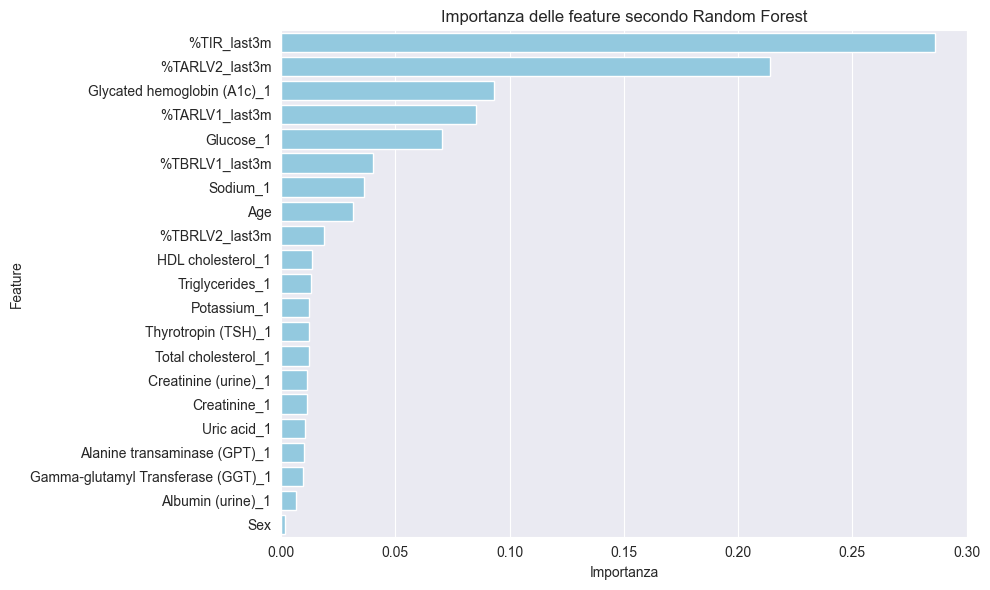

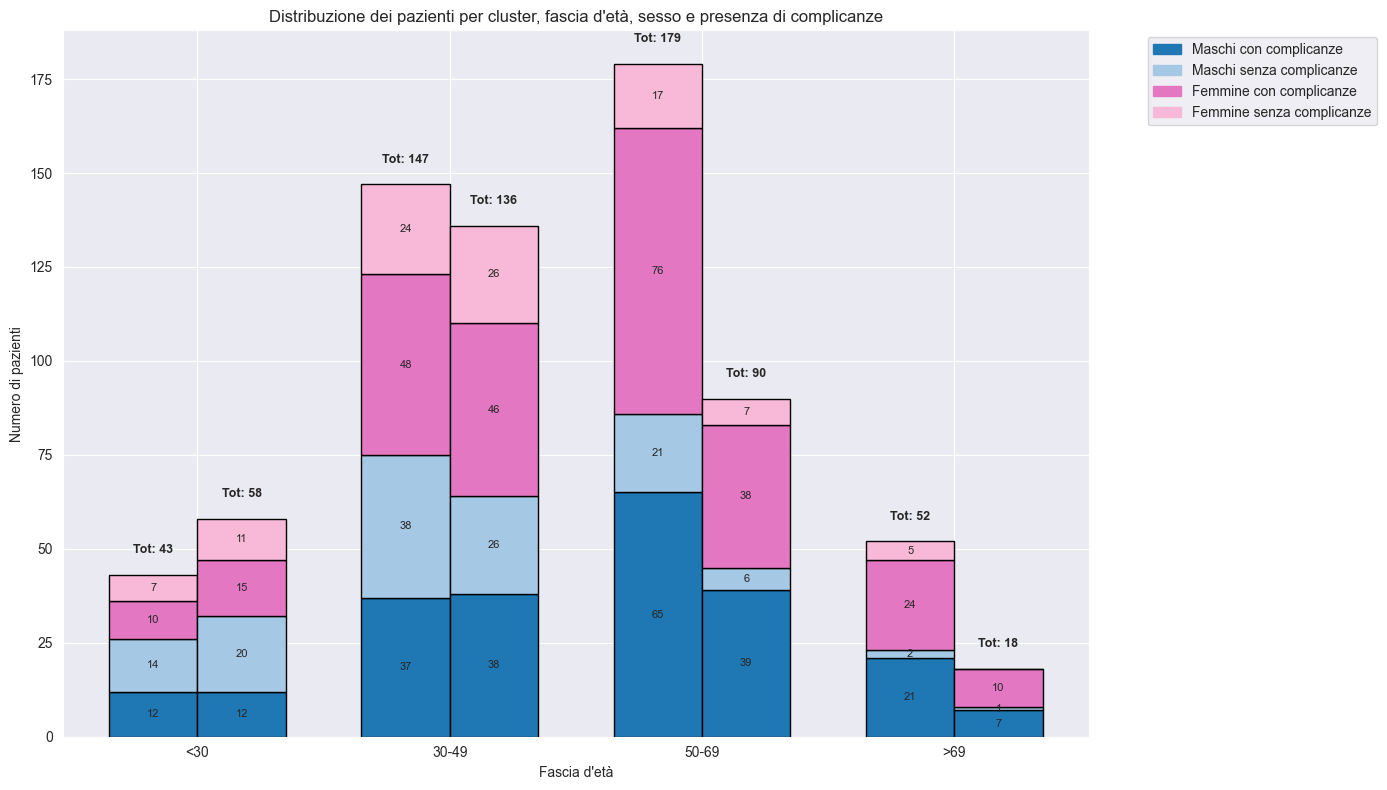

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\4213711449.py:174: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_tmp.groupby(['Cluster', f'{feature}_bin']).size().reset_index(name='Count')


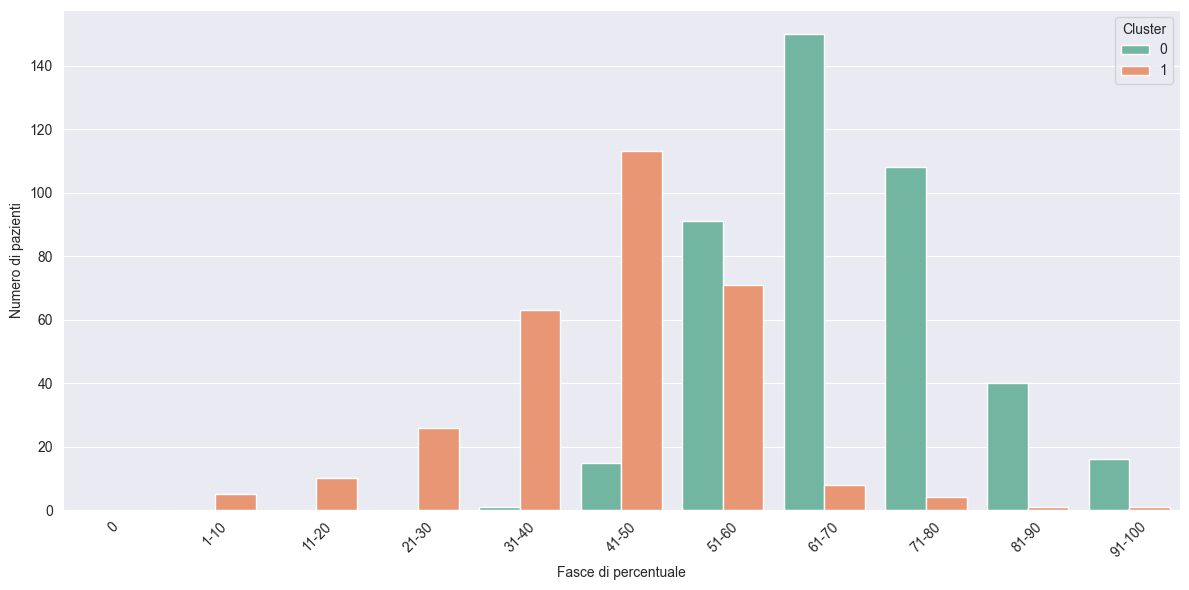

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\4213711449.py:174: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_tmp.groupby(['Cluster', f'{feature}_bin']).size().reset_index(name='Count')


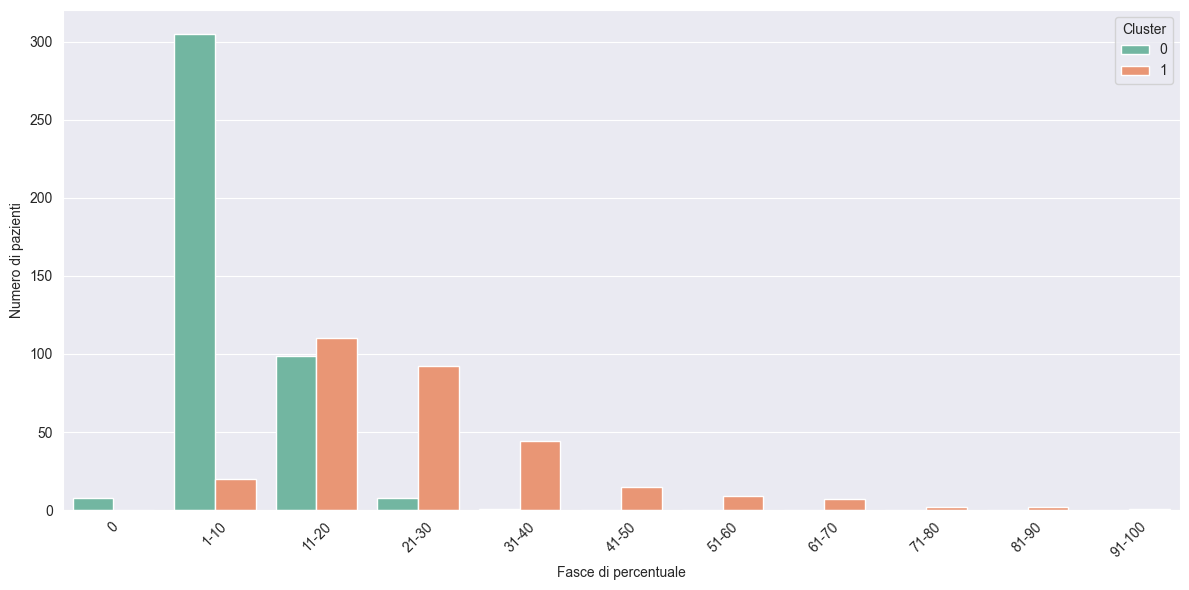

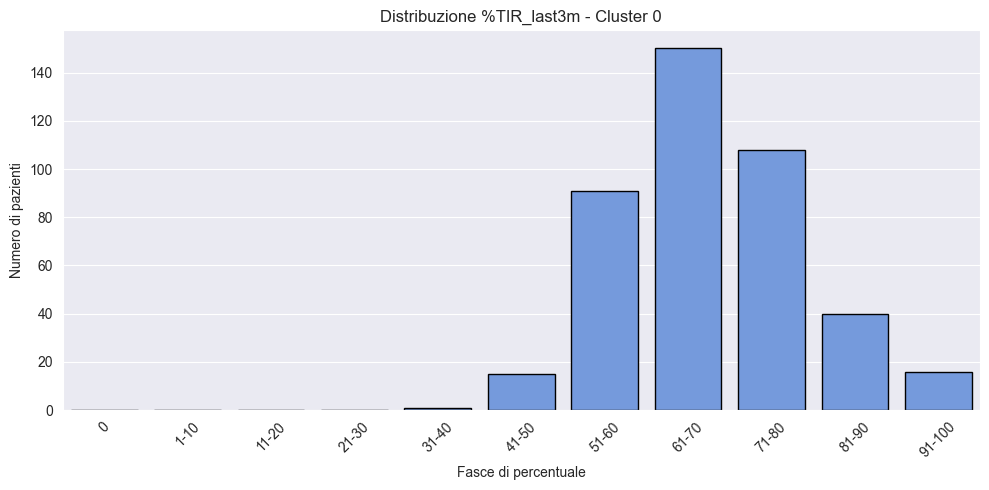

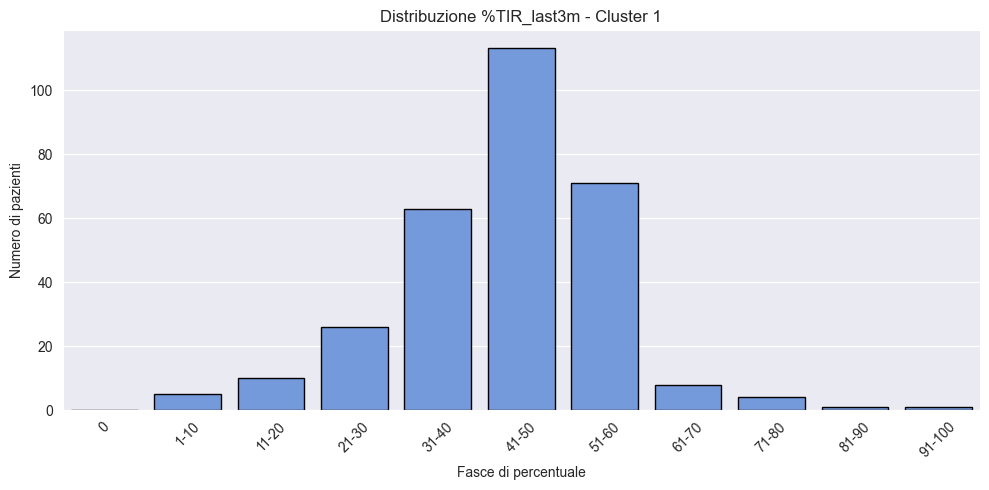

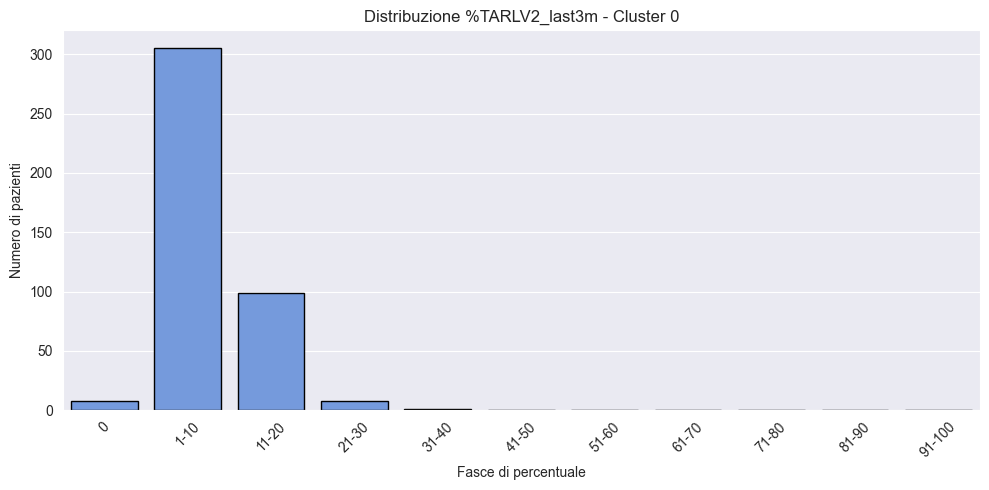

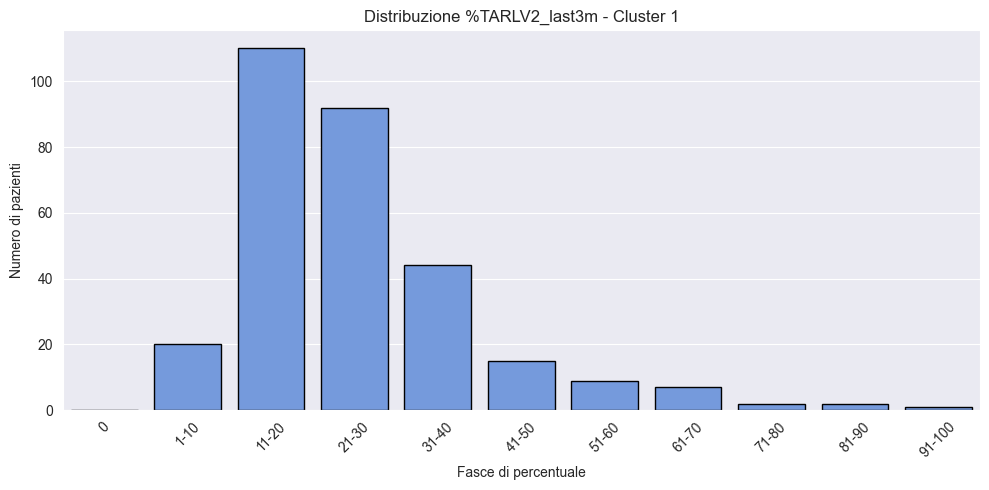

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\4213711449.py:234: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a1c_counts = df_tmp.groupby(['Cluster', 'A1c_bin']).size().reset_index(name='Count')


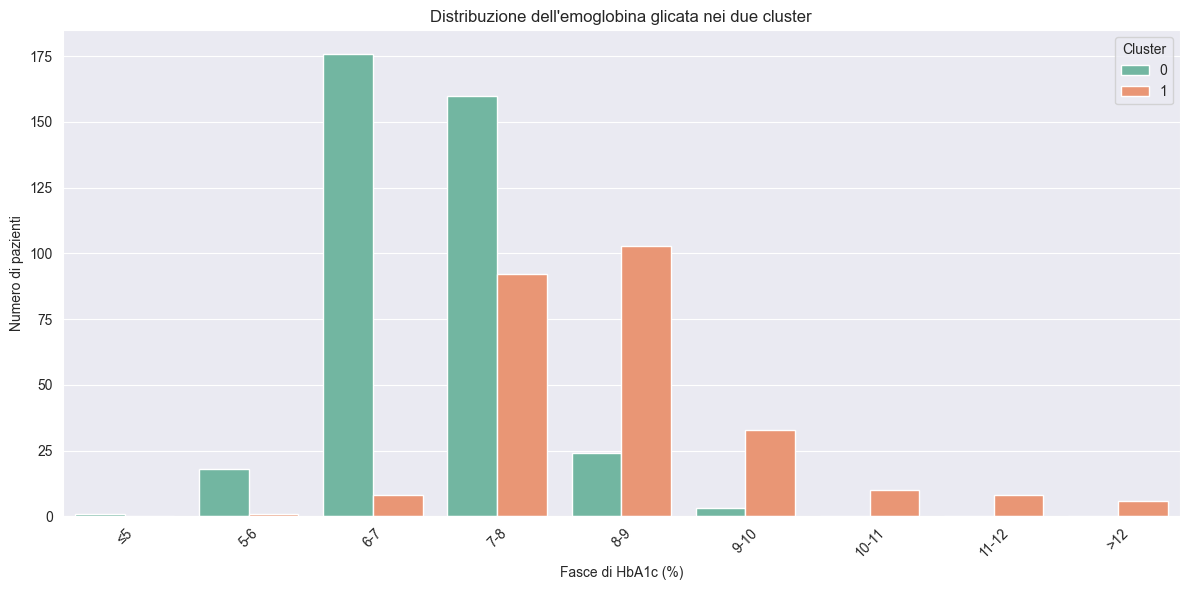


>>> Metriche di valutazione del clustering KMeans:
Silhouette Score: 0.1110
Davies-Bouldin Index: 2.7002
Calinski-Harabasz Index: 77.04
Adjusted Rand Index (ARI): 0.0012


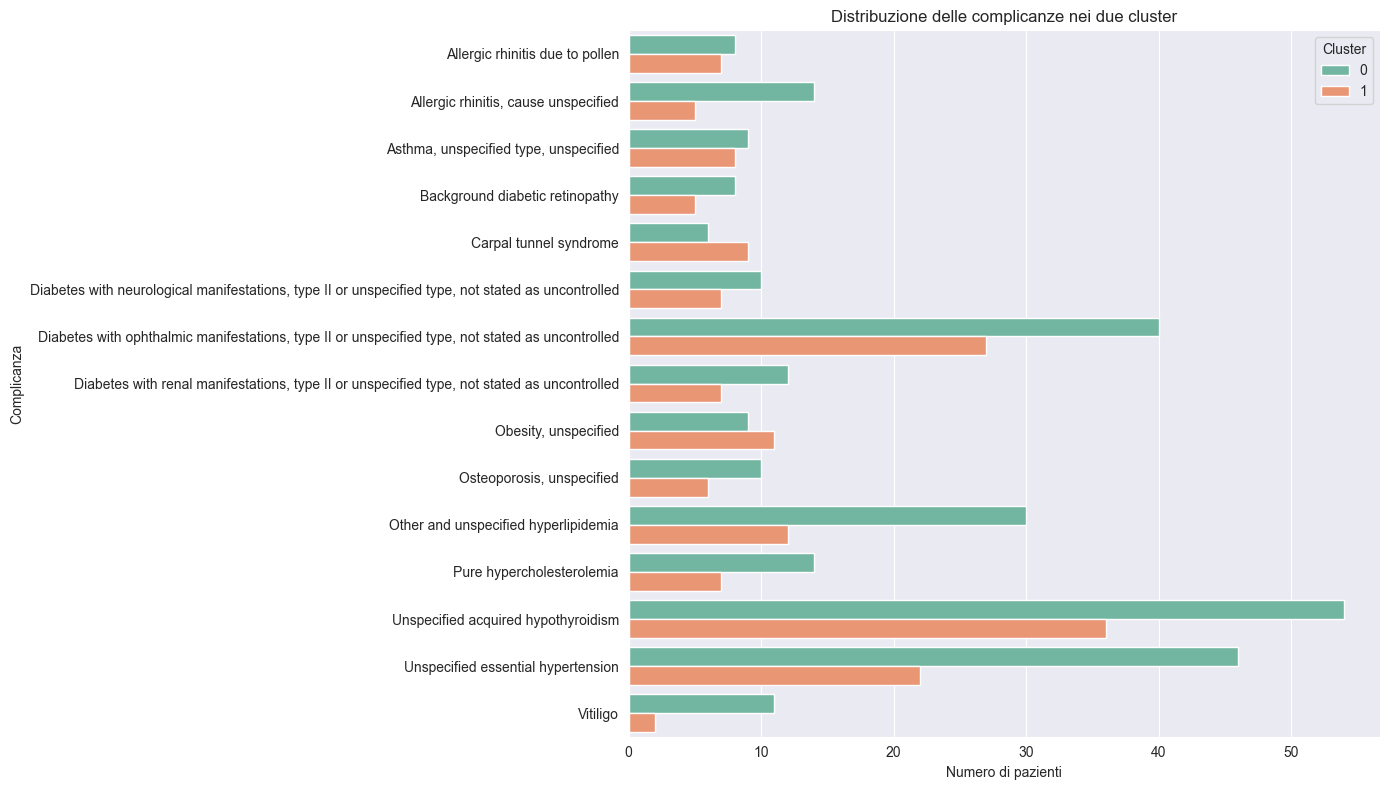

Cluster                                                                                              0   1
Description                                                                                               
Allergic rhinitis due to pollen                                                                      8   7
Allergic rhinitis, cause unspecified                                                                14   5
Asthma, unspecified type, unspecified                                                                9   8
Background diabetic retinopathy                                                                      8   5
Carpal tunnel syndrome                                                                               6   9
Diabetes with neurological manifestations, type II or unspecified type, not stated as uncontrolled  10   7
Diabetes with ophthalmic manifestations, type II or unspecified type, not stated as uncontrolled    40  27
Diabetes with renal manifestations, t

In [20]:
#ANALISI DI KMEANS SUL NUOVO DATASET CLUSTERING2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import f_oneway

# 1. Caricamento dei dati
df = pd.read_csv("Excel/Clustering2.csv")
X = df.drop(columns=["Has_Diagnostics","Patient_ID"])
y = df["Has_Diagnostics"]

# 2. Imputazione dei valori mancanti (media)
imputer = SimpleImputer(strategy="mean")
X_imp = imputer.fit_transform(X)

# 3. Standardizzazione
X_scaled = StandardScaler().fit_transform(X_imp)

# 4. KMeans clustering
kmeans = KMeans(
    n_clusters=2,
    init='random',
    n_init=10,
    max_iter=100,
    tol=0.001,
    algorithm='lloyd',
    random_state=42
)
clusters = kmeans.fit_predict(X_scaled)

# 5. Aggiunta cluster al DataFrame
df_tmp = df.copy()
df_tmp['Cluster'] = clusters

# 6. Analisi delle feature per cluster (media, std, ANOVA) Analysis of Variance per vedere se la media delle features e' significativamente diversa tra i due cluster
feature_names = X.columns
summary = []


#Per ogni feature del dataset viene calcolata la media e la deviazione standard nei due cluster e il valore p del test ANOVA
#Se p > 0.05 allora la differenza tra le media nei due cluster non e' significativa, altrimenti  e' significativa
for i, feature in enumerate(feature_names):
    cluster_0 = X_scaled[clusters == 0, i]
    cluster_1 = X_scaled[clusters == 1, i]
    stat, p = f_oneway(cluster_0, cluster_1)
    summary.append({
        'Feature': feature,
        'Cluster0_Mean': np.mean(cluster_0),
        'Cluster1_Mean': np.mean(cluster_1),
        'Cluster0_Std': np.std(cluster_0),
        'Cluster1_Std': np.std(cluster_1),
        'ANOVA_p_value': p
    })

df_summary = pd.DataFrame(summary)
df_summary = df_summary.sort_values("ANOVA_p_value").reset_index(drop=True)
df_summary.index = df_summary.index + 1  # Indici da 1 a N

print("\n>>> Analisi ANOVA tra cluster (feature ordinati per significatività):")
print(df_summary.to_string())


# 7. Feature Importance con Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, clusters)
importances = rf.feature_importances_
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# 8. Plot delle feature più importanti
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, color='skyblue')

plt.title('Importanza delle feature secondo Random Forest')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 9. Funzione per il grafico demografico
def plot_cluster_demographics(df_tmp):
    bins = [0, 29, 49, 69, np.inf]
    labels = ['<30', '30-49', '50-69', '>69']
    df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)

    cluster_data = []
    for cluster in [0, 1]:
        cluster_df = df_tmp[df_tmp['Cluster'] == cluster]
        age_counts = []
        for age_group in labels:
            age_df = cluster_df[cluster_df['AgeGroup'] == age_group]
            male_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 1)])
            male_no_dx = len(age_df[(age_df['Sex'] == 1) & (age_df['Has_Diagnostics'] == 0)])
            female_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 1)])
            female_no_dx = len(age_df[(age_df['Sex'] == 0) & (age_df['Has_Diagnostics'] == 0)])
            age_counts.append({
                'Male_Dx': male_dx,
                'Male_NoDx': male_no_dx,
                'Female_Dx': female_dx,
                'Female_NoDx': female_no_dx,
                'Total': male_dx + male_no_dx + female_dx + female_no_dx
            })
        cluster_data.append(age_counts)

    fig, ax = plt.subplots(figsize=(14, 8))
    colors = {
        'Male_Dx': '#1f77b4',
        'Male_NoDx': '#a5c8e4',
        'Female_Dx': '#e377c2',
        'Female_NoDx': '#f8b8d8'
    }

    bar_width = 0.35
    x = np.arange(len(labels))
    for i, cluster in enumerate([0, 1]):
        positions = x + i * bar_width
        bottom = np.zeros(len(labels))
        for segment in ['Male_Dx', 'Male_NoDx', 'Female_Dx', 'Female_NoDx']:
            counts = [cluster_data[cluster][j][segment] for j in range(len(labels))]
            ax.bar(positions, counts, bar_width, bottom=bottom, color=colors[segment], edgecolor='black')
            for j, count in enumerate(counts):
                if count > 0:
                    ax.text(positions[j], bottom[j] + count/2, str(count), ha='center', va='center', fontsize=8)
            bottom += counts
        for j in range(len(labels)):
            total = cluster_data[cluster][j]['Total']
            ax.text(positions[j], bottom[j] + 5, f'Tot: {total}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Fascia d\'età')
    ax.set_ylabel('Numero di pazienti')
    ax.set_title('Distribuzione dei pazienti per cluster, fascia d\'età, sesso e presenza di complicanze')

    handles = [
        plt.Rectangle((0, 0), 1, 1, color=colors['Male_Dx'], label='Maschi con complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Male_NoDx'], label='Maschi senza complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Female_Dx'], label='Femmine con complicanze'),
        plt.Rectangle((0, 0), 1, 1, color=colors['Female_NoDx'], label='Femmine senza complicanze'),
    ]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# 10. Mostra il grafico demografico
plot_cluster_demographics(df_tmp)


# 11. Istogrammi separati per %TIR_last3m e %TARLV2_last3m


# 2 ISTOGRAMMI
# Colonne target
features = ['%TIR_last3m', '%TARLV2_last3m']

# Definizione fasce
bins = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

for feature in features:
    # Crea la colonna con le fasce
    df_tmp[f'{feature}_bin'] = pd.cut(df_tmp[feature], bins=bins, labels=labels, include_lowest=True, right=True)

    # Conta i pazienti per cluster e fascia
    counts = df_tmp.groupby(['Cluster', f'{feature}_bin']).size().reset_index(name='Count')
    counts.rename(columns={f'{feature}_bin': 'Fascia'}, inplace=True)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=counts, x='Fascia', y='Count', hue='Cluster', palette='Set2', dodge=True)

    plt.title('')
    plt.xlabel('Fasce di percentuale')
    plt.ylabel('Numero di pazienti')
    plt.legend(title='Cluster')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



# 4 ISTOGRAMMI
# Colonne target
features = ['%TIR_last3m', '%TARLV2_last3m']

# Definizione fasce
bins = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Crea le colonne binned per ogni feature
for feature in features:
    df_tmp[f'{feature}_bin'] = pd.cut(df_tmp[feature], bins=bins, labels=labels, include_lowest=True, right=True)

# Per ogni combinazione di feature e cluster, plottiamo un istogramma
for feature in features:
    for cluster in [0, 1]:
        # Filtra solo i dati del cluster corrente
        cluster_df = df_tmp[df_tmp['Cluster'] == cluster]

        # Conta i pazienti nelle fasce
        counts = cluster_df[f'{feature}_bin'].value_counts().sort_index()

        # Plot
        plt.figure(figsize=(10, 5))
        sns.barplot(x=counts.index, y=counts.values, color='cornflowerblue', edgecolor='black')

        plt.title(f'Distribuzione {feature} - Cluster {cluster}')
        plt.xlabel('Fasce di percentuale')
        plt.ylabel('Numero di pazienti')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


a1c_col = 'Glycated hemoglobin (A1c)_1'

# Definizione dei bin per l'emoglobina glicata
bins_a1c = [0, 5, 6, 7, 8, 9, 10, 11, 12, np.inf]
labels_a1c = ['≤5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11', '11-12', '>12']

# Crea la colonna binned
df_tmp['A1c_bin'] = pd.cut(df_tmp[a1c_col], bins=bins_a1c, labels=labels_a1c, include_lowest=True, right=False)

# Conta i pazienti per cluster e fascia
a1c_counts = df_tmp.groupby(['Cluster', 'A1c_bin']).size().reset_index(name='Count')

# Plot istogramma a due colonne
plt.figure(figsize=(12, 6))
sns.barplot(data=a1c_counts, x='A1c_bin', y='Count', hue='Cluster', palette='Set2', dodge=True)

plt.title('Distribuzione dell\'emoglobina glicata nei due cluster')
plt.xlabel('Fasce di HbA1c (%)')
plt.ylabel('Numero di pazienti')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score


# Calcolo delle metriche di valutazione del clustering
sil_score = silhouette_score(X_scaled, clusters)
dbi = davies_bouldin_score(X_scaled, clusters)
chi = calinski_harabasz_score(X_scaled, clusters)
ari = adjusted_rand_score(y, clusters)  # già calcolato, ma lo ricalcoliamo qui per coerenza

print("\n>>> Metriche di valutazione del clustering KMeans:")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi:.4f}")
print(f"Calinski-Harabasz Index: {chi:.2f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

#ANALISI IN DETTAGLIO DELLE COMPLICANZE

# 12. Analisi delle complicanze per cluster usando Diagnostics.csv
# Carica il dataset delle complicanze
diagnostics_df = pd.read_csv("Excel/Diagnostics.csv")

# Associa il cluster a ciascun paziente creando un nuovo dataset
patient_clusters = df_tmp[['Patient_ID', 'Cluster']]

# Unisci le informazioni di cluster alle complicanze
diag_with_cluster = diagnostics_df.merge(patient_clusters, on="Patient_ID", how="inner")

# Conta le complicanze per Description e Cluster
complication_counts = diag_with_cluster.groupby(['Description', 'Cluster']).size().reset_index(name='Count')
#OTTENIAMO UNA COSA DEL GENERE:
#Description              Cluster    Count
# Neuropathy               0          12
# Neuropathy               1          28

# Calcola il totale delle complicanze e seleziona le 15 piu frequenti
complication_totals = complication_counts.groupby('Description')['Count'].sum().reset_index()
top_complications = complication_totals.sort_values('Count', ascending=False).head(15)['Description']

# Filtro per le prime 15 complicanze più frequenti
complication_counts_filtered = complication_counts[complication_counts['Description'].isin(top_complications)]

# Plot: Complicanze più frequenti nei due cluster
plt.figure(figsize=(14, 8))
sns.barplot(data=complication_counts_filtered, x='Count', y='Description', hue='Cluster', palette='Set2')
plt.title('Distribuzione delle complicanze nei due cluster')
plt.xlabel('Numero di pazienti')
plt.ylabel('Complicanza')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


from scipy.stats import chi2_contingency

# Tabella di contingenza
contingency_table = pd.crosstab(
    diag_with_cluster[diag_with_cluster['Description'].isin(top_complications)]['Description'],
    diag_with_cluster[diag_with_cluster['Description'].isin(top_complications)]['Cluster']
)
print(contingency_table)


# Test del chi-quadro
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-quadro: chi2 = {chi2:.2f}, p-value = {p:.4f}")




>>> Analisi ANOVA tra cluster GMM:
                               Feature  Cluster0_Mean  Cluster1_Mean  Cluster0_Std  Cluster1_Std  ANOVA_p_value
1                       %TARLV2_last3m      -0.186483       0.656189      0.678863      1.531067   3.082167e-22
2          Glycated hemoglobin (A1c)_1      -0.169471       0.596325      0.733812      1.472178   1.929088e-18
3                      Triglycerides_1      -0.169073       0.594927      0.486193      1.797902   2.337418e-18
4   Gamma-glutamyl Transferase (GGT)_1      -0.156190       0.549595      0.151234      2.012554   8.872522e-16
5                            Glucose_1      -0.125331       0.441008      0.882332      1.236774   1.548685e-10
6                          %TIR_last3m       0.125318      -0.440962      0.846379      1.322255   1.555704e-10
7         Alanine transaminase (GPT)_1      -0.122710       0.431788      0.374243      1.945892   3.778091e-10
8                       %TBRLV1_last3m       0.117663      -0.414026

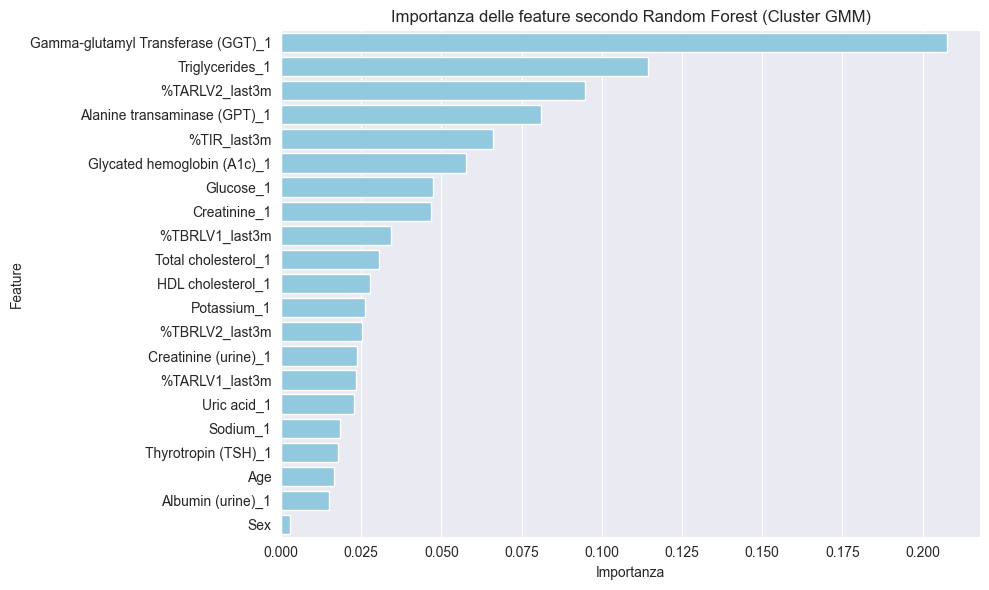

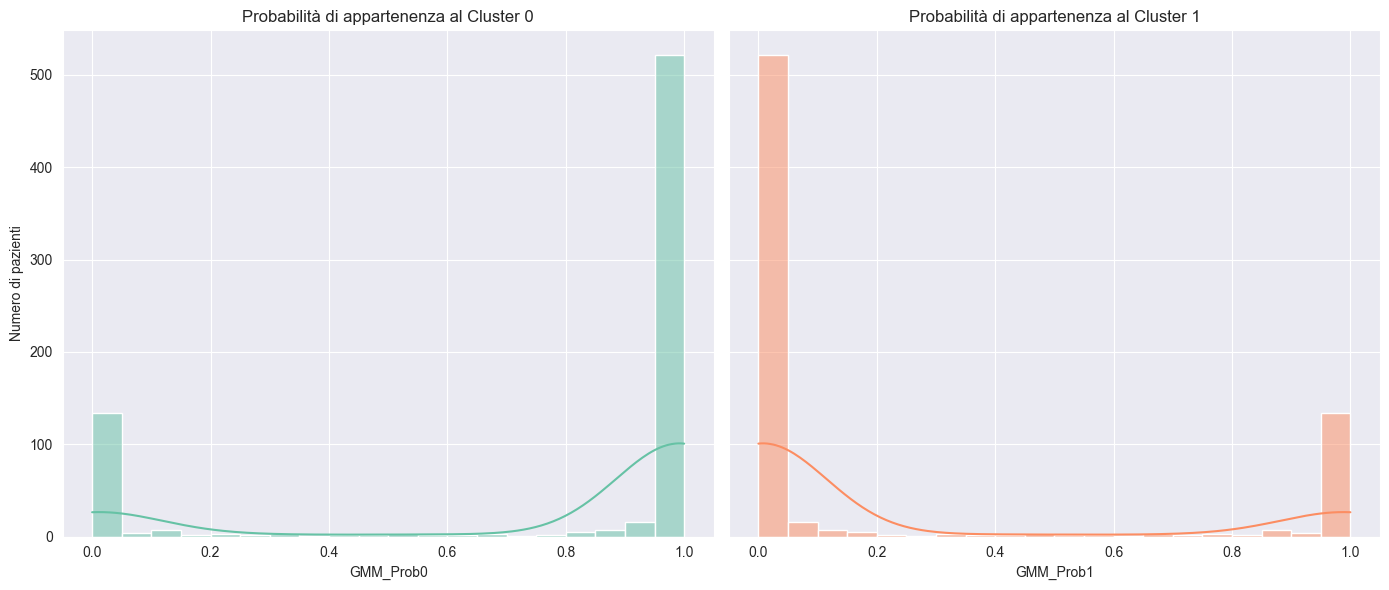

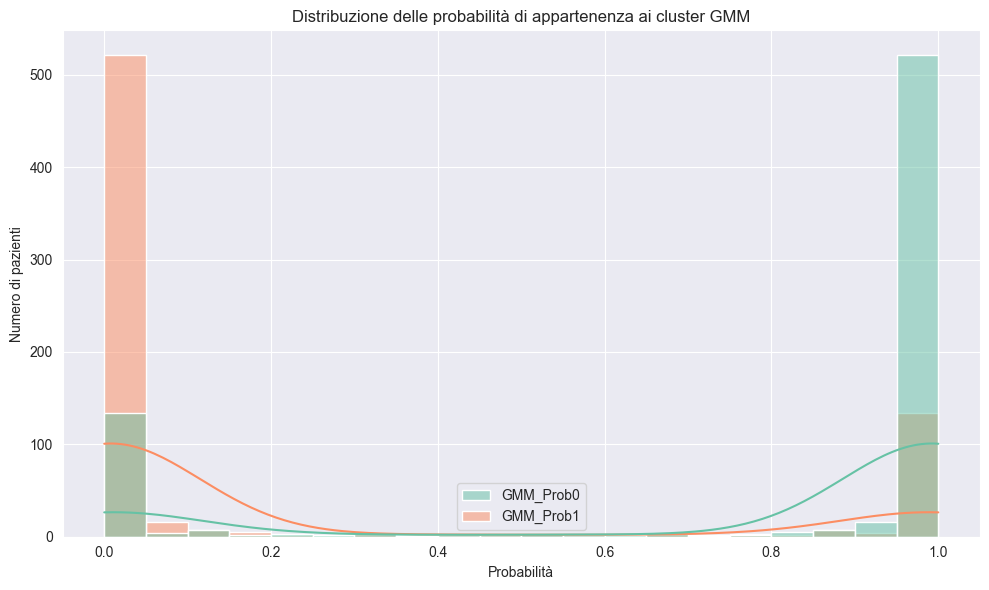


>>> Pazienti borderline (probabilità ∈ [0.4, 0.6]): 9 su 723

>>> Esempi di pazienti borderline:
Patient_ID  Sex  Age  Has_Diagnostics  %TIR_last3m  %TARLV1_last3m  %TARLV2_last3m  %TBRLV1_last3m  %TBRLV2_last3m  Alanine transaminase (GPT)_1  Albumin (urine)_1  Creatinine (urine)_1  Creatinine_1  Gamma-glutamyl Transferase (GGT)_1  Glucose_1  Glycated hemoglobin (A1c)_1  HDL cholesterol_1  Potassium_1  Sodium_1  Thyrotropin (TSH)_1  Total cholesterol_1  Triglycerides_1  Uric acid_1  Cluster_GMM  GMM_Prob0  GMM_Prob1  Borderline
 LIB193467    1   61                1    68.443649       24.054860        5.283244        2.206321        0.011926                          19.0               0.99                 99.47          0.80                                43.0      117.0                          6.6               52.0         5.62     138.0                0.917                182.0             92.0          4.3            1   0.412005   0.587995        True
 LIB193468    1   58        

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\2538194274.py:146: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_tmp.groupby(['Cluster_GMM', f'{feature}_bin']).size().reset_index(name='Count')


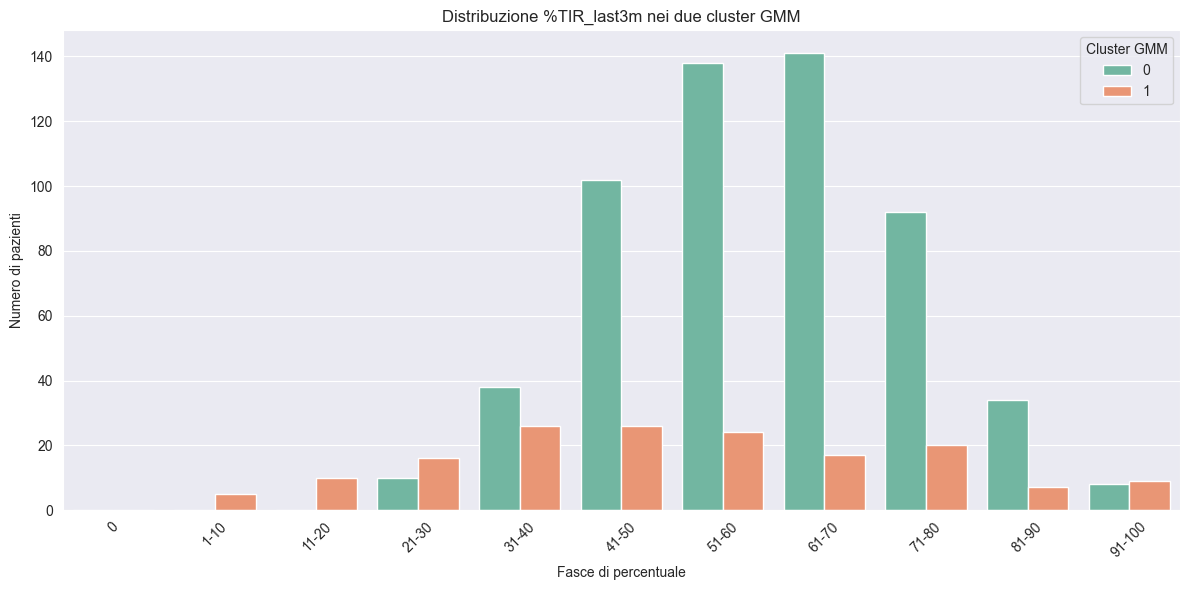

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\2538194274.py:146: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_tmp.groupby(['Cluster_GMM', f'{feature}_bin']).size().reset_index(name='Count')


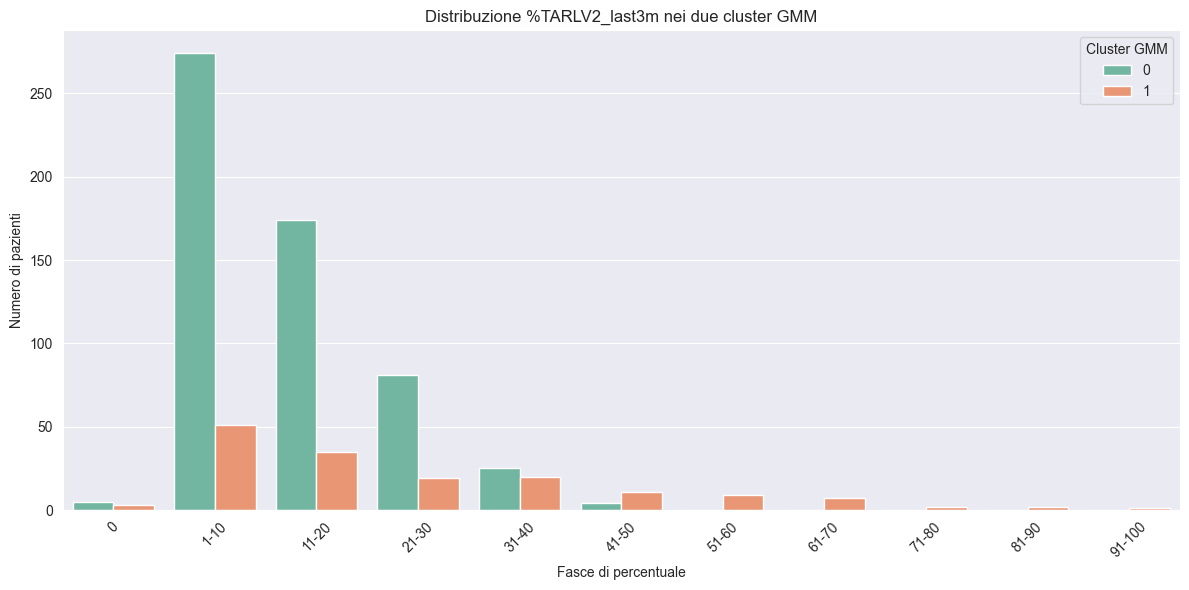

C:\Users\matte\AppData\Local\Temp\ipykernel_8196\2538194274.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a1c_counts = df_tmp.groupby(['Cluster_GMM', 'A1c_bin']).size().reset_index(name='Count')


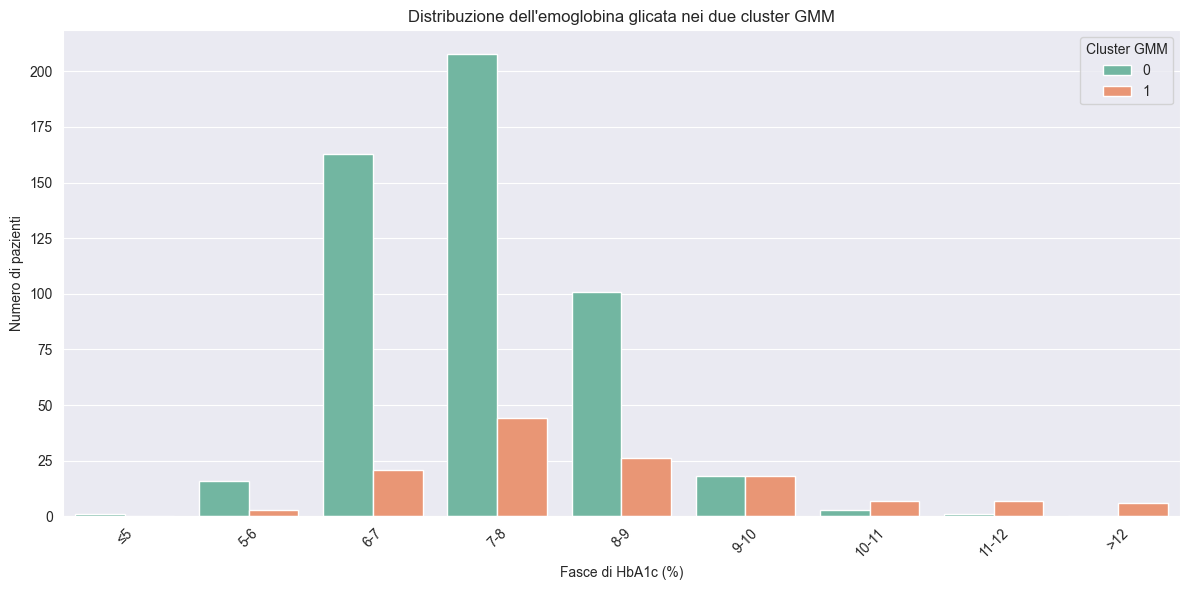


>>> Media di Has_Diagnostics per cluster GMM:
Cluster_GMM
0    0.667851
1    0.762500
Name: Has_Diagnostics, dtype: float64

>>> Matrice di confusione (etichetta: Has_Diagnostics vs Cluster_GMM):
[[187  38]
 [376 122]]

>>> Metriche di valutazione del clustering GMM:
Silhouette Score: 0.1394
Davies-Bouldin Index: 4.0453
Calinski-Harabasz Index: 29.29
Adjusted Rand Index (ARI): -0.0252


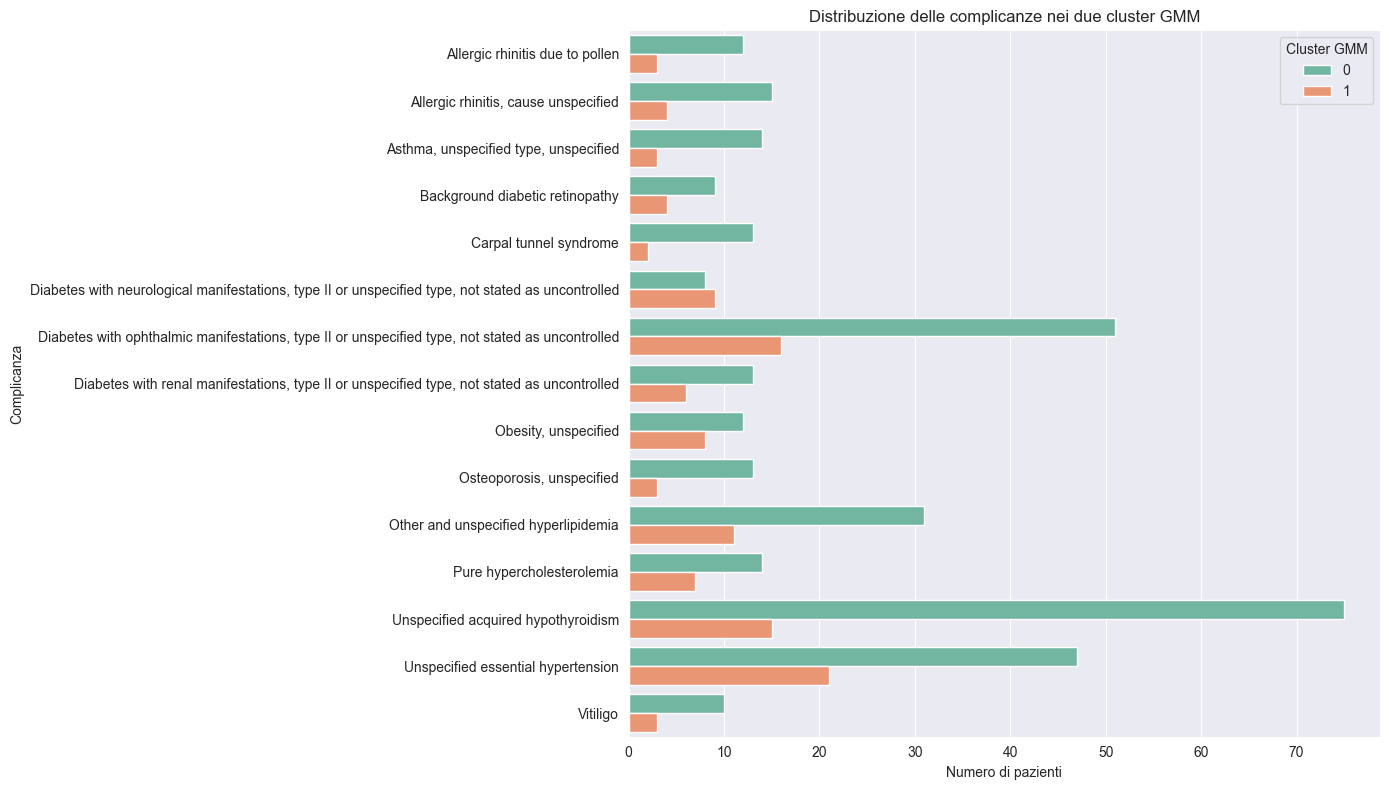


Tabella di contingenza complicanze cluster GMM:
Cluster_GMM                                                                                          0   1
Description                                                                                               
Allergic rhinitis due to pollen                                                                     12   3
Allergic rhinitis, cause unspecified                                                                15   4
Asthma, unspecified type, unspecified                                                               14   3
Background diabetic retinopathy                                                                      9   4
Carpal tunnel syndrome                                                                              13   2
Diabetes with neurological manifestations, type II or unspecified type, not stated as uncontrolled   8   9
Diabetes with ophthalmic manifestations, type II or unspecified type, not stated as uncontrolle

In [21]:
#ANALISI DI GMM SUL NUOVO DATASET CLUSTERING2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import f_oneway
from sklearn.metrics import adjusted_rand_score

# 1. Caricamento dei dati
df = pd.read_csv("Excel/Clustering2.csv")
X = df.drop(columns=["Has_Diagnostics","Patient_ID"])
y = df["Has_Diagnostics"]

# 2. Imputazione dei valori mancanti (media)
imputer = SimpleImputer(strategy="mean")
X_imp = imputer.fit_transform(X)

# 3. Standardizzazione
X_scaled = StandardScaler().fit_transform(X_imp)

# 4. GMM clustering
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_scaled)
clusters = gmm.predict(X_scaled)
probs = gmm.predict_proba(X_scaled)  # probabilità di appartenenza

# 5. Aggiunta cluster e probabilità al DataFrame
df_tmp = df.copy()
df_tmp['Cluster_GMM'] = clusters
df_tmp['GMM_Prob0'] = probs[:, 0]
df_tmp['GMM_Prob1'] = probs[:, 1]

# 6. Analisi ANOVA tra i due cluster
feature_names = X.columns
summary = []

for i, feature in enumerate(feature_names):
    cluster_0 = X_scaled[clusters == 0, i]
    cluster_1 = X_scaled[clusters == 1, i]
    stat, p = f_oneway(cluster_0, cluster_1)
    summary.append({
        'Feature': feature,
        'Cluster0_Mean': np.mean(cluster_0),
        'Cluster1_Mean': np.mean(cluster_1),
        'Cluster0_Std': np.std(cluster_0),
        'Cluster1_Std': np.std(cluster_1),
        'ANOVA_p_value': p
    })

df_summary = pd.DataFrame(summary).sort_values("ANOVA_p_value").reset_index(drop=True)
df_summary.index += 1

print("\n>>> Analisi ANOVA tra cluster GMM:")
print(df_summary.to_string())

# 7. Feature Importance con Random Forest (etichetta = cluster GMM)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, clusters)
importances = rf.feature_importances_
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# 8. Plot delle feature più importanti
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, color='skyblue')
plt.title('Importanza delle feature secondo Random Forest (Cluster GMM)')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 9. Istogramma delle probabilità di appartenenza
#PRIMA DIVISI
# Ottieni i colori da Set2
colors = sns.color_palette("Set2", 2)

# Istogrammi separati con colori coerenti
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.histplot(df_tmp['GMM_Prob0'], bins=20, kde=True, color=colors[0], ax=axs[0])
axs[0].set_title('Probabilità di appartenenza al Cluster 0')
axs[0].set_xlabel('GMM_Prob0')
axs[0].set_ylabel('Numero di pazienti')

sns.histplot(df_tmp['GMM_Prob1'], bins=20, kde=True, color=colors[1], ax=axs[1])
axs[1].set_title('Probabilità di appartenenza al Cluster 1')
axs[1].set_xlabel('GMM_Prob1')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()


#POI SOVRAPPOSTI
plt.figure(figsize=(10, 6))
sns.histplot(df_tmp[['GMM_Prob0', 'GMM_Prob1']], bins=20, kde=True, palette='Set2')
plt.title('Distribuzione delle probabilità di appartenenza ai cluster GMM')
plt.xlabel('Probabilità')
plt.ylabel('Numero di pazienti')
plt.tight_layout()
plt.show()

# 10. Pazienti "borderline" (probabilità compresa tra 0.4 e 0.6)
df_tmp['Borderline'] = ((df_tmp['GMM_Prob0'] >= 0.4) & (df_tmp['GMM_Prob0'] <= 0.6)) | \
                       ((df_tmp['GMM_Prob1'] >= 0.4) & (df_tmp['GMM_Prob1'] <= 0.6))
n_borderline = df_tmp['Borderline'].sum()
print(f"\n>>> Pazienti borderline (probabilità ∈ [0.4, 0.6]): {n_borderline} su {len(df_tmp)}")

# (facoltativo) Mostra le prime righe dei pazienti borderline
print("\n>>> Esempi di pazienti borderline:")
# Mostrare tutte le colonne senza spezzare a capo
pd.set_option('display.max_columns', None)  # mostra tutte le colonne
pd.set_option('display.width', 2000)        # larghezza massima per la stampa (molto larga)
pd.set_option('display.max_colwidth', None) # non troncare le colonne

# Poi stampa
print(df_tmp[df_tmp['Borderline']].head().to_string(index=False))
df_tmp[df_tmp['Borderline']].to_csv("Excel/borderline_patients.csv", index=False)


# --- Da qui in poi puoi riutilizzare le tue stesse funzioni di analisi, come:
# - il grafico demografico `plot_cluster_demographics(df_tmp.rename(columns={"Cluster_GMM": "Cluster"}))`
# - istogrammi su TIR, TARLV2 e HbA1c usando 'Cluster_GMM' al posto di 'Cluster'



# --- ISTOGRAMMI PER TIR, TARLV2 e HbA1c rispetto ai cluster GMM ---

# Definizione delle colonne e dei bin
tir_tar_features = ['%TIR_last3m', '%TARLV2_last3m']
bins_perc = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels_perc = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Creazione dei bin per %TIR e %TAR
for feature in tir_tar_features:
    df_tmp[f'{feature}_bin'] = pd.cut(df_tmp[feature], bins=bins_perc, labels=labels_perc, include_lowest=True)

    # Conta i pazienti per cluster GMM e fascia
    counts = df_tmp.groupby(['Cluster_GMM', f'{feature}_bin']).size().reset_index(name='Count')
    counts.rename(columns={f'{feature}_bin': 'Fascia'}, inplace=True)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=counts, x='Fascia', y='Count', hue='Cluster_GMM', palette='Set2', dodge=True)
    plt.title(f'Distribuzione {feature} nei due cluster GMM')
    plt.xlabel('Fasce di percentuale')
    plt.ylabel('Numero di pazienti')
    plt.legend(title='Cluster GMM')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- HbA1c ---
a1c_col = 'Glycated hemoglobin (A1c)_1'
bins_a1c = [0, 5, 6, 7, 8, 9, 10, 11, 12, np.inf]
labels_a1c = ['≤5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11', '11-12', '>12']

df_tmp['A1c_bin'] = pd.cut(df_tmp[a1c_col], bins=bins_a1c, labels=labels_a1c, include_lowest=True, right=False)

# Conta i pazienti per cluster GMM e fascia
a1c_counts = df_tmp.groupby(['Cluster_GMM', 'A1c_bin']).size().reset_index(name='Count')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=a1c_counts, x='A1c_bin', y='Count', hue='Cluster_GMM', palette='Set2', dodge=True)
plt.title('Distribuzione dell\'emoglobina glicata nei due cluster GMM')
plt.xlabel('Fasce di HbA1c (%)')
plt.ylabel('Numero di pazienti')
plt.legend(title='Cluster GMM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


from sklearn.metrics import confusion_matrix, classification_report

# Verifica se serve invertire i cluster: calcolo le medie della variabile Has_Diagnostics nei due cluster
print("\n>>> Media di Has_Diagnostics per cluster GMM:")
print(df_tmp.groupby('Cluster_GMM')['Has_Diagnostics'].mean())

# Matrice di confusione originale
cm = confusion_matrix(y, clusters)
print("\n>>> Matrice di confusione (etichetta: Has_Diagnostics vs Cluster_GMM):")
print(cm)

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calcolo delle metriche di valutazione del clustering
sil_score = silhouette_score(X_scaled, clusters)
dbi = davies_bouldin_score(X_scaled, clusters)
chi = calinski_harabasz_score(X_scaled, clusters)
ari = adjusted_rand_score(y, clusters)  # già calcolato, ma lo ricalcoliamo qui per coerenza

print("\n>>> Metriche di valutazione del clustering GMM:")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi:.4f}")
print(f"Calinski-Harabasz Index: {chi:.2f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")



# --- ANALISI IN DETTAGLIO DELLE COMPLICANZE CON I CLUSTER GMM ---

# Carica il dataset delle complicanze
diagnostics_df = pd.read_csv("Excel/Diagnostics.csv")

# Associa il cluster GMM a ciascun paziente
patient_clusters = df_tmp[['Patient_ID', 'Cluster_GMM']]

# Unisci le informazioni di cluster alle complicanze
diag_with_cluster = diagnostics_df.merge(patient_clusters, on="Patient_ID", how="inner")

# Conta le complicanze per Description e Cluster_GMM
complication_counts = diag_with_cluster.groupby(['Description', 'Cluster_GMM']).size().reset_index(name='Count')

# Calcola il totale delle complicanze e seleziona le 15 più frequenti
complication_totals = complication_counts.groupby('Description')['Count'].sum().reset_index()
top_complications = complication_totals.sort_values('Count', ascending=False).head(15)['Description']

# Filtro per le prime 15 complicanze più frequenti
complication_counts_filtered = complication_counts[complication_counts['Description'].isin(top_complications)]

# Plot: complicanze più frequenti nei due cluster GMM
plt.figure(figsize=(14, 8))
sns.barplot(data=complication_counts_filtered, x='Count', y='Description', hue='Cluster_GMM', palette='Set2')
plt.title('Distribuzione delle complicanze nei due cluster GMM')
plt.xlabel('Numero di pazienti')
plt.ylabel('Complicanza')
plt.legend(title='Cluster GMM')
plt.tight_layout()
plt.show()

from scipy.stats import chi2_contingency

# Tabella di contingenza per il test chi-quadro
contingency_table = pd.crosstab(
    diag_with_cluster[diag_with_cluster['Description'].isin(top_complications)]['Description'],
    diag_with_cluster[diag_with_cluster['Description'].isin(top_complications)]['Cluster_GMM']
)

print("\nTabella di contingenza complicanze cluster GMM:")
print(contingency_table)

# Test del chi-quadro per verificare associazione
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-quadro: chi2 = {chi2:.2f}, p-value = {p:.4f}")




In [22]:
#CREAZIONE DI 2 DATASET: CON E SENZA COMPLICANZA, UGUALI AI DUE PRECEDENTI MA SENZA COLONNA Patient_ID
import pandas as pd

# 1. Legge il file originale
df = pd.read_csv("Excel/Clustering2.csv")

# 2. Filtra le righe con e senza complicanze
df_complicanze = df[df["Has_Diagnostics"] == 1].copy()
df_no_complicanze = df[df["Has_Diagnostics"] == 0].copy()

# 3. Rimuove la colonna 'Has_Diagnostics' se presente
df_complicanze.drop(columns=["Has_Diagnostics"], inplace=True, errors='ignore')
df_no_complicanze.drop(columns=["Has_Diagnostics"], inplace=True, errors='ignore')

# 4. Salva il nuovo file CSV nella stessa cartella
df_complicanze.to_csv("Excel/Complicanze2.csv", index=False)
df_no_complicanze.to_csv("Excel/NoComplicanze2.csv", index=False)


print("File Complicanze2.csv creato e pulito con successo.")
print("File NoComplicanze2.csv creato e pulito con successo.")


File Complicanze2.csv creato e pulito con successo.
File NoComplicanze2.csv creato e pulito con successo.


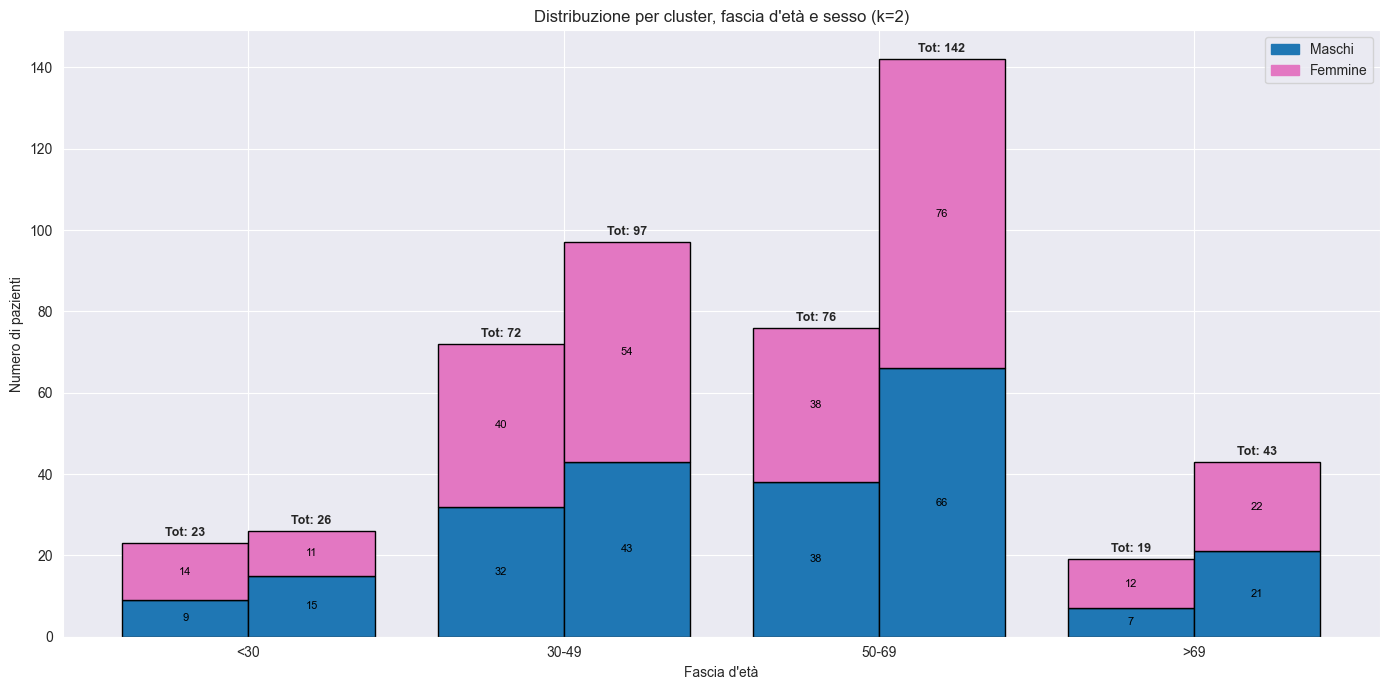

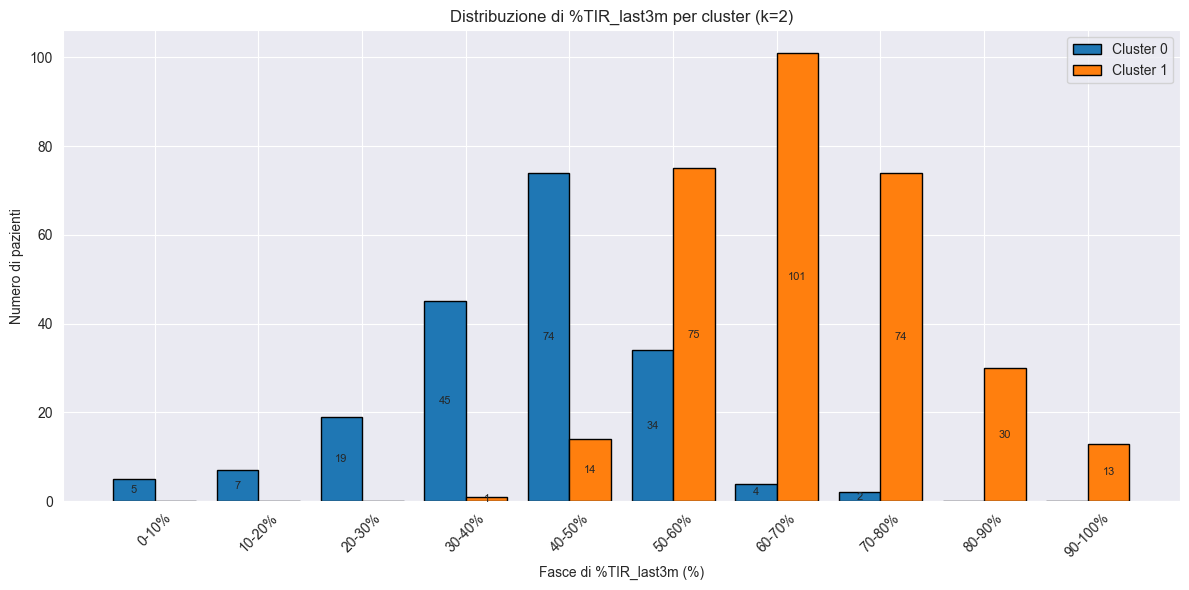

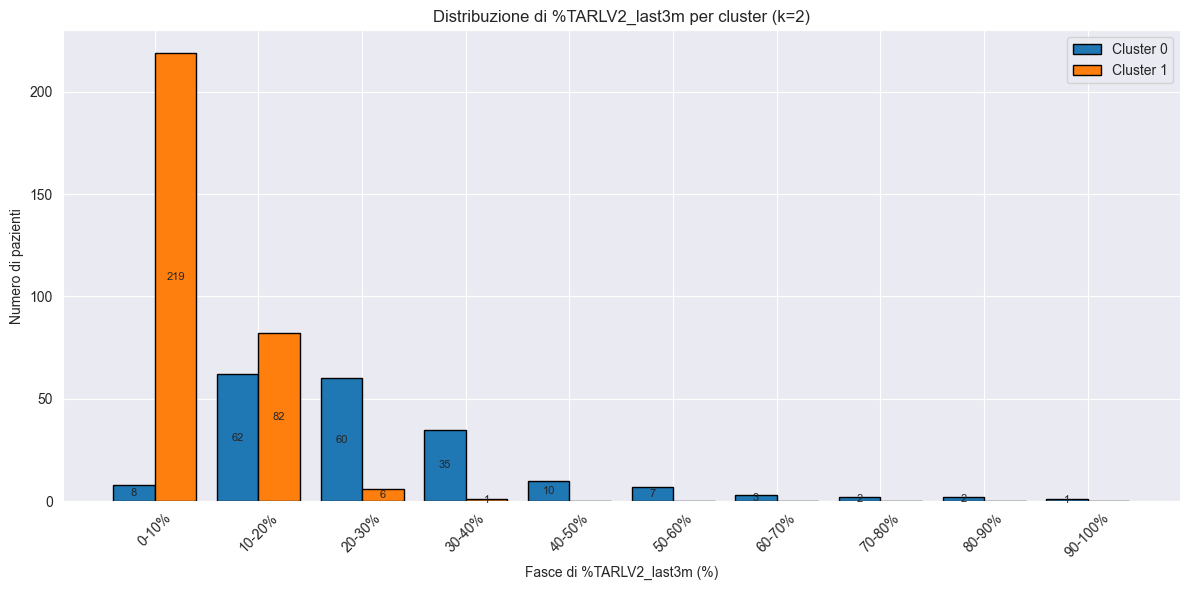

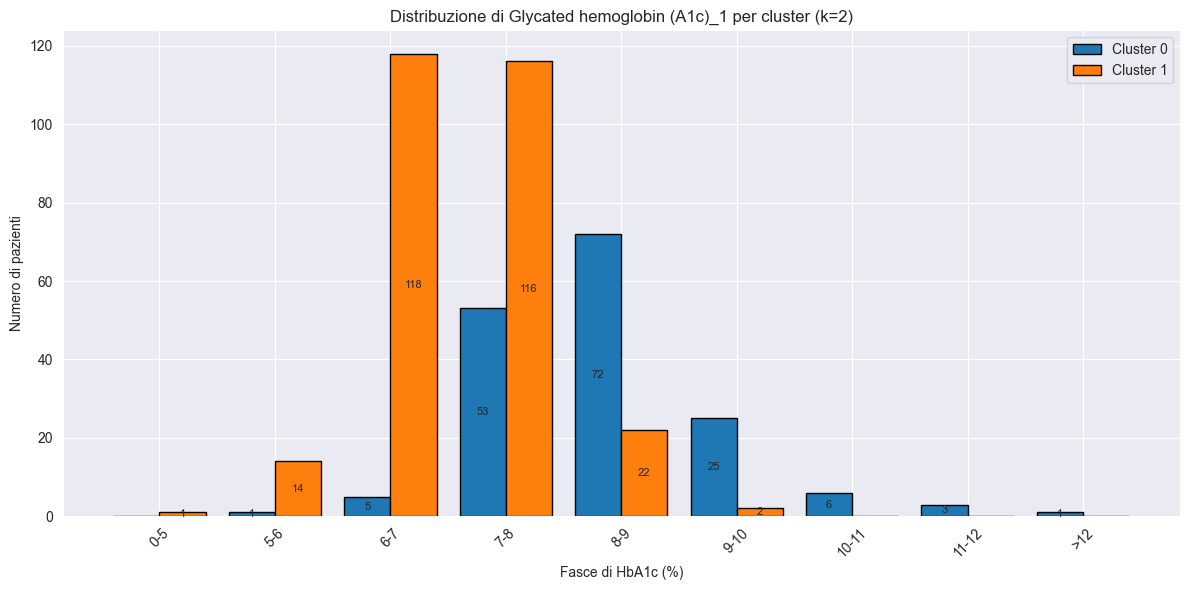

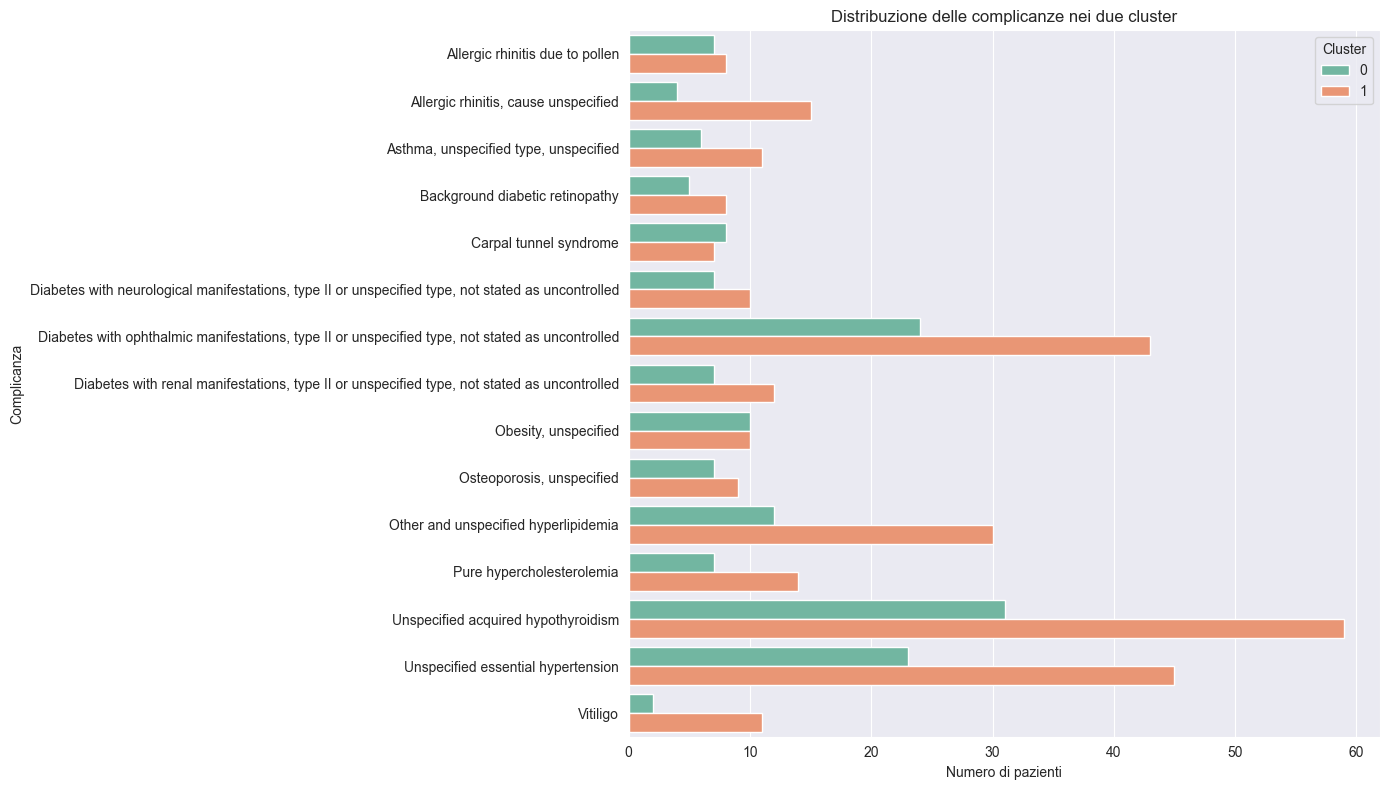

Tabella di contingenza:
 Cluster                                                                                              0   1
Description                                                                                               
Allergic rhinitis due to pollen                                                                      7   8
Allergic rhinitis, cause unspecified                                                                 4  15
Asthma, unspecified type, unspecified                                                                6  11
Background diabetic retinopathy                                                                      5   8
Carpal tunnel syndrome                                                                               8   7
Diabetes with neurological manifestations, type II or unspecified type, not stated as uncontrolled   7  10
Diabetes with ophthalmic manifestations, type II or unspecified type, not stated as uncontrolled    24  43
Diabetes wit

In [23]:
#CLUSTERING CON KMEANS SU DATASET CON E SENZA COMPLICANZE
#NOTA CHE IL CODICE E' LO STESSO PER ENTRAMBI, BASTA COMMENTARE E DECOMMENTARE A RIGA 130 E 131 PER SECGLIERE SU QUALE DATASET APPLICARLO, MA IL TEST CHI-QUADRO SE APPLICATO SU NoComplicanze2.csv FALLIRA' ED IL CODICE RESTITUIRA' ERRORE, PERCHE' LA TABELLA DI CONTINGENZA CHE SI OTTIENE E' VUOTA, VISTO CHE NON CI SONO COMPLICANZE, INVECE IL RESTO DEL CODICE MOSTRA I GRAFICI PER QUEL DATASET.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import f_oneway
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import chi2_contingency

# Funzione per il plot delle distribuzioni sesso e fasce età per ogni cluster
def plot_cluster_demographics(df_tmp, n_clusters):
    bins = [0, 29, 49, 69, np.inf]
    labels = ['<30', '30-49', '50-69', '>69']
    df_tmp['AgeGroup'] = pd.cut(df_tmp['Age'], bins=bins, labels=labels, right=True)

    cluster_data = []
    for cluster in range(n_clusters):
        cluster_df = df_tmp[df_tmp['Cluster'] == cluster]
        age_counts = []
        for age_group in labels:
            age_df = cluster_df[cluster_df['AgeGroup'] == age_group]
            male_count = len(age_df[age_df['Sex'] == 1])
            female_count = len(age_df[age_df['Sex'] == 0])
            total = male_count + female_count
            age_counts.append({'Male': male_count, 'Female': female_count, 'Total': total})
        cluster_data.append(age_counts)

    x = np.arange(len(labels))  # posizioni fasce d'età
    bar_width = 0.8 / n_clusters

    fig, ax = plt.subplots(figsize=(14,7))
    colors = {'Male': '#1f77b4', 'Female': '#e377c2'}

    for i in range(n_clusters):
        male_counts = [cluster_data[i][j]['Male'] for j in range(len(labels))]
        female_counts = [cluster_data[i][j]['Female'] for j in range(len(labels))]
        positions = x - 0.4 + i * bar_width + bar_width / 2

        bars_male = ax.bar(positions, male_counts, bar_width, color=colors['Male'], edgecolor='black', label=f'Maschi Cluster {i}')
        bars_female = ax.bar(positions, female_counts, bar_width, bottom=male_counts, color=colors['Female'], edgecolor='black', label=f'Femmine Cluster {i}')

        for bar, count in zip(bars_male, male_counts):
            if count > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, str(count), ha='center', va='center', fontsize=8, color='black')
        for bar, count, bottom in zip(bars_female, female_counts, male_counts):
            if count > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bottom + bar.get_height()/2, str(count), ha='center', va='center', fontsize=8, color='black')

        for pos, total in zip(positions, [cluster_data[i][j]['Total'] for j in range(len(labels))]):
            if total > 0:
                ax.text(pos, total + 1, f'Tot: {total}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Fascia d\'età')
    ax.set_ylabel('Numero di pazienti')
    ax.set_title(f'Distribuzione per cluster, fascia d\'età e sesso (k={n_clusters})')

    # Legenda con solo maschi e femmine
    colors = {'Male': '#1f77b4', 'Female': '#e377c2'}
    handles = [
        Patch(color=colors['Male'], label='Maschi'),
        Patch(color=colors['Female'], label='Femmine')
    ]
    ax.legend(handles=handles, loc='best')

    plt.tight_layout()
    plt.show()

# Nuova funzione per il plot degli istogrammi % TIR, TARLV2, Emoglobina glicata
def plot_percentage_histograms(df, clusters, n_clusters):
    # Variabili da plottare
    variables = ['%TIR_last3m', '%TARLV2_last3m', 'Glycated hemoglobin (A1c)_1']

    # Definizione bin personalizzati
    default_bins = np.arange(0, 110, 10)
    default_labels = [f'{default_bins[i]}-{default_bins[i+1]}%' for i in range(len(default_bins)-1)]

    a1c_bins = [0, 5, 6, 7, 8, 9, 10, 11, 12, np.inf]
    a1c_labels = [f'{a1c_bins[i]}-{a1c_bins[i+1]}' if a1c_bins[i+1] != np.inf else f'>{a1c_bins[i]}' for i in range(len(a1c_bins)-1)]

    for var in variables:
        if var == 'Glycated hemoglobin (A1c)_1':
            bins = a1c_bins
            bin_labels = a1c_labels
            xlabel = 'Fasce di HbA1c (%)'
        else:
            bins = default_bins
            bin_labels = default_labels
            xlabel = f'Fasce di {var} (%)'

        plt.figure(figsize=(12,6))
        x = np.arange(len(bin_labels))
        bar_width = 0.8 / n_clusters
        colors = plt.cm.tab10.colors

        # Per ogni cluster, conto pazienti per bin
        counts_per_cluster = []
        for c in range(n_clusters):
            cluster_vals = df.loc[clusters == c, var]
            cats = pd.cut(cluster_vals, bins=bins, labels=bin_labels, include_lowest=True, right=False)
            counts = cats.value_counts().reindex(bin_labels, fill_value=0)
            counts_per_cluster.append(counts.values)

        for c in range(n_clusters):
            positions = x - 0.4 + c * bar_width + bar_width/2
            plt.bar(positions, counts_per_cluster[c], width=bar_width, color=colors[c], edgecolor='black', label=f'Cluster {c}')
            for pos, count in zip(positions, counts_per_cluster[c]):
                if count > 0:
                    plt.text(pos, count/2, str(count), ha='center', va='center', fontsize=8)

        plt.xticks(x, bin_labels, rotation=45)
        plt.xlabel(xlabel)
        plt.ylabel('Numero di pazienti')
        plt.title(f'Distribuzione di {var} per cluster (k={n_clusters})')
        plt.legend()
        plt.tight_layout()
        plt.show()


# --- Main ---

# 1. Caricamento dati
df = pd.read_csv("Excel/Complicanze2.csv")
# df = pd.read_csv("Excel/NoComplicanze2.csv")

# 2. Separazione colonne demografiche (le reinseriremo dopo per i plot)
demographic_cols = ['Age', 'Sex', 'Patient_ID']
demographic_df = df[demographic_cols]

# 3. Dati per clustering (tutte le colonne tranne 'Age' e 'Sex')
X = df.drop(columns=demographic_cols)

# 4. Imputazione valori mancanti con media
imputer = SimpleImputer(strategy='mean')
X_imp = imputer.fit_transform(X)

# 5. Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# 6. Clustering per k=2
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# DataFrame temporaneo per plot + cluster
df_tmp = demographic_df.copy()
df_tmp['Cluster'] = clusters

# Plot distribuzioni demografiche
plot_cluster_demographics(df_tmp, n_clusters=k)

# Plot istogrammi percentuali TIR, TARLV2, Emoglobina glicata
plot_percentage_histograms(df, clusters, n_clusters=k)

# --- ANALISI IN DETTAGLIO DELLE COMPLICANZE ---

# 7. Carica il dataset delle complicanze (diagnostiche)
diagnostics_df = pd.read_csv("Excel/Diagnostics.csv")

# Controlla anche qui la presenza di Patient_ID
if 'Patient_ID' not in diagnostics_df.columns:
    raise ValueError("Il dataset Diagnostics.csv deve contenere la colonna 'Patient_ID'.")

# 8. Associa il cluster a ciascun paziente
patient_clusters = df_tmp[['Patient_ID', 'Cluster']]

# 9. Unisci le informazioni di cluster alle complicanze diagnostiche
diag_with_cluster = diagnostics_df.merge(patient_clusters, on="Patient_ID", how="inner")

# 10. Conta le complicanze per Description e Cluster
complication_counts = diag_with_cluster.groupby(['Description', 'Cluster']).size().reset_index(name='Count')

# 11. Calcola il totale delle complicanze e seleziona le 15 più frequenti
complication_totals = complication_counts.groupby('Description')['Count'].sum().reset_index()
top_complications = complication_totals.sort_values('Count', ascending=False).head(15)['Description']

# 12. Filtra per le prime 15 complicanze più frequenti
complication_counts_filtered = complication_counts[complication_counts['Description'].isin(top_complications)]

# 13. Plot complicanze più frequenti nei due cluster
plt.figure(figsize=(14, 8))
sns.barplot(data=complication_counts_filtered, x='Count', y='Description', hue='Cluster', palette='Set2')
plt.title('Distribuzione delle complicanze nei due cluster')
plt.xlabel('Numero di pazienti')
plt.ylabel('Complicanza')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# 14. Test chi-quadro di associazione

# Tabella di contingenza
contingency_table = pd.crosstab(
    diag_with_cluster[diag_with_cluster['Description'].isin(top_complications)]['Description'],
    diag_with_cluster[diag_with_cluster['Description'].isin(top_complications)]['Cluster']
)
print("Tabella di contingenza:\n", contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-quadro: chi2 = {chi2:.2f}, p-value = {p:.4f}")

=== Gruppo A (K=0, G=0) ===
  • Con complicanze diabetiche:     76
  • Con complicanze non-diabetiche: 176
  • Senza complicanze:              116

=== Gruppo B (K=1, G=1) ===
  • Con complicanze diabetiche:     29
  • Con complicanze non-diabetiche: 52
  • Senza complicanze:              26

=== Test ANOVA su Gruppo A (K=0, G=0) ===
=== Risultati ANOVA ===
Age                       | F =   18.018 | p = 3.4478e-08
Total cholesterol_1       | F =    8.768 | p = 1.9256e-04
Creatinine (urine)_1      | F =    7.675 | p = 5.5539e-04
Creatinine_1              | F =    6.193 | p = 2.2652e-03
Sex                       | F =    5.780 | p = 3.3793e-03
HDL cholesterol_1         | F =    3.606 | p = 2.8223e-02
Triglycerides_1           | F =    2.564 | p = 7.8433e-02
Albumin (urine)_1         | F =    2.040 | p = 1.3173e-01
Potassium_1               | F =    1.915 | p = 1.4884e-01
Uric acid_1               | F =    1.856 | p = 1.5807e-01
%TBRLV1_last3m            | F =    1.475 | p = 2.3014e-01
%T

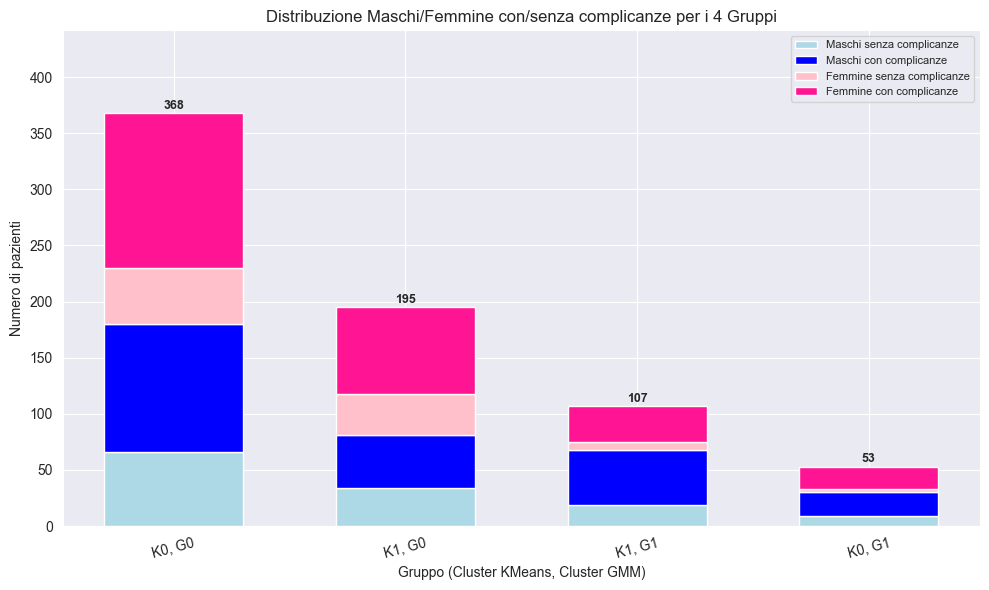

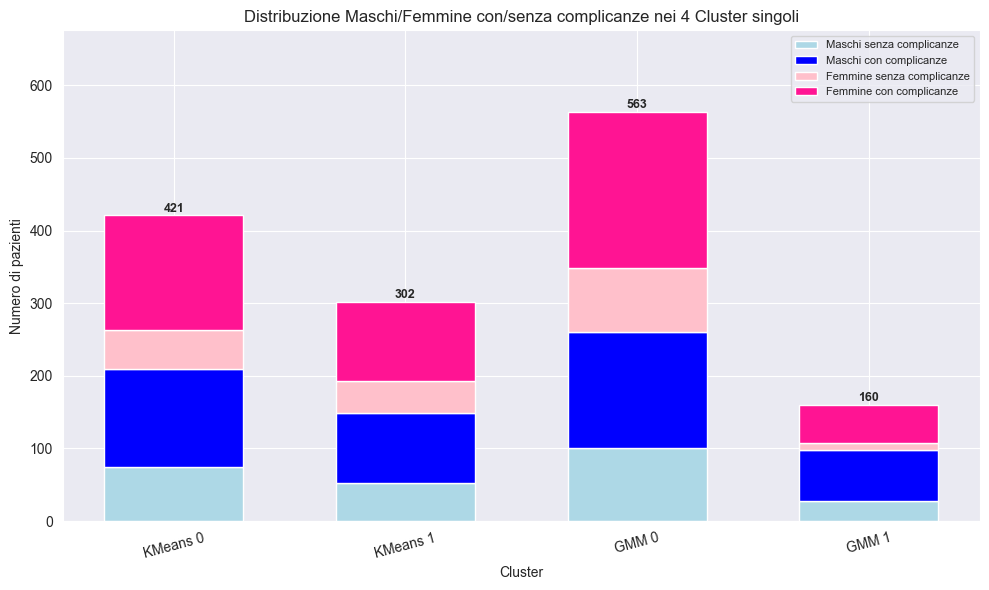

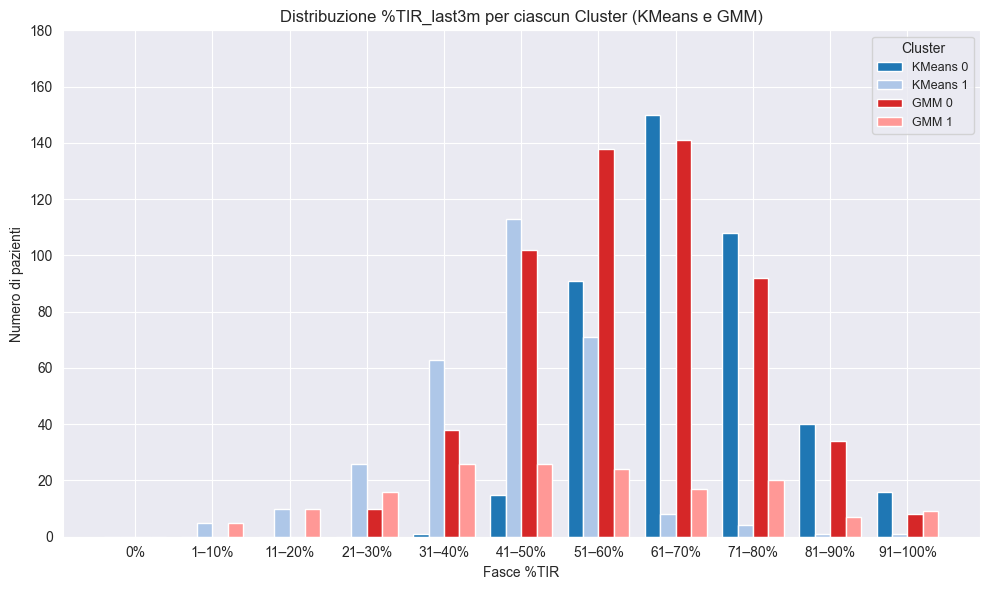

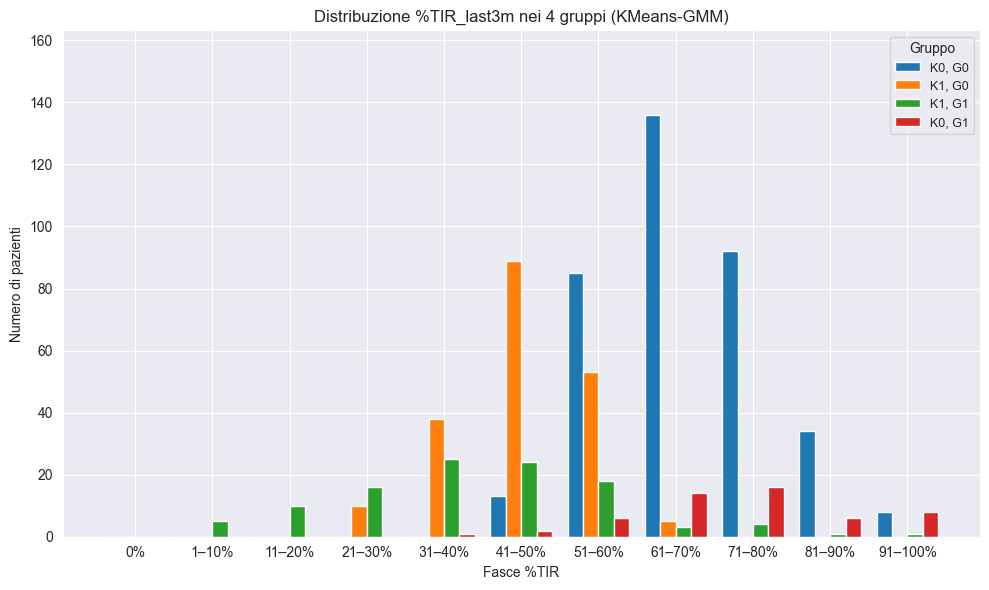

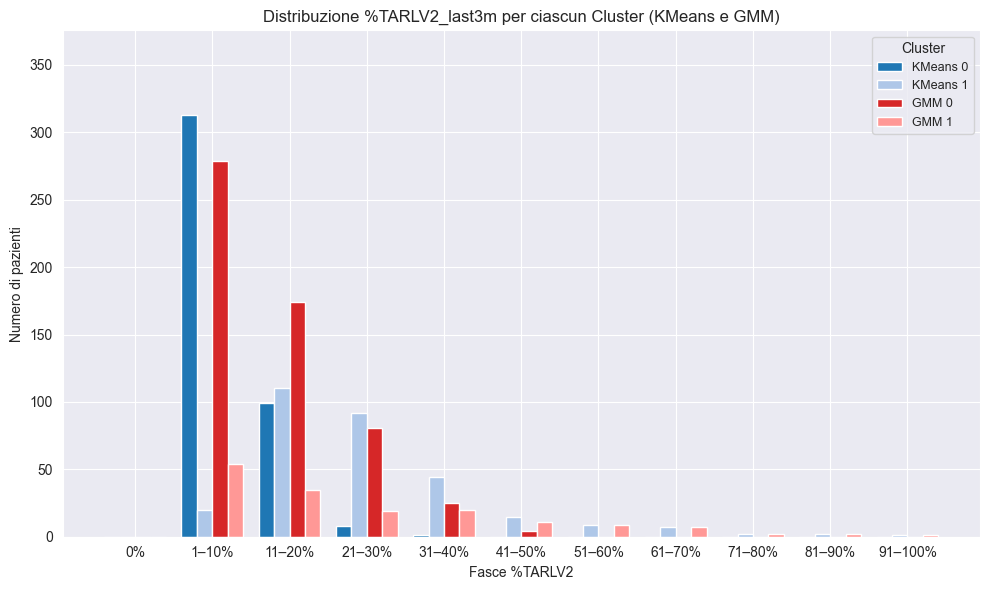

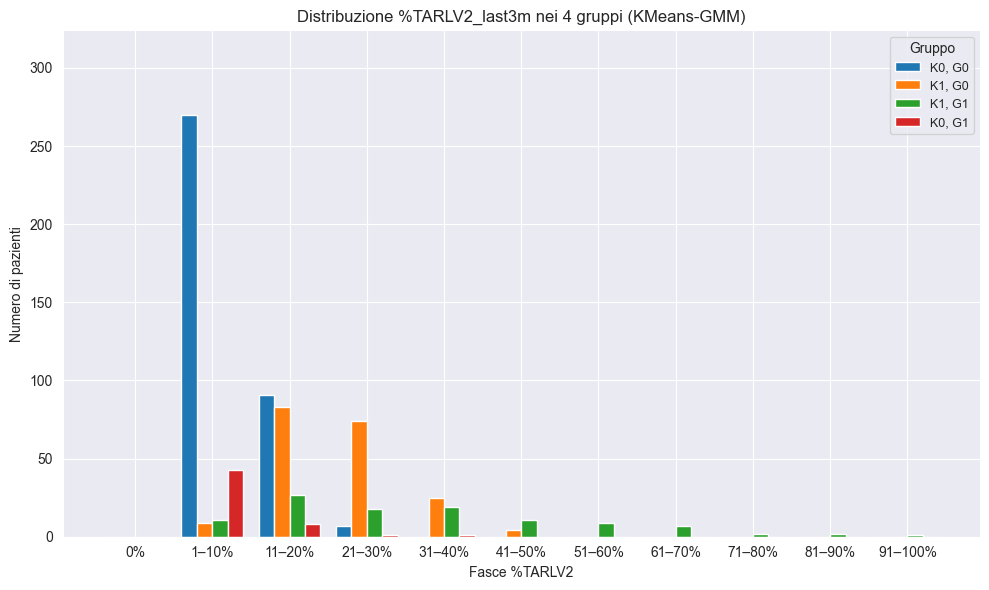

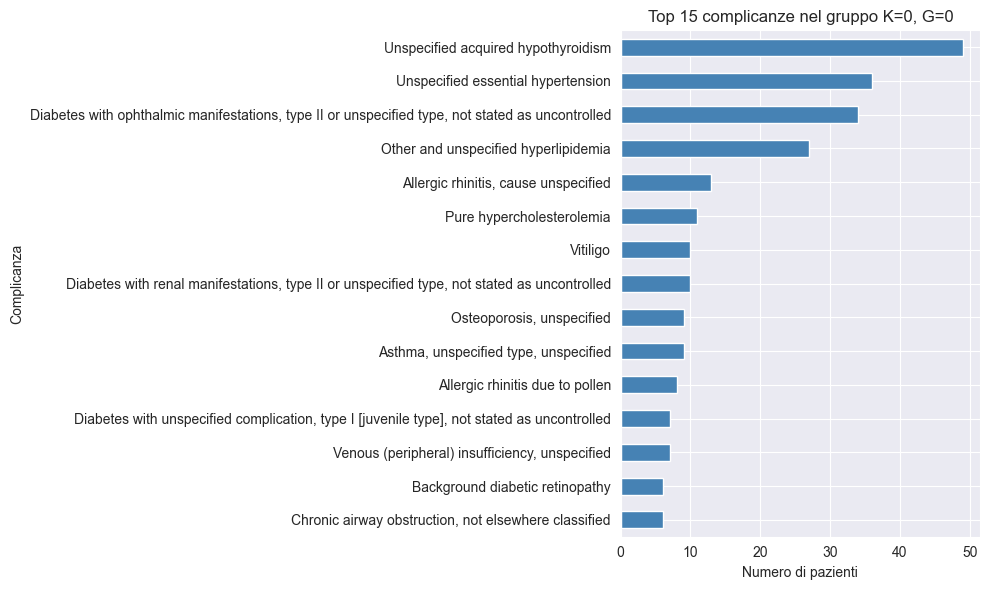

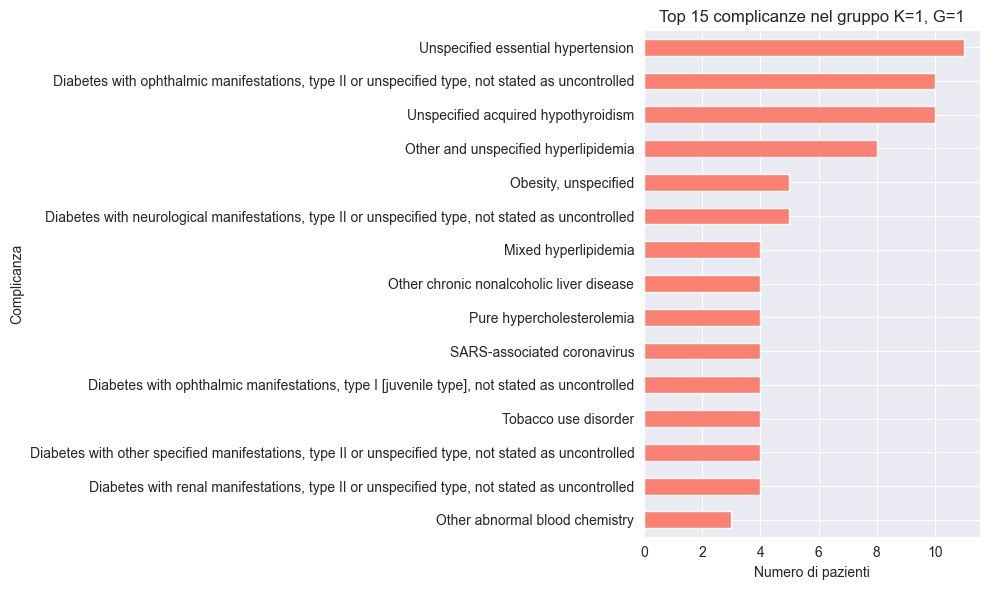

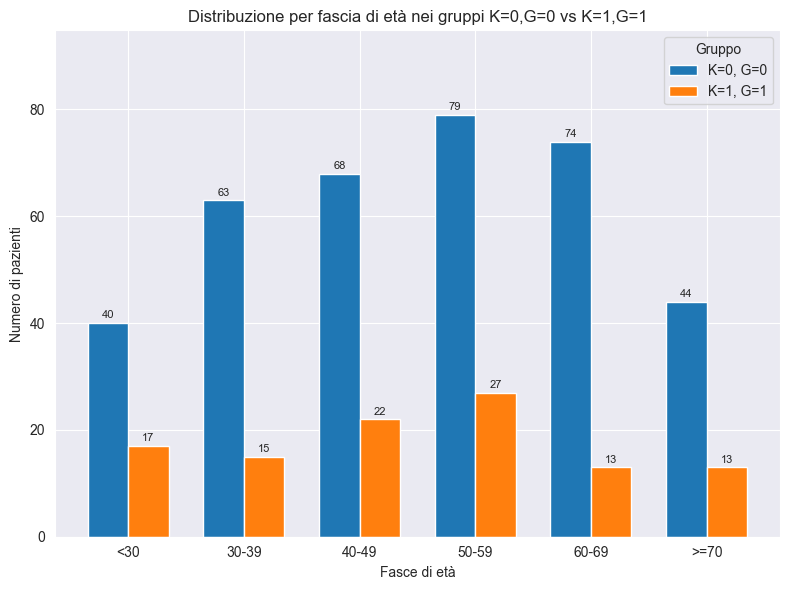

In [24]:
#CONFRONTO TRA I DUE GRUPPI OTTENUTI CONTROLLANDO KMEAN E GMM, (K=1,G=1) E (K=0,G=0), CALCOLO DEL TEST ANOVA E DEL TEST DI TUKEY PER IL GRUPPO A, PER IL GRUPPO B E PER LA SOMMA DI A & B

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ==============================================
# 1. CARICAMENTO E PREPROCESSING DEI DATI
# ==============================================
# - Carica i dataset da file CSV
# - Rimuove colonne non numeriche (ID paziente)
# - Gestisce valori mancanti con imputazione della media
# - Applica standardizzazione (scala le features)


df_all = pd.read_csv("Excel/Clustering2.csv")
df_diag = pd.read_csv("Excel/Diagnostics.csv")

X_all = df_all.drop(columns=["Patient_ID", "Has_Diagnostics"])
imputer = SimpleImputer(strategy="mean")
X_all_imp = imputer.fit_transform(X_all)
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all_imp)


# ==============================================
# 2. CLUSTERING
# ==============================================
# - Applica due algoritmi di clustering:
#   * K-Means con 2 cluster
#   * Gaussian Mixture Model (GMM) con 2 componenti
# - Aggiunge le etichette di cluster al dataframe originale


df_all["Cluster_KMeans"] = KMeans(
    n_clusters=2, init='random', n_init=10, max_iter=100, tol=0.001, algorithm='lloyd', random_state=42
).fit_predict(X_all_scaled)

df_all["Cluster_GMM"] = GaussianMixture(
    n_components=2, random_state=42
).fit_predict(X_all_scaled)

# ==============================================
# 3. ANALISI DEI GRUPPI COMBINATI
# ==============================================
# - Combina i risultati dei due algoritmi di clustering
# - Identifica i 4 gruppi combinati (KMeans x GMM)
# - Seleziona i due gruppi principali per l'analisi successiva
# - Suddivide ulteriormente in pazienti con/senza complicanze


group_sizes = (
    df_all
    .groupby(["Cluster_KMeans", "Cluster_GMM"])["Patient_ID"]
    .count()
    .reset_index(name="Size")
    .sort_values("Size", ascending=False)
)
group_order  = list(zip(group_sizes["Cluster_KMeans"], group_sizes["Cluster_GMM"]))

# --- Selezione dei due gruppi di interesse (K=1,G=1) e (K=0,G=0) ---
group_a = df_all[(df_all["Cluster_KMeans"] == 0) & (df_all["Cluster_GMM"] == 0)]
group_b = df_all[(df_all["Cluster_KMeans"] == 1) & (df_all["Cluster_GMM"] == 1)]

# --- All’interno di ogni gruppo, separo chi ha complicanze da chi non ne ha ---
group_a_with    = group_a[group_a["Has_Diagnostics"] == 1]
group_a_without = group_a[group_a["Has_Diagnostics"] == 0]
group_b_with    = group_b[group_b["Has_Diagnostics"] == 1]
group_b_without = group_b[group_b["Has_Diagnostics"] == 0]


# ==============================================
# 4. ANALISI DELLE COMPLICANZE DIABETICHE
# ==============================================
# - Definisce parole chiave per identificare complicanze diabetiche
# - Conta pazienti con complicanze diabetiche vs non-diabetiche
#   in ciascun gruppo selezionato


keywords_diab = [
    "diabetes", "diabetic", "neuropathy", "retinopathy", "retinal",
    "ocular", "hyperglyceridemia", "glycemic"
]

def has_diabetic_comp(patient_id: str, diag_df: pd.DataFrame) -> bool:
    subset = diag_df[diag_df["Patient_ID"] == patient_id]
    if subset.empty:
        return False
    for desc in subset["Description"].astype(str):
        d = desc.lower()
        if any(kw in d for kw in keywords_diab):
            return True
    return False

def count_diab_non_diab(group_with):
    count_diab, count_nondiab = 0, 0
    for pid in group_with["Patient_ID"].astype(str):
        if has_diabetic_comp(pid, df_diag):
            count_diab += 1
        else:
            count_nondiab += 1
    return count_diab, count_nondiab

count_A_diab, count_A_nondiab = count_diab_non_diab(group_a_with)
count_B_diab, count_B_nondiab = count_diab_non_diab(group_b_with)

print("=== Gruppo A (K=0, G=0) ===")
print(f"  • Con complicanze diabetiche:     {count_A_diab}")
print(f"  • Con complicanze non-diabetiche: {count_A_nondiab}")
print(f"  • Senza complicanze:              {len(group_a_without)}")

print("\n=== Gruppo B (K=1, G=1) ===")
print(f"  • Con complicanze diabetiche:     {count_B_diab}")
print(f"  • Con complicanze non-diabetiche: {count_B_nondiab}")
print(f"  • Senza complicanze:              {len(group_b_without)}")


# ==============================================
# 5. ANALISI STATISTICA (ANOVA E TUKEY)
# ==============================================
# - Esegue test ANOVA per confrontare le medie tra gruppi
# - Applica test post-hoc di Tukey per confronti multipli
# - Lo fa separatamente per:
#   * Ciascun gruppo combinato (A e B)
#   * Tutti i pazienti aggregati


def label_class(df):
    df = df.copy()
    df["Class"] = df["Patient_ID"].astype(str).apply(
        lambda pid: "diabetic" if has_diabetic_comp(pid, df_diag) else "non_diabetic"
    )
    df.loc[df["Has_Diagnostics"] == 0, "Class"] = "healthy"
    return df

df_labeled_A = label_class(pd.concat([group_a_with, group_a_without]))
df_labeled_B = label_class(pd.concat([group_b_with, group_b_without]))

def run_anova_tukey(df_group, group_name):
    print(f"\n=== Test ANOVA su Gruppo {group_name} ===")
    cols = [c for c in df_group.columns if c not in ["Patient_ID", "Has_Diagnostics", "Cluster_KMeans", "Cluster_GMM", "Class"]]
    results = []
    for col in cols:
        groups = [df_group[df_group["Class"] == cl][col].dropna() for cl in ["diabetic", "non_diabetic", "healthy"]]
        if any(g.empty for g in groups):
            continue
        stat, pval = f_oneway(*groups)
        results.append((col, stat, pval))
    results.sort(key=lambda x: x[2])
    print("=== Risultati ANOVA ===")
    for col, stat, pval in results:
        print(f"{col:<25} | F = {stat:8.3f} | p = {pval:.4e}")

    print(f"\n=== Test Tukey HSD su Gruppo {group_name} ===")
    tukey_results = []
    for col in cols:
        data = df_group[[col, "Class"]].dropna()
        if data["Class"].nunique() < 2:
            continue
        try:
            tukey = pairwise_tukeyhsd(endog=data[col], groups=data["Class"], alpha=0.05)
            df_tukey = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
            df_tukey.insert(0, "Variable", col)
            tukey_results.append(df_tukey)
        except:
            continue
    if tukey_results:
        df_tukey_all = pd.concat(tukey_results, ignore_index=True)
        print("=== Risultati Tukey HSD ===")
        print(df_tukey_all.to_string(index=False))
    else:
        print("Nessun risultato Tukey disponibile")

# Eseguo ANOVA + Tukey su ciascun gruppo
run_anova_tukey(df_labeled_A, "A (K=0, G=0)")
run_anova_tukey(df_labeled_B, "B (K=1, G=1)")

# ==============================================
# Rieseguiamo i test sul totale combinato dei due gruppi
# ==============================================
df_diabetic = pd.concat([group_a_with, group_b_with])
df_diabetic = df_diabetic[df_diabetic["Patient_ID"].astype(str).isin(
    [pid for pid in df_diag["Patient_ID"].astype(str) if has_diabetic_comp(pid, df_diag)]
)].assign(Class="diabetic")

df_nondiabetic = pd.concat([group_a_with, group_b_with])
df_nondiabetic = df_nondiabetic[~df_nondiabetic["Patient_ID"].isin(df_diabetic["Patient_ID"])].assign(Class="non_diabetic")

df_healthy = pd.concat([group_a_without, group_b_without]).assign(Class="healthy")

df_labeled = pd.concat([df_diabetic, df_nondiabetic, df_healthy])

run_anova_tukey(df_labeled, "Totale combinato (diabetic, non_diabetic, healthy)")

#################################################################################################################


# ==============================================
# 6. VISUALIZZAZIONI
# ==============================================
# - Genera vari plot per analizzare:
#   6.1 Distribuzione per sesso e presenza complicanze
#   6.2 Distribuzione %TIR (Time In Range)
#   6.3 Distribuzione %TAR (Time Above Range)
#   6.4 Top complicanze per gruppo
#   6.5 Distribuzione per fasce d'età


# ---  6.1 Grafico sesso/complicanze ---
group_counts = []

for (k_label, g_label) in group_order:
    subset = df_all[(df_all["Cluster_KMeans"] == k_label) & (df_all["Cluster_GMM"] == g_label)]
    M_with = int(((subset["Sex"] == 1) & (subset["Has_Diagnostics"] == 1)).sum())
    M_without = int(((subset["Sex"] == 1) & (subset["Has_Diagnostics"] == 0)).sum())
    F_with = int(((subset["Sex"] == 0) & (subset["Has_Diagnostics"] == 1)).sum())
    F_without = int(((subset["Sex"] == 0) & (subset["Has_Diagnostics"] == 0)).sum())

    group_counts.append({
        'M_with': M_with,
        'M_without': M_without,
        'F_with': F_with,
        'F_without': F_without
    })

ind = np.arange(len(group_order))
width = 0.6
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'M_without': 'lightblue', 'M_with': 'blue', 'F_without': 'pink', 'F_with': 'deeppink'}

bottom_m = np.zeros(len(group_order))
bottom_f = np.zeros(len(group_order))

m_without_vals = [g['M_without'] for g in group_counts]
m_with_vals    = [g['M_with'] for g in group_counts]
f_without_vals = [g['F_without'] for g in group_counts]
f_with_vals    = [g['F_with'] for g in group_counts]

ax.bar(ind, m_without_vals, width, color=colors['M_without'], label='Maschi senza complicanze')
bottom_m = np.array(m_without_vals)

ax.bar(ind, m_with_vals, width, bottom=bottom_m, color=colors['M_with'], label='Maschi con complicanze')
bottom_m += np.array(m_with_vals)

ax.bar(ind, f_without_vals, width, bottom=bottom_m, color=colors['F_without'], label='Femmine senza complicanze')
bottom_f = bottom_m + np.array(f_without_vals)

ax.bar(ind, f_with_vals, width, bottom=bottom_f, color=colors['F_with'], label='Femmine con complicanze')

for i in range(len(group_order)):
    total = m_without_vals[i] + m_with_vals[i] + f_without_vals[i] + f_with_vals[i]
    if total > 0:
        ax.text(ind[i], total + 1, str(total), ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_title("Distribuzione Maschi/Femmine con/senza complicanze per i 4 Gruppi")
ax.set_xlabel("Gruppo (Cluster KMeans, Cluster GMM)")
ax.set_ylabel("Numero di pazienti")
ax.set_xticks(ind)
group_labels = [f"K{k}, G{g}" for (k, g) in group_order]
ax.set_xticklabels(group_labels, rotation=15)
ax.legend(loc='upper right', fontsize=8)
ax.set_ylim(0, max(group_sizes["Size"]) * 1.2)
plt.tight_layout()
plt.show()

# --- 6.1 Istogramma sesso/complicanze per i 4 cluster singoli (KMeans e GMM) ---

cluster_defs = [
    ("KMeans 0", df_all[df_all["Cluster_KMeans"] == 0]),
    ("KMeans 1", df_all[df_all["Cluster_KMeans"] == 1]),
    ("GMM 0", df_all[df_all["Cluster_GMM"] == 0]),
    ("GMM 1", df_all[df_all["Cluster_GMM"] == 1])
]


cluster_labels = [label for label, _ in cluster_defs]
cluster_counts = []

for label, subset in cluster_defs:
    M_with = int(((subset["Sex"] == 1) & (subset["Has_Diagnostics"] == 1)).sum())
    M_without = int(((subset["Sex"] == 1) & (subset["Has_Diagnostics"] == 0)).sum())
    F_with = int(((subset["Sex"] == 0) & (subset["Has_Diagnostics"] == 1)).sum())
    F_without = int(((subset["Sex"] == 0) & (subset["Has_Diagnostics"] == 0)).sum())

    cluster_counts.append({
        'M_with': M_with,
        'M_without': M_without,
        'F_with': F_with,
        'F_without': F_without
    })

# Grafico
ind = np.arange(len(cluster_labels))
width = 0.6
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'M_without': 'lightblue', 'M_with': 'blue', 'F_without': 'pink', 'F_with': 'deeppink'}

m_without_vals = [g['M_without'] for g in cluster_counts]
m_with_vals    = [g['M_with'] for g in cluster_counts]
f_without_vals = [g['F_without'] for g in cluster_counts]
f_with_vals    = [g['F_with'] for g in cluster_counts]

bottom_m = np.zeros(len(cluster_labels))
ax.bar(ind, m_without_vals, width, color=colors['M_without'], label='Maschi senza complicanze')
bottom_m += m_without_vals

ax.bar(ind, m_with_vals, width, bottom=bottom_m, color=colors['M_with'], label='Maschi con complicanze')
bottom_m += m_with_vals

ax.bar(ind, f_without_vals, width, bottom=bottom_m, color=colors['F_without'], label='Femmine senza complicanze')
bottom_f = bottom_m + f_without_vals

ax.bar(ind, f_with_vals, width, bottom=bottom_f, color=colors['F_with'], label='Femmine con complicanze')

# Totali sopra le colonne
for i in range(len(cluster_labels)):
    total = m_without_vals[i] + m_with_vals[i] + f_without_vals[i] + f_with_vals[i]
    if total > 0:
        ax.text(ind[i], total + 1, str(total), ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_title("Distribuzione Maschi/Femmine con/senza complicanze nei 4 Cluster singoli")
ax.set_xlabel("Cluster")
ax.set_ylabel("Numero di pazienti")
ax.set_xticks(ind)
ax.set_xticklabels(cluster_labels, rotation=15)
ax.legend(loc='upper right', fontsize=8)
ax.set_ylim(0, max([m + f + mw + fw for m, mw, f, fw in zip(m_without_vals, m_with_vals, f_without_vals, f_with_vals)]) * 1.2)
plt.tight_layout()
plt.show()


# --- 7. Istogramma %TIR per i 4 Cluster singoli (KMeans e GMM) ---
tir_bins = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
tir_labels = [
    "0%", "1–10%", "11–20%", "21–30%", "31–40%", "41–50%",
    "51–60%", "61–70%", "71–80%", "81–90%", "91–100%"
]

tir_counts_by_cluster = {}
for label, subset in cluster_defs:
    tir_vals = subset["%TIR_last3m"].dropna()
    tir_bins_idx = pd.cut(tir_vals, bins=tir_bins, labels=tir_labels, include_lowest=True, right=False)
    tir_counts = tir_bins_idx.value_counts().reindex(tir_labels, fill_value=0)
    tir_counts_by_cluster[label] = tir_counts.tolist()

# Plot
n_bins = len(tir_labels)
bar_width = 0.2
x = np.arange(n_bins)
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#1f77b4', '#aec7e8', '#d62728', '#ff9896']

for idx, (label, _) in enumerate(cluster_defs):
    counts = tir_counts_by_cluster[label]
    bar_x = x + idx * bar_width - (bar_width * (len(cluster_defs) - 1) / 2)
    ax.bar(bar_x, counts, width=bar_width, label=label, color=colors[idx])

ax.set_title("Distribuzione %TIR_last3m per ciascun Cluster (KMeans e GMM)")
ax.set_xlabel("Fasce %TIR")
ax.set_ylabel("Numero di pazienti")
ax.set_xticks(x)
ax.set_xticklabels(tir_labels)
ax.legend(title="Cluster", fontsize=9)
ax.set_ylim(0, max(sum(zip(*tir_counts_by_cluster.values()), ())) * 1.2)
plt.tight_layout()
plt.show()

# --- 6.2 Istogramma %TIR per i 4 gruppi combinati ---
tir_counts_by_group = {label: [0]*len(tir_labels) for label in group_labels}

for (k_label, g_label), label in zip(group_order, group_labels):
    subset = df_all[(df_all["Cluster_KMeans"] == k_label) & (df_all["Cluster_GMM"] == g_label)]
    tir_vals = subset["%TIR_last3m"].dropna()
    tir_bins_idx = pd.cut(tir_vals, bins=tir_bins, labels=tir_labels, include_lowest=True, right=False)
    tir_counts = tir_bins_idx.value_counts().reindex(tir_labels, fill_value=0)
    tir_counts_by_group[label] = tir_counts.tolist()

# Plot
bar_width = 0.2
x = np.arange(n_bins)
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, label in enumerate(group_labels):
    counts = tir_counts_by_group[label]
    bar_x = x + idx * bar_width - (bar_width * (len(group_labels) - 1) / 2)
    ax.bar(bar_x, counts, width=bar_width, label=label, color=colors[idx])

ax.set_title("Distribuzione %TIR_last3m nei 4 gruppi (KMeans-GMM)")
ax.set_xlabel("Fasce %TIR")
ax.set_ylabel("Numero di pazienti")
ax.set_xticks(x)
ax.set_xticklabels(tir_labels)
ax.legend(title="Gruppo", fontsize=9)
ax.set_ylim(0, max(sum(zip(*tir_counts_by_group.values()), ())) * 1.2)
plt.tight_layout()
plt.show()


# --- 6.3 Istogramma %TAR per i 4 Cluster singoli (KMeans e GMM) ---
tir_bins = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
tir_labels = [
    "0%", "1–10%", "11–20%", "21–30%", "31–40%", "41–50%",
    "51–60%", "61–70%", "71–80%", "81–90%", "91–100%"
]

tir_counts_by_cluster = {}
for label, subset in cluster_defs:
    tir_vals = subset["%TARLV2_last3m"].dropna()
    tir_bins_idx = pd.cut(tir_vals, bins=tir_bins, labels=tir_labels, include_lowest=True, right=False)
    tir_counts = tir_bins_idx.value_counts().reindex(tir_labels, fill_value=0)
    tir_counts_by_cluster[label] = tir_counts.tolist()

# Plot
n_bins = len(tir_labels)
bar_width = 0.2
x = np.arange(n_bins)
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#1f77b4', '#aec7e8', '#d62728', '#ff9896']

for idx, (label, _) in enumerate(cluster_defs):
    counts = tir_counts_by_cluster[label]
    bar_x = x + idx * bar_width - (bar_width * (len(cluster_defs) - 1) / 2)
    ax.bar(bar_x, counts, width=bar_width, label=label, color=colors[idx])

ax.set_title("Distribuzione %TARLV2_last3m per ciascun Cluster (KMeans e GMM)")
ax.set_xlabel("Fasce %TARLV2")
ax.set_ylabel("Numero di pazienti")
ax.set_xticks(x)
ax.set_xticklabels(tir_labels)
ax.legend(title="Cluster", fontsize=9)
ax.set_ylim(0, max(sum(zip(*tir_counts_by_cluster.values()), ())) * 1.2)
plt.tight_layout()
plt.show()

# --- 6.3 Istogramma %TAR per i 4 gruppi combinati ---
tir_counts_by_group = {label: [0]*len(tir_labels) for label in group_labels}

for (k_label, g_label), label in zip(group_order, group_labels):
    subset = df_all[(df_all["Cluster_KMeans"] == k_label) & (df_all["Cluster_GMM"] == g_label)]
    tir_vals = subset["%TARLV2_last3m"].dropna()
    tir_bins_idx = pd.cut(tir_vals, bins=tir_bins, labels=tir_labels, include_lowest=True, right=False)
    tir_counts = tir_bins_idx.value_counts().reindex(tir_labels, fill_value=0)
    tir_counts_by_group[label] = tir_counts.tolist()

# Plot
bar_width = 0.2
x = np.arange(n_bins)
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, label in enumerate(group_labels):
    counts = tir_counts_by_group[label]
    bar_x = x + idx * bar_width - (bar_width * (len(group_labels) - 1) / 2)
    ax.bar(bar_x, counts, width=bar_width, label=label, color=colors[idx])

ax.set_title("Distribuzione %TARLV2_last3m nei 4 gruppi (KMeans-GMM)")
ax.set_xlabel("Fasce %TARLV2")
ax.set_ylabel("Numero di pazienti")
ax.set_xticks(x)
ax.set_xticklabels(tir_labels)
ax.legend(title="Gruppo", fontsize=9)
ax.set_ylim(0, max(sum(zip(*tir_counts_by_group.values()), ())) * 1.2)
plt.tight_layout()
plt.show()

# --- 6.4 Analisi complicanze per i gruppi K=0,G=0 e K=1,G=1 ---

# Seleziona i due gruppi
group_a = df_all[(df_all["Cluster_KMeans"] == 0) & (df_all["Cluster_GMM"] == 0)]
group_b = df_all[(df_all["Cluster_KMeans"] == 1) & (df_all["Cluster_GMM"] == 1)]

# Filtra i record delle complicanze per ciascun gruppo
group_a_diag = df_diag[df_diag["Patient_ID"].isin(group_a["Patient_ID"])]
group_b_diag = df_diag[df_diag["Patient_ID"].isin(group_b["Patient_ID"])]

# Conta le complicanze per ciascun gruppo
top_a = group_a_diag["Description"].value_counts().nlargest(15)
top_b = group_b_diag["Description"].value_counts().nlargest(15)

# Plot gruppo A
plt.figure(figsize=(10, 6))
top_a[::-1].plot(kind="barh", color="steelblue")
plt.title("Top 15 complicanze nel gruppo K=0, G=0")
plt.xlabel("Numero di pazienti")
plt.ylabel("Complicanza")
plt.tight_layout()
plt.show()

# Plot gruppo B
plt.figure(figsize=(10, 6))
top_b[::-1].plot(kind="barh", color="salmon")
plt.title("Top 15 complicanze nel gruppo K=1, G=1")
plt.xlabel("Numero di pazienti")
plt.ylabel("Complicanza")
plt.tight_layout()
plt.show()


# --- 6.5 Istogramma fasce di età per i gruppi K=0,G=0 e K=1,G=1 ---

# Usa 'group_a' e 'group_b' già definiti in /8. Analisi complicanze/
# group_a = df_all[(Cluster_KMeans==0)&(Cluster_GMM==0)]
# group_b = df_all[(Cluster_KMeans==1)&(Cluster_GMM==1)]

# Definisci le fasce di età
age_bins = [0, 30, 40, 50, 60, 70, np.inf]
age_labels = ["<30", "30-39", "40-49", "50-59", "60-69", ">=70"]


# Assegna la fascia di età a ciascun paziente
df_all["Age_bin"] = pd.cut(df_all["Age"], bins=age_bins, labels=age_labels, right=False)

# Conta quanti pazienti per fascia nei due gruppi
counts_a = df_all[
    (df_all["Cluster_KMeans"] == 0) & (df_all["Cluster_GMM"] == 0)
]["Age_bin"].value_counts().reindex(age_labels, fill_value=0)

counts_b = df_all[
    (df_all["Cluster_KMeans"] == 1) & (df_all["Cluster_GMM"] == 1)
]["Age_bin"].value_counts().reindex(age_labels, fill_value=0)

# Prepara i dati per il plot
x = np.arange(len(age_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars_a = ax.bar(x - width/2, counts_a, width, label="K=0, G=0", color="#1f77b4")
bars_b = ax.bar(x + width/2, counts_b, width, label="K=1, G=1", color="#ff7f0e")

# Etichette sopra ogni barra
for bar in bars_a:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)),
                ha="center", va="bottom", fontsize=8)
for bar in bars_b:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)),
                ha="center", va="bottom", fontsize=8)

ax.set_title("Distribuzione per fascia di età nei gruppi K=0,G=0 vs K=1,G=1")
ax.set_xlabel("Fasce di età")
ax.set_ylabel("Numero di pazienti")
ax.set_xticks(x)
ax.set_xticklabels(age_labels)
ax.legend(title="Gruppo")
ax.set_ylim(0, max(counts_a.max(), counts_b.max()) * 1.2)

plt.tight_layout()
plt.show()




In [27]:
#CODICE PER CREARE UN DATASET CONTENENTE OGNI SINGOLA COMPLICANZA (SENZA DUPLICATI), E PER OGNUNA MOSTRARE CODICE, DESCRIZIONE E CATEGORIA (DIABETICA O NON DIABETICA)

import pandas as pd

# --- Parole chiave per identificare complicanze diabetiche (case-insensitive) ---
keywords_diab = [
    "diabetes",
    "diabetic",
    "neuropathy",
    "retinopathy",
    "retinal",
    "ocular",
    "hyperglyceridemia",
    "glycemic"
]

# --- Funzione per classificare la descrizione ---
def classify_complication(description: str) -> str:
    """
    Classifica la complicanza come 'Diabetica' o 'Non diabetica'
    sulla base della presenza di parole chiave nella descrizione.
    """
    desc_lower = str(description).lower()
    for kw in keywords_diab:
        if kw in desc_lower:
            return "Diabetica"
    return "Non diabetica"

# --- Caricamento e creazione del nuovo dataset ---
df_diag = pd.read_csv("Excel/Diagnostics.csv")

# Rimuovi duplicati mantenendo solo la prima occorrenza per ciascun codice
df_unique = df_diag.drop_duplicates(subset="Code", keep="first").copy()

# Applica la classificazione
df_unique["TipoComplicanza"] = df_unique["Description"].apply(classify_complication)

df_final = df_unique[["Code", "Description", "TipoComplicanza"]]

# Opzionale: salva su CSV
df_final.to_csv("Excel/Complicanze_classificate.csv", index=False)

# Output di esempio
print(df_final)


        Code                                                                       Description TipoComplicanza
0      272.4                                              Other and unspecified hyperlipidemia   Non diabetica
1      354.0                                                            Carpal tunnel syndrome   Non diabetica
2     574.00  Calculus of gallbladder with acute cholecystitis, without mention of obstruction   Non diabetica
3     719.41                                                    Pain in joint, shoulder region   Non diabetica
4      253.5                                                                Diabetes insipidus       Diabetica
...      ...                                                                               ...             ...
1745   721.3                                        Lumbosacral spondylosis without myelopathy   Non diabetica
1746   724.9                                                  Other unspecified back disorders   Non diabetica
1